In [2]:
###  Import librairies and define variables
import os
import pandas as pd
# Principal parameters below
# Select company and data ***CHANGE VALUE HERE***
compTick = 'AAPL'
# Folder in which the sentiment file is
root_for_sentiments='CFDS_Tweets_Sentiment'+ os.sep
sufix = '_daily_sentiment_tweets.csv'

# Load the prices from Bloomberg
data_comp = [['ORCL','Oracle'],['MSFT','Microsoft'],['CRM','Salesforce'],
             ['AAPL','Apple'],['PYPL','Paypal'],['V','Visa'],['MA','Mastercard'],
             ['INTC','Intel Corp'],['CSCO','Cisco Systems'],['NVDA','Nvidia'],['ADBE','Adobe']]
companies = pd.DataFrame(data_comp, columns = ['ticker_root','name'])

#-*- coding: utf-8 -*-
import datetime as dt
import numpy as np
import csv
from pandas import read_csv
import shutil

# back testing for trading signals
import bt as bt

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import dataloader

# sklearn libraries
from sklearn import preprocessing

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']= 150

%matplotlib inline

if not os.path.exists('./data'): os.makedirs('./data')  # create data directory
if not os.path.exists('./models'): os.makedirs('./models')  # create trained models directory
    
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU


market_data_file = 'CoursBloomberg' + os.sep + 'CFDS_prices_all_calendar_days.csv'
market_data_file_return = 'CoursBloomberg' + os.sep + 'CFDS_prices_all_calendar_days_return.csv'
market_data = read_csv(market_data_file, sep=';', header=0, parse_dates=[0], infer_datetime_format=True)


for index, row in companies.iterrows():
    headername = row['ticker_root'] + '_Return'
    headerticker = row['ticker_root'] + ' US Equity'
    market_data[headername] = market_data[headerticker].pct_change()
    
# Remove first return line
market_data = market_data.drop(0)
market_data.to_csv(market_data_file_return, sep = ";", header=True, index=True)
market_data = market_data.set_index('Date')

# Transform Time-Series Into Sequences


# number of timesteps
sequence_length = 5


/usr/local/lib/python3.8/dist-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/usr/local/lib/python3.8/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


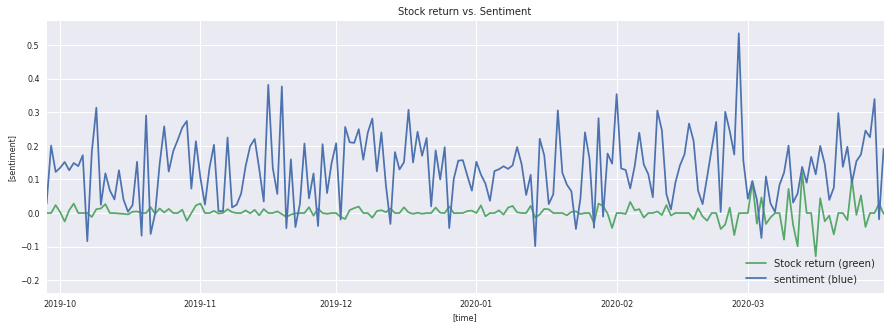

In [3]:
# We can loop over companies
#for company in companies:
#    stock_daily_returns[] = stock_data['RETURN'][1:len(stock_data['RETURN'])]

compName = companies[companies.ticker_root==compTick].name.item()

fields = ['Date','Comp']
sentiment = pd.read_csv(root_for_sentiments + compName + sufix, sep = "|", header=0, usecols=fields, index_col='Date')

c = sentiment['Comp']
#print(c[:5])


# plot the sentiment and the return
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(pd.to_datetime(market_data.index).values[0:market_data.shape[0],], market_data[compTick + '_Return'], color='C1', label='Stock return (green)')
ax.plot(pd.to_datetime(sentiment.index).values[0:sentiment.shape[0],], sentiment, color='C0', label='sentiment (blue)')

# set y-axis limits
ax.set_xlim(pd.to_datetime(sentiment.index).values[1000], pd.to_datetime(sentiment.index).values[1185])

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

plt.title('Stock return vs. Sentiment', fontsize=10)
plt.xlabel('[time]', fontsize=8)
plt.ylabel('[sentiment]', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)


for i in range(0, c.shape[0] - sequence_length):
    single_sentiment_sequence_data = c[i:i + sequence_length].T

    if i == 0:
        sentiment_sequence_data = np.array(single_sentiment_sequence_data)

    else:
        sentiment_sequence_data  = np.vstack((sentiment_sequence_data , np.array(single_sentiment_sequence_data)))


In [4]:
# Having a look at the correlation
return_comp = market_data[compTick + '_Return']
return_comp = return_comp.drop(pd.to_datetime('2016-12-31'))

np.corrcoef(return_comp, sentiment['Comp'])


array([[1.        , 0.01034704],
       [0.01034704, 1.        ]])

In [5]:
# Prepare sequences for neural network training

# 90% of data will be used to train the model, 10% to test
split_fraction = 0.9
split_row = int(sentiment_sequence_data.shape[0] * split_fraction)

train_sequences = sentiment_sequence_data[:split_row,]
valid_sequences = sentiment_sequence_data[split_row:,]

# Count the number of each population
train_sequences.shape
valid_sequences.shape

# Create inputs and targets of the two sequences
train_sequences_input = torch.from_numpy(train_sequences[:, :-1]).float()
train_sequences_target = torch.from_numpy(train_sequences[:, 1:]).float()
valid_sequences_input = torch.from_numpy(valid_sequences[:, :-1]).float()
valid_sequences_target = torch.from_numpy(valid_sequences[:, 1:]).float()



In [6]:
# define daily sentiment dataset
class DailySentimentDataset(data.Dataset):

    # define the class constructor
    def __init__(self, sequences, targets):

        # init sequences and corresponding targets
        self.sequences = sequences
        self.targets = targets

    # define the length method 
    def __len__(self):

        # returns the number of samples
        return len(self.targets)

    # define the get item method
    def __getitem__(self, index):

        # determine single sequence and corresponding target
        sequence = self.sequences[index, :]
        target = self.targets[index, :]

        # return sequences and target
        return sequence, target

train_dataset = DailySentimentDataset(train_sequences_input, train_sequences_target)

In [7]:
# Neural network implementation

# implement the LSTMNet network architecture
class LSTMNet(nn.Module):

    # define class constructor
    def __init__(self):

        super(LSTMNet, self).__init__()

        # define lstm nn architecture
        self.lstm1 = nn.LSTMCell(1, 51)  # first lstm layer
        self.lstm2 = nn.LSTMCell(51, 51)  # second lstm layer
        self.linear = nn.Linear(51, 1)  # final linear layer

    # define network forward pass
    def forward(self, input):

        # init predictions
        predictions = []

        # init the lstm hidden states
        h_t = torch.zeros(input.size(0), 51, dtype=torch.float)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.float)

        # init the lstm cell states
        c_t = torch.zeros(input.size(0), 51, dtype=torch.float)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.float)
        
        # iterate over distinct time steps
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):

            # propagate through time step data
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            prediction = self.linear(h_t2)
            
            # collect predictions
            predictions += [prediction]

        # stack predictions
        predictions = torch.stack(predictions, 1).squeeze(2)

        # return predictions
        return predictions

lstm_model = LSTMNet()

In [8]:
# Preparing loss function
loss_function = nn.MSELoss()
learning_rate = 1e-06 # set constant learning rate
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate) # define optimization technique

In [70]:
# Specify the training parameters
num_epochs = 20000 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

dataloader = dataloader.DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=False, num_workers=1)

# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
lstm_model.train()

# init the best loss
best_loss = 100.00

# iterate over epochs
for epoch in range(0, num_epochs):

    # init collection of mini-batch losses
    train_mini_batch_losses = []
            
    # iterate over mini-batches
    for sequence_batch, target_batch in dataloader:

        # predict sequence output
        prediction_batch = lstm_model(sequence_batch)

        # calculate batch loss
        batch_loss = loss_function(prediction_batch, target_batch)

        # run backward gradient calculation
        batch_loss.backward()

        # update network parameters
        optimizer.step()
        
        # collect mini-batch loss
        train_mini_batch_losses.append(batch_loss.data.item())
            
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)
        
    # print epoch and save models
    if epoch % 10 == 0 and epoch > 0:
        
        # case: new best model trained
        if train_epoch_loss < best_loss:
                        
            # store new best model
            model_name = compName + '_sentiment_lstm_model_{}.pth'.format(str(epoch))
            torch.save(lstm_model.state_dict(), os.path.join("./models", model_name))
            
            # update best loss
            best_loss = train_epoch_loss
            
            #keep best model number
            best_model_number = epoch
            
            # print epoch loss
            now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            print('[LOG {}] epoch: {} new best train-loss: {} found'.format(str(now), str(epoch), str(train_epoch_loss)))
    
# Copy best model to a fixed name
shutil.copyfile('models' + os.sep' + compName + '_sentiment_lstm_model_{}.pth'.format(str(best_model_number)), 'models' + os.sep' + compName + '_sentiment_lstm_best_model.pth')

[LOG 20200502-13:53:05] epoch: 0 train-loss: 0.010606143106189039
[LOG 20200502-13:53:05] epoch: 1 train-loss: 0.010605756400360001
[LOG 20200502-13:53:05] epoch: 2 train-loss: 0.010605371246735254
[LOG 20200502-13:53:05] epoch: 3 train-loss: 0.01060498733487394
[LOG 20200502-13:53:06] epoch: 4 train-loss: 0.010604605596098635
[LOG 20200502-13:53:06] epoch: 5 train-loss: 0.010604224788645903
[LOG 20200502-13:53:06] epoch: 6 train-loss: 0.010603845429917177
[LOG 20200502-13:53:06] epoch: 7 train-loss: 0.010603467726873027
[LOG 20200502-13:53:06] epoch: 8 train-loss: 0.010603092196914885
[LOG 20200502-13:53:07] epoch: 9 train-loss: 0.010602717908720175
[LOG 20200502-13:53:07] epoch: 10 train-loss: 0.010602344655328326
[LOG 20200502-13:53:07] epoch: 10 new best train-loss: 0.010602344655328326 found
[LOG 20200502-13:53:07] epoch: 11 train-loss: 0.0106019734715422
[LOG 20200502-13:53:07] epoch: 12 train-loss: 0.010601603322558932
[LOG 20200502-13:53:07] epoch: 13 train-loss: 0.010601234725

[LOG 20200502-13:53:27] epoch: 110 new best train-loss: 0.010573283044828309 found
[LOG 20200502-13:53:27] epoch: 111 train-loss: 0.010573075256413884
[LOG 20200502-13:53:27] epoch: 112 train-loss: 0.010572869020203749
[LOG 20200502-13:53:27] epoch: 113 train-loss: 0.010572664853599336
[LOG 20200502-13:53:28] epoch: 114 train-loss: 0.010572462239199214
[LOG 20200502-13:53:28] epoch: 115 train-loss: 0.010572261177003384
[LOG 20200502-13:53:28] epoch: 116 train-loss: 0.010572061873972416
[LOG 20200502-13:53:28] epoch: 117 train-loss: 0.01057186360574431
[LOG 20200502-13:53:28] epoch: 118 train-loss: 0.010571667924523354
[LOG 20200502-13:53:29] epoch: 119 train-loss: 0.010571473898986975
[LOG 20200502-13:53:29] epoch: 120 train-loss: 0.010571280701292885
[LOG 20200502-13:53:29] epoch: 120 new best train-loss: 0.010571280701292885 found
[LOG 20200502-13:53:29] epoch: 121 train-loss: 0.010571089676684804
[LOG 20200502-13:53:29] epoch: 122 train-loss: 0.01057090051472187
[LOG 20200502-13:53:

[LOG 20200502-13:53:49] epoch: 219 train-loss: 0.010559846957524618
[LOG 20200502-13:53:49] epoch: 220 train-loss: 0.010559803392324183
[LOG 20200502-13:53:49] epoch: 220 new best train-loss: 0.010559803392324183 found
[LOG 20200502-13:53:49] epoch: 221 train-loss: 0.010559761172367467
[LOG 20200502-13:53:49] epoch: 222 train-loss: 0.010559719883733325
[LOG 20200502-13:53:50] epoch: 223 train-loss: 0.010559679836862616
[LOG 20200502-13:53:50] epoch: 224 train-loss: 0.010559641652637057
[LOG 20200502-13:53:50] epoch: 225 train-loss: 0.0105596041927735
[LOG 20200502-13:53:50] epoch: 226 train-loss: 0.010559568492074808
[LOG 20200502-13:53:50] epoch: 227 train-loss: 0.010559533515738117
[LOG 20200502-13:53:51] epoch: 228 train-loss: 0.010559500091605716
[LOG 20200502-13:53:51] epoch: 229 train-loss: 0.010559467805756463
[LOG 20200502-13:53:51] epoch: 230 train-loss: 0.010559436865150928
[LOG 20200502-13:53:51] epoch: 230 new best train-loss: 0.010559436865150928 found
[LOG 20200502-13:53:

[LOG 20200502-13:54:12] epoch: 334 train-loss: 0.010562082028223408
[LOG 20200502-13:54:12] epoch: 335 train-loss: 0.01056215249829822
[LOG 20200502-13:54:13] epoch: 336 train-loss: 0.010562224313616753
[LOG 20200502-13:54:13] epoch: 337 train-loss: 0.010562295921974711
[LOG 20200502-13:54:13] epoch: 338 train-loss: 0.010562368772096105
[LOG 20200502-13:54:13] epoch: 339 train-loss: 0.010562442657020357
[LOG 20200502-13:54:13] epoch: 340 train-loss: 0.010562516334984038
[LOG 20200502-13:54:14] epoch: 341 train-loss: 0.01056259104775058
[LOG 20200502-13:54:14] epoch: 342 train-loss: 0.01056266607095798
[LOG 20200502-13:54:14] epoch: 343 train-loss: 0.01056274181852738
[LOG 20200502-13:54:14] epoch: 344 train-loss: 0.01056281839393907
[LOG 20200502-13:54:14] epoch: 345 train-loss: 0.010562895176311335
[LOG 20200502-13:54:15] epoch: 346 train-loss: 0.010562973303927315
[LOG 20200502-13:54:15] epoch: 347 train-loss: 0.010563051017622152
[LOG 20200502-13:54:15] epoch: 348 train-loss: 0.0105

[LOG 20200502-13:54:37] epoch: 455 train-loss: 0.010573492902848456
[LOG 20200502-13:54:37] epoch: 456 train-loss: 0.01057359752141767
[LOG 20200502-13:54:37] epoch: 457 train-loss: 0.010573701933026314
[LOG 20200502-13:54:37] epoch: 458 train-loss: 0.010573806448115243
[LOG 20200502-13:54:37] epoch: 459 train-loss: 0.010573911066684458
[LOG 20200502-13:54:38] epoch: 460 train-loss: 0.010574015064371957
[LOG 20200502-13:54:38] epoch: 461 train-loss: 0.010574120096862316
[LOG 20200502-13:54:38] epoch: 462 train-loss: 0.010574224094549814
[LOG 20200502-13:54:38] epoch: 463 train-loss: 0.010574327988757027
[LOG 20200502-13:54:38] epoch: 464 train-loss: 0.010574432089924812
[LOG 20200502-13:54:39] epoch: 465 train-loss: 0.010574536191092597
[LOG 20200502-13:54:39] epoch: 466 train-loss: 0.010574639671378665
[LOG 20200502-13:54:39] epoch: 467 train-loss: 0.01057474325514502
[LOG 20200502-13:54:39] epoch: 468 train-loss: 0.010574846735431088
[LOG 20200502-13:54:39] epoch: 469 train-loss: 0.0

[LOG 20200502-13:55:02] epoch: 576 train-loss: 0.01058507358862294
[LOG 20200502-13:55:02] epoch: 577 train-loss: 0.010585154096285502
[LOG 20200502-13:55:02] epoch: 578 train-loss: 0.010585234293507205
[LOG 20200502-13:55:02] epoch: 579 train-loss: 0.010585313973327478
[LOG 20200502-13:55:03] epoch: 580 train-loss: 0.010585393549667465
[LOG 20200502-13:55:03] epoch: 581 train-loss: 0.01058547260860602
[LOG 20200502-13:55:03] epoch: 582 train-loss: 0.010585551771024862
[LOG 20200502-13:55:03] epoch: 583 train-loss: 0.010585630312561989
[LOG 20200502-13:55:03] epoch: 584 train-loss: 0.010585708543658257
[LOG 20200502-13:55:04] epoch: 585 train-loss: 0.010585786567793952
[LOG 20200502-13:55:04] epoch: 586 train-loss: 0.010585864902370505
[LOG 20200502-13:55:04] epoch: 587 train-loss: 0.010585941891703341
[LOG 20200502-13:55:04] epoch: 588 train-loss: 0.01058601929495732
[LOG 20200502-13:55:05] epoch: 589 train-loss: 0.010586095973849297
[LOG 20200502-13:55:05] epoch: 590 train-loss: 0.01

[LOG 20200502-13:55:26] epoch: 697 train-loss: 0.010592486295435164
[LOG 20200502-13:55:27] epoch: 698 train-loss: 0.010592528204951022
[LOG 20200502-13:55:27] epoch: 699 train-loss: 0.010592569907506308
[LOG 20200502-13:55:27] epoch: 700 train-loss: 0.010592611196140448
[LOG 20200502-13:55:27] epoch: 701 train-loss: 0.010592651863892874
[LOG 20200502-13:55:27] epoch: 702 train-loss: 0.010592692842086157
[LOG 20200502-13:55:28] epoch: 703 train-loss: 0.010592733199397722
[LOG 20200502-13:55:28] epoch: 704 train-loss: 0.010592773142788146
[LOG 20200502-13:55:28] epoch: 705 train-loss: 0.010592813396619426
[LOG 20200502-13:55:28] epoch: 706 train-loss: 0.010592852408687273
[LOG 20200502-13:55:28] epoch: 707 train-loss: 0.010592891938156553
[LOG 20200502-13:55:29] epoch: 708 train-loss: 0.010592931157184972
[LOG 20200502-13:55:29] epoch: 709 train-loss: 0.010592969858811961
[LOG 20200502-13:55:29] epoch: 710 train-loss: 0.010593007629116377
[LOG 20200502-13:55:29] epoch: 711 train-loss: 0

[LOG 20200502-13:55:51] epoch: 818 train-loss: 0.010595586047404341
[LOG 20200502-13:55:51] epoch: 819 train-loss: 0.010595595153669516
[LOG 20200502-13:55:51] epoch: 820 train-loss: 0.01059560425993469
[LOG 20200502-13:55:51] epoch: 821 train-loss: 0.010595613055759005
[LOG 20200502-13:55:51] epoch: 822 train-loss: 0.01059562112722132
[LOG 20200502-13:55:52] epoch: 823 train-loss: 0.010595629509124491
[LOG 20200502-13:55:52] epoch: 824 train-loss: 0.010595637477106519
[LOG 20200502-13:55:52] epoch: 825 train-loss: 0.010595644203325113
[LOG 20200502-13:55:52] epoch: 826 train-loss: 0.01059565082606342
[LOG 20200502-13:55:52] epoch: 827 train-loss: 0.010595656000077724
[LOG 20200502-13:55:53] epoch: 828 train-loss: 0.010595662208894888
[LOG 20200502-13:55:53] epoch: 829 train-loss: 0.010595668107271194
[LOG 20200502-13:55:53] epoch: 830 train-loss: 0.010595673177805211
[LOG 20200502-13:55:53] epoch: 831 train-loss: 0.010595678351819515
[LOG 20200502-13:55:53] epoch: 832 train-loss: 0.01

[LOG 20200502-13:56:15] epoch: 939 train-loss: 0.010594067060285144
[LOG 20200502-13:56:15] epoch: 940 train-loss: 0.010594027737776438
[LOG 20200502-13:56:15] epoch: 941 train-loss: 0.010593988311787447
[LOG 20200502-13:56:16] epoch: 942 train-loss: 0.010593949092759026
[LOG 20200502-13:56:16] epoch: 943 train-loss: 0.010593908631967174
[LOG 20200502-13:56:16] epoch: 944 train-loss: 0.010593867757254176
[LOG 20200502-13:56:16] epoch: 945 train-loss: 0.010593826261659464
[LOG 20200502-13:56:16] epoch: 946 train-loss: 0.010593784455623891
[LOG 20200502-13:56:17] epoch: 947 train-loss: 0.010593742235667176
[LOG 20200502-13:56:17] epoch: 948 train-loss: 0.010593699601789316
[LOG 20200502-13:56:17] epoch: 949 train-loss: 0.010593656243549453
[LOG 20200502-13:56:17] epoch: 950 train-loss: 0.010593612471388446
[LOG 20200502-13:56:17] epoch: 951 train-loss: 0.010593568906188011
[LOG 20200502-13:56:18] epoch: 952 train-loss: 0.01059352389226357
[LOG 20200502-13:56:18] epoch: 953 train-loss: 0.

[LOG 20200502-13:56:39] epoch: 1059 train-loss: 0.010586215286619134
[LOG 20200502-13:56:39] epoch: 1060 train-loss: 0.010586129087540839
[LOG 20200502-13:56:40] epoch: 1061 train-loss: 0.010586041853659682
[LOG 20200502-13:56:40] epoch: 1062 train-loss: 0.010585955137179958
[LOG 20200502-13:56:40] epoch: 1063 train-loss: 0.010585868317219947
[LOG 20200502-13:56:40] epoch: 1064 train-loss: 0.010585780979858505
[LOG 20200502-13:56:40] epoch: 1065 train-loss: 0.010585694056418207
[LOG 20200502-13:56:41] epoch: 1066 train-loss: 0.010585606822537051
[LOG 20200502-13:56:41] epoch: 1067 train-loss: 0.010585518864293894
[LOG 20200502-13:56:41] epoch: 1068 train-loss: 0.01058543131997188
[LOG 20200502-13:56:41] epoch: 1069 train-loss: 0.010585343258248435
[LOG 20200502-13:56:41] epoch: 1070 train-loss: 0.010585255300005278
[LOG 20200502-13:56:42] epoch: 1071 train-loss: 0.010585167548722692
[LOG 20200502-13:56:42] epoch: 1072 train-loss: 0.010585079073078103
[LOG 20200502-13:56:42] epoch: 1073

[LOG 20200502-13:57:03] epoch: 1179 train-loss: 0.010575753843618764
[LOG 20200502-13:57:03] epoch: 1180 train-loss: 0.010575674681199921
[LOG 20200502-13:57:04] epoch: 1181 train-loss: 0.010575594897899363
[LOG 20200502-13:57:04] epoch: 1182 train-loss: 0.010575515528519949
[LOG 20200502-13:57:04] epoch: 1183 train-loss: 0.010575436469581392
[LOG 20200502-13:57:04] epoch: 1184 train-loss: 0.010575358238485124
[LOG 20200502-13:57:04] epoch: 1185 train-loss: 0.010575279489987426
[LOG 20200502-13:57:05] epoch: 1186 train-loss: 0.010575201879772875
[LOG 20200502-13:57:05] epoch: 1187 train-loss: 0.010575123234755464
[LOG 20200502-13:57:05] epoch: 1188 train-loss: 0.01057504541758034
[LOG 20200502-13:57:05] epoch: 1189 train-loss: 0.010574967703885503
[LOG 20200502-13:57:05] epoch: 1190 train-loss: 0.010574890714552667
[LOG 20200502-13:57:06] epoch: 1191 train-loss: 0.010574813207818402
[LOG 20200502-13:57:06] epoch: 1192 train-loss: 0.010574736011524996
[LOG 20200502-13:57:06] epoch: 1193

[LOG 20200502-13:57:28] epoch: 1298 train-loss: 0.010568133865793547
[LOG 20200502-13:57:28] epoch: 1299 train-loss: 0.010568086264861954
[LOG 20200502-13:57:28] epoch: 1300 train-loss: 0.010568039698733224
[LOG 20200502-13:57:28] epoch: 1301 train-loss: 0.010567992511722777
[LOG 20200502-13:57:28] epoch: 1302 train-loss: 0.010567946462995477
[LOG 20200502-13:57:29] epoch: 1303 train-loss: 0.010567900207307603
[LOG 20200502-13:57:29] epoch: 1304 train-loss: 0.010567854469021162
[LOG 20200502-13:57:29] epoch: 1305 train-loss: 0.01056780842029386
[LOG 20200502-13:57:29] epoch: 1306 train-loss: 0.010567762992448278
[LOG 20200502-13:57:29] epoch: 1307 train-loss: 0.010567718082004122
[LOG 20200502-13:57:30] epoch: 1308 train-loss: 0.010567672861119112
[LOG 20200502-13:57:30] epoch: 1309 train-loss: 0.010567628571556674
[LOG 20200502-13:57:30] epoch: 1310 train-loss: 0.010567584385474523
[LOG 20200502-13:57:30] epoch: 1311 train-loss: 0.010567540302872658
[LOG 20200502-13:57:30] epoch: 1312

[LOG 20200502-13:57:52] epoch: 1418 train-loss: 0.010564417578279972
[LOG 20200502-13:57:52] epoch: 1419 train-loss: 0.01056440288407935
[LOG 20200502-13:57:52] epoch: 1420 train-loss: 0.01056438922468159
[LOG 20200502-13:57:53] epoch: 1421 train-loss: 0.010564374944402112
[LOG 20200502-13:57:53] epoch: 1422 train-loss: 0.010564362112846639
[LOG 20200502-13:57:53] epoch: 1423 train-loss: 0.010564348867370022
[LOG 20200502-13:57:53] epoch: 1424 train-loss: 0.010564335932334265
[LOG 20200502-13:57:53] epoch: 1425 train-loss: 0.010564322997298505
[LOG 20200502-13:57:54] epoch: 1426 train-loss: 0.010564310683144463
[LOG 20200502-13:57:54] epoch: 1427 train-loss: 0.010564298472470708
[LOG 20200502-13:57:54] epoch: 1428 train-loss: 0.010564286779198382
[LOG 20200502-13:57:54] epoch: 1429 train-loss: 0.010564275189406343
[LOG 20200502-13:57:54] epoch: 1430 train-loss: 0.010564264013535447
[LOG 20200502-13:57:55] epoch: 1431 train-loss: 0.010564253251585696
[LOG 20200502-13:57:55] epoch: 1432 

[LOG 20200502-13:58:17] epoch: 1538 train-loss: 0.010564522817730904
[LOG 20200502-13:58:17] epoch: 1539 train-loss: 0.010564537201490667
[LOG 20200502-13:58:17] epoch: 1540 train-loss: 0.010564551688730717
[LOG 20200502-13:58:17] epoch: 1541 train-loss: 0.010564566175970767
[LOG 20200502-13:58:17] epoch: 1542 train-loss: 0.010564581698013676
[LOG 20200502-13:58:18] epoch: 1543 train-loss: 0.010564597116576301
[LOG 20200502-13:58:18] epoch: 1544 train-loss: 0.010564612328178354
[LOG 20200502-13:58:18] epoch: 1545 train-loss: 0.010564628264142407
[LOG 20200502-13:58:18] epoch: 1546 train-loss: 0.010564644096626176
[LOG 20200502-13:58:18] epoch: 1547 train-loss: 0.010564660136070516
[LOG 20200502-13:58:19] epoch: 1548 train-loss: 0.010564676175514856
[LOG 20200502-13:58:19] epoch: 1549 train-loss: 0.010564692214959197
[LOG 20200502-13:58:19] epoch: 1550 train-loss: 0.010564708357883824
[LOG 20200502-13:58:19] epoch: 1551 train-loss: 0.010564725018209882
[LOG 20200502-13:58:19] epoch: 155

[LOG 20200502-13:58:41] epoch: 1657 train-loss: 0.010567168808645673
[LOG 20200502-13:58:41] epoch: 1658 train-loss: 0.01056719623092148
[LOG 20200502-13:58:41] epoch: 1659 train-loss: 0.01056722386015786
[LOG 20200502-13:58:42] epoch: 1660 train-loss: 0.010567250558071666
[LOG 20200502-13:58:42] epoch: 1661 train-loss: 0.01056727860122919
[LOG 20200502-13:58:42] epoch: 1662 train-loss: 0.010567306023504999
[LOG 20200502-13:58:42] epoch: 1663 train-loss: 0.010567333342300521
[LOG 20200502-13:58:42] epoch: 1664 train-loss: 0.010567360350655185
[LOG 20200502-13:58:43] epoch: 1665 train-loss: 0.010567388186852137
[LOG 20200502-13:58:43] epoch: 1666 train-loss: 0.01056741550564766
[LOG 20200502-13:58:43] epoch: 1667 train-loss: 0.010567443341844611
[LOG 20200502-13:58:43] epoch: 1668 train-loss: 0.010567470660640134
[LOG 20200502-13:58:43] epoch: 1669 train-loss: 0.010567498600317372
[LOG 20200502-13:58:44] epoch: 1670 train-loss: 0.010567526126073467
[LOG 20200502-13:58:44] epoch: 1671 tr

[LOG 20200502-13:59:05] epoch: 1776 train-loss: 0.010570479970839288
[LOG 20200502-13:59:05] epoch: 1777 train-loss: 0.01057050677223338
[LOG 20200502-13:59:06] epoch: 1778 train-loss: 0.010570534608430333
[LOG 20200502-13:59:06] epoch: 1779 train-loss: 0.010570560892422995
[LOG 20200502-13:59:06] epoch: 1780 train-loss: 0.010570587693817086
[LOG 20200502-13:59:06] epoch: 1781 train-loss: 0.01057061521957318
[LOG 20200502-13:59:06] epoch: 1782 train-loss: 0.010570641400085555
[LOG 20200502-13:59:07] epoch: 1783 train-loss: 0.010570668511920504
[LOG 20200502-13:59:07] epoch: 1784 train-loss: 0.010570695520275168
[LOG 20200502-13:59:07] epoch: 1785 train-loss: 0.010570722011228403
[LOG 20200502-13:59:07] epoch: 1786 train-loss: 0.010570748812622495
[LOG 20200502-13:59:07] epoch: 1787 train-loss: 0.0105707755105363
[LOG 20200502-13:59:08] epoch: 1788 train-loss: 0.010570801898009248
[LOG 20200502-13:59:08] epoch: 1789 train-loss: 0.010570828492442766
[LOG 20200502-13:59:08] epoch: 1790 tr

[LOG 20200502-13:59:30] epoch: 1896 train-loss: 0.010573433194723394
[LOG 20200502-13:59:30] epoch: 1897 train-loss: 0.010573455236024328
[LOG 20200502-13:59:30] epoch: 1898 train-loss: 0.010573476759923829
[LOG 20200502-13:59:31] epoch: 1899 train-loss: 0.010573498387303617
[LOG 20200502-13:59:31] epoch: 1900 train-loss: 0.010573520014683405
[LOG 20200502-13:59:31] epoch: 1901 train-loss: 0.01057354174554348
[LOG 20200502-13:59:31] epoch: 1902 train-loss: 0.01057356306248241
[LOG 20200502-13:59:31] epoch: 1903 train-loss: 0.010573584586381912
[LOG 20200502-13:59:32] epoch: 1904 train-loss: 0.010573606420722272
[LOG 20200502-13:59:32] epoch: 1905 train-loss: 0.010573627944621775
[LOG 20200502-13:59:32] epoch: 1906 train-loss: 0.010573649054600133
[LOG 20200502-13:59:32] epoch: 1907 train-loss: 0.010573670268058777
[LOG 20200502-13:59:33] epoch: 1908 train-loss: 0.010573691584997706
[LOG 20200502-13:59:33] epoch: 1909 train-loss: 0.010573712488015493
[LOG 20200502-13:59:33] epoch: 1910 

[LOG 20200502-13:59:55] epoch: 2016 train-loss: 0.010575667644540468
[LOG 20200502-13:59:55] epoch: 2017 train-loss: 0.010575683477024237
[LOG 20200502-13:59:55] epoch: 2018 train-loss: 0.010575698274705145
[LOG 20200502-13:59:56] epoch: 2019 train-loss: 0.010575713796748055
[LOG 20200502-13:59:56] epoch: 2020 train-loss: 0.010575728904869821
[LOG 20200502-13:59:56] epoch: 2021 train-loss: 0.010575744012991587
[LOG 20200502-13:59:56] epoch: 2022 train-loss: 0.010575759431554211
[LOG 20200502-13:59:57] epoch: 2023 train-loss: 0.010575773918794261
[LOG 20200502-13:59:57] epoch: 2024 train-loss: 0.010575789233876599
[LOG 20200502-13:59:57] epoch: 2025 train-loss: 0.010575803824596934
[LOG 20200502-13:59:57] epoch: 2026 train-loss: 0.010575818932718702
[LOG 20200502-13:59:57] epoch: 2027 train-loss: 0.01057583393736018
[LOG 20200502-13:59:58] epoch: 2028 train-loss: 0.01057584842460023
[LOG 20200502-13:59:58] epoch: 2029 train-loss: 0.010575863118800852
[LOG 20200502-13:59:58] epoch: 2030 

[LOG 20200502-14:00:20] epoch: 2135 train-loss: 0.010577117196387716
[LOG 20200502-14:00:20] epoch: 2136 train-loss: 0.010577126613093747
[LOG 20200502-14:00:21] epoch: 2137 train-loss: 0.010577134788036346
[LOG 20200502-14:00:21] epoch: 2138 train-loss: 0.010577143997781806
[LOG 20200502-14:00:21] epoch: 2139 train-loss: 0.010577152690125836
[LOG 20200502-14:00:21] epoch: 2140 train-loss: 0.010577161589430438
[LOG 20200502-14:00:21] epoch: 2141 train-loss: 0.01057717048873504
[LOG 20200502-14:00:22] epoch: 2142 train-loss: 0.010577178974118497
[LOG 20200502-14:00:22] epoch: 2143 train-loss: 0.010577187976903386
[LOG 20200502-14:00:22] epoch: 2144 train-loss: 0.010577196255326271
[LOG 20200502-14:00:22] epoch: 2145 train-loss: 0.010577204947670301
[LOG 20200502-14:00:23] epoch: 2146 train-loss: 0.010577213226093186
[LOG 20200502-14:00:23] epoch: 2147 train-loss: 0.010577221607996358
[LOG 20200502-14:00:23] epoch: 2148 train-loss: 0.010577230403820673
[LOG 20200502-14:00:23] epoch: 2149

[LOG 20200502-14:00:46] epoch: 2254 train-loss: 0.010577850250734223
[LOG 20200502-14:00:46] epoch: 2255 train-loss: 0.010577853044701947
[LOG 20200502-14:00:46] epoch: 2256 train-loss: 0.01057785666651196
[LOG 20200502-14:00:46] epoch: 2257 train-loss: 0.010577860391802259
[LOG 20200502-14:00:46] epoch: 2258 train-loss: 0.010577863806651698
[LOG 20200502-14:00:47] epoch: 2259 train-loss: 0.010577867014540566
[LOG 20200502-14:00:47] epoch: 2260 train-loss: 0.010577870843311151
[LOG 20200502-14:00:47] epoch: 2261 train-loss: 0.010577873637278875
[LOG 20200502-14:00:47] epoch: 2262 train-loss: 0.010577876948648028
[LOG 20200502-14:00:47] epoch: 2263 train-loss: 0.010577880466977755
[LOG 20200502-14:00:48] epoch: 2264 train-loss: 0.010577883985307481
[LOG 20200502-14:00:48] epoch: 2265 train-loss: 0.010577886261873774
[LOG 20200502-14:00:48] epoch: 2266 train-loss: 0.01057789009064436
[LOG 20200502-14:00:48] epoch: 2267 train-loss: 0.010577893195052942
[LOG 20200502-14:00:48] epoch: 2268 

[LOG 20200502-14:01:11] epoch: 2374 train-loss: 0.010578072526388697
[LOG 20200502-14:01:11] epoch: 2375 train-loss: 0.010578072733349271
[LOG 20200502-14:01:11] epoch: 2376 train-loss: 0.010578073457711272
[LOG 20200502-14:01:11] epoch: 2377 train-loss: 0.010578074492514133
[LOG 20200502-14:01:11] epoch: 2378 train-loss: 0.010578075423836708
[LOG 20200502-14:01:12] epoch: 2379 train-loss: 0.01057807614819871
[LOG 20200502-14:01:12] epoch: 2380 train-loss: 0.01057807645863957
[LOG 20200502-14:01:12] epoch: 2381 train-loss: 0.010578077286481857
[LOG 20200502-14:01:12] epoch: 2382 train-loss: 0.010578077596922716
[LOG 20200502-14:01:12] epoch: 2383 train-loss: 0.010578078631725576
[LOG 20200502-14:01:13] epoch: 2384 train-loss: 0.010578079356087578
[LOG 20200502-14:01:13] epoch: 2385 train-loss: 0.010578079666528437
[LOG 20200502-14:01:13] epoch: 2386 train-loss: 0.010578079976969294
[LOG 20200502-14:01:13] epoch: 2387 train-loss: 0.010578080908291869
[LOG 20200502-14:01:14] epoch: 2388 

[LOG 20200502-14:01:36] epoch: 2494 train-loss: 0.010578169176975885
[LOG 20200502-14:01:36] epoch: 2495 train-loss: 0.01057817093614075
[LOG 20200502-14:01:36] epoch: 2496 train-loss: 0.010578172384864755
[LOG 20200502-14:01:36] epoch: 2497 train-loss: 0.010578173212707043
[LOG 20200502-14:01:37] epoch: 2498 train-loss: 0.010578174971871905
[LOG 20200502-14:01:37] epoch: 2499 train-loss: 0.010578176627556482
[LOG 20200502-14:01:37] epoch: 2500 train-loss: 0.010578178076280488
[LOG 20200502-14:01:37] epoch: 2501 train-loss: 0.010578179525004493
[LOG 20200502-14:01:37] epoch: 2502 train-loss: 0.01057818118068907
[LOG 20200502-14:01:38] epoch: 2503 train-loss: 0.01057818273289336
[LOG 20200502-14:01:38] epoch: 2504 train-loss: 0.010578184388577938
[LOG 20200502-14:01:38] epoch: 2505 train-loss: 0.0105781861477428
[LOG 20200502-14:01:38] epoch: 2506 train-loss: 0.010578187389506234
[LOG 20200502-14:01:38] epoch: 2507 train-loss: 0.010578189459111955
[LOG 20200502-14:01:39] epoch: 2508 tra

[LOG 20200502-14:02:01] epoch: 2614 train-loss: 0.010578462129665745
[LOG 20200502-14:02:01] epoch: 2615 train-loss: 0.010578465130594041
[LOG 20200502-14:02:01] epoch: 2616 train-loss: 0.010578468235002624
[LOG 20200502-14:02:01] epoch: 2617 train-loss: 0.010578471442891492
[LOG 20200502-14:02:02] epoch: 2618 train-loss: 0.01057847465078036
[LOG 20200502-14:02:02] epoch: 2619 train-loss: 0.0105784780656298
[LOG 20200502-14:02:02] epoch: 2620 train-loss: 0.010578481273518668
[LOG 20200502-14:02:02] epoch: 2621 train-loss: 0.010578484274446964
[LOG 20200502-14:02:02] epoch: 2622 train-loss: 0.010578487585816119
[LOG 20200502-14:02:03] epoch: 2623 train-loss: 0.010578490793704987
[LOG 20200502-14:02:03] epoch: 2624 train-loss: 0.010578494105074141
[LOG 20200502-14:02:03] epoch: 2625 train-loss: 0.010578497726884153
[LOG 20200502-14:02:03] epoch: 2626 train-loss: 0.010578500831292735
[LOG 20200502-14:02:03] epoch: 2627 train-loss: 0.010578503935701318
[LOG 20200502-14:02:04] epoch: 2628 t

[LOG 20200502-14:02:26] epoch: 2734 train-loss: 0.010578780641986264
[LOG 20200502-14:02:26] epoch: 2735 train-loss: 0.010578781573308839
[LOG 20200502-14:02:27] epoch: 2736 train-loss: 0.010578782815072272
[LOG 20200502-14:02:27] epoch: 2737 train-loss: 0.01057878416031599
[LOG 20200502-14:02:27] epoch: 2738 train-loss: 0.010578784988158278
[LOG 20200502-14:02:27] epoch: 2739 train-loss: 0.010578786229921712
[LOG 20200502-14:02:27] epoch: 2740 train-loss: 0.010578787161244286
[LOG 20200502-14:02:28] epoch: 2741 train-loss: 0.010578787885606289
[LOG 20200502-14:02:28] epoch: 2742 train-loss: 0.010578788816928864
[LOG 20200502-14:02:28] epoch: 2743 train-loss: 0.01057878995521201
[LOG 20200502-14:02:28] epoch: 2744 train-loss: 0.010578790886534585
[LOG 20200502-14:02:28] epoch: 2745 train-loss: 0.010578791403936015
[LOG 20200502-14:02:29] epoch: 2746 train-loss: 0.010578792231778303
[LOG 20200502-14:02:29] epoch: 2747 train-loss: 0.010578792749179734
[LOG 20200502-14:02:29] epoch: 2748 

[LOG 20200502-14:02:52] epoch: 2854 train-loss: 0.010578674988614188
[LOG 20200502-14:02:52] epoch: 2855 train-loss: 0.010578672919008467
[LOG 20200502-14:02:52] epoch: 2856 train-loss: 0.010578669918080172
[LOG 20200502-14:02:52] epoch: 2857 train-loss: 0.010578667641513877
[LOG 20200502-14:02:53] epoch: 2858 train-loss: 0.010578664744065868
[LOG 20200502-14:02:53] epoch: 2859 train-loss: 0.010578662467499575
[LOG 20200502-14:02:53] epoch: 2860 train-loss: 0.010578660397893853
[LOG 20200502-14:02:53] epoch: 2861 train-loss: 0.010578657914366987
[LOG 20200502-14:02:53] epoch: 2862 train-loss: 0.010578655948241552
[LOG 20200502-14:02:54] epoch: 2863 train-loss: 0.010578652533392111
[LOG 20200502-14:02:54] epoch: 2864 train-loss: 0.010578650153345533
[LOG 20200502-14:02:54] epoch: 2865 train-loss: 0.010578647359377809
[LOG 20200502-14:02:54] epoch: 2866 train-loss: 0.010578645082811514
[LOG 20200502-14:02:54] epoch: 2867 train-loss: 0.010578642909725508
[LOG 20200502-14:02:55] epoch: 286

[LOG 20200502-14:03:17] epoch: 2973 train-loss: 0.01057838855518235
[LOG 20200502-14:03:17] epoch: 2974 train-loss: 0.010578386382096343
[LOG 20200502-14:03:17] epoch: 2975 train-loss: 0.01057838410553005
[LOG 20200502-14:03:17] epoch: 2976 train-loss: 0.010578382449845472
[LOG 20200502-14:03:17] epoch: 2977 train-loss: 0.010578380069798894
[LOG 20200502-14:03:18] epoch: 2978 train-loss: 0.010578378414114317
[LOG 20200502-14:03:18] epoch: 2979 train-loss: 0.010578376137548022
[LOG 20200502-14:03:18] epoch: 2980 train-loss: 0.0105783740679423
[LOG 20200502-14:03:18] epoch: 2981 train-loss: 0.010578372722698582
[LOG 20200502-14:03:19] epoch: 2982 train-loss: 0.010578370032211145
[LOG 20200502-14:03:19] epoch: 2983 train-loss: 0.01057836806608571
[LOG 20200502-14:03:19] epoch: 2984 train-loss: 0.010578365789519416
[LOG 20200502-14:03:19] epoch: 2985 train-loss: 0.010578364030354552
[LOG 20200502-14:03:19] epoch: 2986 train-loss: 0.010578362064229118
[LOG 20200502-14:03:20] epoch: 2987 tra

[LOG 20200502-14:03:42] epoch: 3093 train-loss: 0.010578171763983037
[LOG 20200502-14:03:42] epoch: 3094 train-loss: 0.01057817062569989
[LOG 20200502-14:03:42] epoch: 3095 train-loss: 0.010578168970015314
[LOG 20200502-14:03:42] epoch: 3096 train-loss: 0.010578167935212454
[LOG 20200502-14:03:43] epoch: 3097 train-loss: 0.010578166486488448
[LOG 20200502-14:03:43] epoch: 3098 train-loss: 0.010578164727323584
[LOG 20200502-14:03:43] epoch: 3099 train-loss: 0.010578163589040438
[LOG 20200502-14:03:43] epoch: 3100 train-loss: 0.01057816224379672
[LOG 20200502-14:03:43] epoch: 3101 train-loss: 0.010578160691592429
[LOG 20200502-14:03:44] epoch: 3102 train-loss: 0.01057815934634871
[LOG 20200502-14:03:44] epoch: 3103 train-loss: 0.010578157587183846
[LOG 20200502-14:03:44] epoch: 3104 train-loss: 0.010578156862821844
[LOG 20200502-14:03:44] epoch: 3105 train-loss: 0.010578155310617553
[LOG 20200502-14:03:44] epoch: 3106 train-loss: 0.010578153758413263
[LOG 20200502-14:03:45] epoch: 3107 t

[LOG 20200502-14:04:07] epoch: 3213 train-loss: 0.010578041482302878
[LOG 20200502-14:04:07] epoch: 3214 train-loss: 0.010578041378822591
[LOG 20200502-14:04:08] epoch: 3215 train-loss: 0.010578040550980303
[LOG 20200502-14:04:08] epoch: 3216 train-loss: 0.010578040033578873
[LOG 20200502-14:04:08] epoch: 3217 train-loss: 0.010578039412697157
[LOG 20200502-14:04:08] epoch: 3218 train-loss: 0.010578039205736585
[LOG 20200502-14:04:09] epoch: 3219 train-loss: 0.010578038067453437
[LOG 20200502-14:04:09] epoch: 3220 train-loss: 0.010578037860492865
[LOG 20200502-14:04:09] epoch: 3221 train-loss: 0.010578037032650577
[LOG 20200502-14:04:09] epoch: 3222 train-loss: 0.010578036825690005
[LOG 20200502-14:04:10] epoch: 3223 train-loss: 0.010578036515249146
[LOG 20200502-14:04:10] epoch: 3224 train-loss: 0.010578035480446286
[LOG 20200502-14:04:10] epoch: 3225 train-loss: 0.010578035170005428
[LOG 20200502-14:04:10] epoch: 3226 train-loss: 0.010578034445643425
[LOG 20200502-14:04:11] epoch: 322

[LOG 20200502-14:04:36] epoch: 3333 train-loss: 0.010578040964901447
[LOG 20200502-14:04:36] epoch: 3334 train-loss: 0.01057804117186202
[LOG 20200502-14:04:37] epoch: 3335 train-loss: 0.010578041792743735
[LOG 20200502-14:04:37] epoch: 3336 train-loss: 0.010578042620586025
[LOG 20200502-14:04:37] epoch: 3337 train-loss: 0.010578043034507168
[LOG 20200502-14:04:37] epoch: 3338 train-loss: 0.010578043965829743
[LOG 20200502-14:04:38] epoch: 3339 train-loss: 0.010578044793672033
[LOG 20200502-14:04:38] epoch: 3340 train-loss: 0.010578045518034034
[LOG 20200502-14:04:38] epoch: 3341 train-loss: 0.010578046449356608
[LOG 20200502-14:04:38] epoch: 3342 train-loss: 0.010578046552836895
[LOG 20200502-14:04:38] epoch: 3343 train-loss: 0.010578047587639756
[LOG 20200502-14:04:39] epoch: 3344 train-loss: 0.010578048725922903
[LOG 20200502-14:04:39] epoch: 3345 train-loss: 0.010578048932883475
[LOG 20200502-14:04:39] epoch: 3346 train-loss: 0.01057804955376519
[LOG 20200502-14:04:39] epoch: 3347 

[LOG 20200502-14:05:03] epoch: 3453 train-loss: 0.01057816193335586
[LOG 20200502-14:05:03] epoch: 3454 train-loss: 0.010578162968158722
[LOG 20200502-14:05:04] epoch: 3455 train-loss: 0.010578164209922155
[LOG 20200502-14:05:04] epoch: 3456 train-loss: 0.010578165658646159
[LOG 20200502-14:05:04] epoch: 3457 train-loss: 0.010578166900409592
[LOG 20200502-14:05:04] epoch: 3458 train-loss: 0.010578168142173026
[LOG 20200502-14:05:05] epoch: 3459 train-loss: 0.010578169590897031
[LOG 20200502-14:05:05] epoch: 3460 train-loss: 0.010578170729180178
[LOG 20200502-14:05:05] epoch: 3461 train-loss: 0.010578172695305612
[LOG 20200502-14:05:05] epoch: 3462 train-loss: 0.010578173626628187
[LOG 20200502-14:05:05] epoch: 3463 train-loss: 0.010578174557950761
[LOG 20200502-14:05:06] epoch: 3464 train-loss: 0.010578176006674767
[LOG 20200502-14:05:06] epoch: 3465 train-loss: 0.010578177869319916
[LOG 20200502-14:05:06] epoch: 3466 train-loss: 0.010578178697162204
[LOG 20200502-14:05:06] epoch: 3467

[LOG 20200502-14:05:29] epoch: 3573 train-loss: 0.010578363512953123
[LOG 20200502-14:05:29] epoch: 3574 train-loss: 0.010578365272117985
[LOG 20200502-14:05:30] epoch: 3575 train-loss: 0.010578367652164565
[LOG 20200502-14:05:30] epoch: 3576 train-loss: 0.010578369514809715
[LOG 20200502-14:05:30] epoch: 3577 train-loss: 0.010578371791376008
[LOG 20200502-14:05:30] epoch: 3578 train-loss: 0.010578373757501444
[LOG 20200502-14:05:30] epoch: 3579 train-loss: 0.010578375827107165
[LOG 20200502-14:05:31] epoch: 3580 train-loss: 0.01057837831063403
[LOG 20200502-14:05:31] epoch: 3581 train-loss: 0.010578379759358035
[LOG 20200502-14:05:31] epoch: 3582 train-loss: 0.0105783822428849
[LOG 20200502-14:05:31] epoch: 3583 train-loss: 0.01057838410553005
[LOG 20200502-14:05:31] epoch: 3584 train-loss: 0.010578386278616058
[LOG 20200502-14:05:32] epoch: 3585 train-loss: 0.01057838803778092
[LOG 20200502-14:05:32] epoch: 3586 train-loss: 0.010578390314347215
[LOG 20200502-14:05:32] epoch: 3587 tra

[LOG 20200502-14:05:55] epoch: 3693 train-loss: 0.010578588582575321
[LOG 20200502-14:05:55] epoch: 3694 train-loss: 0.010578590031299327
[LOG 20200502-14:05:55] epoch: 3695 train-loss: 0.010578591790464189
[LOG 20200502-14:05:55] epoch: 3696 train-loss: 0.010578593239188194
[LOG 20200502-14:05:56] epoch: 3697 train-loss: 0.01057859520531363
[LOG 20200502-14:05:56] epoch: 3698 train-loss: 0.010578596136636205
[LOG 20200502-14:05:56] epoch: 3699 train-loss: 0.01057859810276164
[LOG 20200502-14:05:56] epoch: 3700 train-loss: 0.010578599448005358
[LOG 20200502-14:05:56] epoch: 3701 train-loss: 0.010578601103689935
[LOG 20200502-14:05:57] epoch: 3702 train-loss: 0.010578602241973082
[LOG 20200502-14:05:57] epoch: 3703 train-loss: 0.010578604001137946
[LOG 20200502-14:05:57] epoch: 3704 train-loss: 0.010578605449861951
[LOG 20200502-14:05:57] epoch: 3705 train-loss: 0.010578607105546527
[LOG 20200502-14:05:58] epoch: 3706 train-loss: 0.010578608968191676
[LOG 20200502-14:05:58] epoch: 3707 

[LOG 20200502-14:06:22] epoch: 3813 train-loss: 0.01057863307909833
[LOG 20200502-14:06:22] epoch: 3814 train-loss: 0.010578632147775756
[LOG 20200502-14:06:22] epoch: 3815 train-loss: 0.01057863100949261
[LOG 20200502-14:06:22] epoch: 3816 train-loss: 0.010578629871209463
[LOG 20200502-14:06:23] epoch: 3817 train-loss: 0.010578628008564314
[LOG 20200502-14:06:23] epoch: 3818 train-loss: 0.01057862707724174
[LOG 20200502-14:06:23] epoch: 3819 train-loss: 0.010578625318076875
[LOG 20200502-14:06:23] epoch: 3820 train-loss: 0.010578623662392298
[LOG 20200502-14:06:24] epoch: 3821 train-loss: 0.010578622524109151
[LOG 20200502-14:06:24] epoch: 3822 train-loss: 0.010578621075385146
[LOG 20200502-14:06:24] epoch: 3823 train-loss: 0.010578619212739997
[LOG 20200502-14:06:24] epoch: 3824 train-loss: 0.010578617246614562
[LOG 20200502-14:06:24] epoch: 3825 train-loss: 0.010578615590929985
[LOG 20200502-14:06:25] epoch: 3826 train-loss: 0.010578614038725695
[LOG 20200502-14:06:25] epoch: 3827 t

[LOG 20200502-14:06:49] epoch: 3933 train-loss: 0.010578352751003372
[LOG 20200502-14:06:49] epoch: 3934 train-loss: 0.010578350060515933
[LOG 20200502-14:06:49] epoch: 3935 train-loss: 0.010578347370028496
[LOG 20200502-14:06:50] epoch: 3936 train-loss: 0.010578344265619913
[LOG 20200502-14:06:50] epoch: 3937 train-loss: 0.010578341368171904
[LOG 20200502-14:06:50] epoch: 3938 train-loss: 0.010578338160283036
[LOG 20200502-14:06:50] epoch: 3939 train-loss: 0.010578335159354739
[LOG 20200502-14:06:51] epoch: 3940 train-loss: 0.010578333089749018
[LOG 20200502-14:06:51] epoch: 3941 train-loss: 0.010578329778379865
[LOG 20200502-14:06:51] epoch: 3942 train-loss: 0.010578326053089566
[LOG 20200502-14:06:51] epoch: 3943 train-loss: 0.010578322741720412
[LOG 20200502-14:06:51] epoch: 3944 train-loss: 0.01057831932687097
[LOG 20200502-14:06:52] epoch: 3945 train-loss: 0.010578315601580672
[LOG 20200502-14:06:52] epoch: 3946 train-loss: 0.010578312393691804
[LOG 20200502-14:06:52] epoch: 3947

[LOG 20200502-14:07:17] epoch: 4053 train-loss: 0.010577898989948962
[LOG 20200502-14:07:17] epoch: 4054 train-loss: 0.010577894747257233
[LOG 20200502-14:07:17] epoch: 4055 train-loss: 0.010577889469762644
[LOG 20200502-14:07:17] epoch: 4056 train-loss: 0.010577884606189199
[LOG 20200502-14:07:18] epoch: 4057 train-loss: 0.01057788005305661
[LOG 20200502-14:07:18] epoch: 4058 train-loss: 0.01057787560340431
[LOG 20200502-14:07:18] epoch: 4059 train-loss: 0.01057787032590972
[LOG 20200502-14:07:18] epoch: 4060 train-loss: 0.010577866083217992
[LOG 20200502-14:07:18] epoch: 4061 train-loss: 0.010577860805723403
[LOG 20200502-14:07:19] epoch: 4062 train-loss: 0.010577856563031673
[LOG 20200502-14:07:19] epoch: 4063 train-loss: 0.010577851699458228
[LOG 20200502-14:07:19] epoch: 4064 train-loss: 0.010577846525443925
[LOG 20200502-14:07:19] epoch: 4065 train-loss: 0.010577842075791623
[LOG 20200502-14:07:20] epoch: 4066 train-loss: 0.010577837212218178
[LOG 20200502-14:07:20] epoch: 4067 t

[LOG 20200502-14:07:43] epoch: 4173 train-loss: 0.010577172144419618
[LOG 20200502-14:07:43] epoch: 4174 train-loss: 0.010577164072957303
[LOG 20200502-14:07:43] epoch: 4175 train-loss: 0.010577155691054132
[LOG 20200502-14:07:44] epoch: 4176 train-loss: 0.010577147412631247
[LOG 20200502-14:07:44] epoch: 4177 train-loss: 0.010577139341168933
[LOG 20200502-14:07:44] epoch: 4178 train-loss: 0.010577130855785476
[LOG 20200502-14:07:44] epoch: 4179 train-loss: 0.010577122991283735
[LOG 20200502-14:07:45] epoch: 4180 train-loss: 0.010577114609380564
[LOG 20200502-14:07:45] epoch: 4181 train-loss: 0.010577106744878821
[LOG 20200502-14:07:45] epoch: 4182 train-loss: 0.010577098259495364
[LOG 20200502-14:07:45] epoch: 4183 train-loss: 0.010577089981072478
[LOG 20200502-14:07:46] epoch: 4184 train-loss: 0.010577081702649593
[LOG 20200502-14:07:46] epoch: 4185 train-loss: 0.010577073424226709
[LOG 20200502-14:07:46] epoch: 4186 train-loss: 0.010577064835362963
[LOG 20200502-14:07:46] epoch: 418

[LOG 20200502-14:08:09] epoch: 4292 train-loss: 0.010575949835280577
[LOG 20200502-14:08:09] epoch: 4293 train-loss: 0.010575937003725104
[LOG 20200502-14:08:10] epoch: 4294 train-loss: 0.010575924379130205
[LOG 20200502-14:08:10] epoch: 4295 train-loss: 0.010575911133653589
[LOG 20200502-14:08:10] epoch: 4296 train-loss: 0.010575898922979832
[LOG 20200502-14:08:10] epoch: 4297 train-loss: 0.010575886194904646
[LOG 20200502-14:08:11] epoch: 4298 train-loss: 0.010575873363349173
[LOG 20200502-14:08:11] epoch: 4299 train-loss: 0.010575860428313414
[LOG 20200502-14:08:11] epoch: 4300 train-loss: 0.010575847803718515
[LOG 20200502-14:08:11] epoch: 4301 train-loss: 0.010575835075643327
[LOG 20200502-14:08:12] epoch: 4302 train-loss: 0.010575822244087854
[LOG 20200502-14:08:12] epoch: 4303 train-loss: 0.01057580868817038
[LOG 20200502-14:08:12] epoch: 4304 train-loss: 0.010575795442693763
[LOG 20200502-14:08:12] epoch: 4305 train-loss: 0.010575781990256574
[LOG 20200502-14:08:12] epoch: 4306

[LOG 20200502-14:08:36] epoch: 4412 train-loss: 0.010574164489905039
[LOG 20200502-14:08:36] epoch: 4413 train-loss: 0.01057414762261841
[LOG 20200502-14:08:36] epoch: 4414 train-loss: 0.010574130651851496
[LOG 20200502-14:08:36] epoch: 4415 train-loss: 0.01057411419848601
[LOG 20200502-14:08:37] epoch: 4416 train-loss: 0.01057409712423881
[LOG 20200502-14:08:37] epoch: 4417 train-loss: 0.010574080049991608
[LOG 20200502-14:08:37] epoch: 4418 train-loss: 0.010574063182704978
[LOG 20200502-14:08:37] epoch: 4419 train-loss: 0.010574046418898635
[LOG 20200502-14:08:37] epoch: 4420 train-loss: 0.010574030172493722
[LOG 20200502-14:08:38] epoch: 4421 train-loss: 0.010574012580845091
[LOG 20200502-14:08:38] epoch: 4422 train-loss: 0.01057399519615703
[LOG 20200502-14:08:38] epoch: 4423 train-loss: 0.010573978225390116
[LOG 20200502-14:08:38] epoch: 4424 train-loss: 0.010573961047662629
[LOG 20200502-14:08:39] epoch: 4425 train-loss: 0.010573944180376
[LOG 20200502-14:08:39] epoch: 4426 train

[LOG 20200502-14:09:02] epoch: 4532 train-loss: 0.010571970914800962
[LOG 20200502-14:09:02] epoch: 4533 train-loss: 0.010571951563987467
[LOG 20200502-14:09:02] epoch: 4534 train-loss: 0.010571931385331683
[LOG 20200502-14:09:02] epoch: 4535 train-loss: 0.010571911827557616
[LOG 20200502-14:09:03] epoch: 4536 train-loss: 0.010571891441941261
[LOG 20200502-14:09:03] epoch: 4537 train-loss: 0.010571871573726336
[LOG 20200502-14:09:03] epoch: 4538 train-loss: 0.010571851395070553
[LOG 20200502-14:09:03] epoch: 4539 train-loss: 0.010571831526855627
[LOG 20200502-14:09:03] epoch: 4540 train-loss: 0.010571811141239272
[LOG 20200502-14:09:04] epoch: 4541 train-loss: 0.01057179168694549
[LOG 20200502-14:09:04] epoch: 4542 train-loss: 0.010571771611769995
[LOG 20200502-14:09:04] epoch: 4543 train-loss: 0.01057175143311421
[LOG 20200502-14:09:04] epoch: 4544 train-loss: 0.010571731254458427
[LOG 20200502-14:09:05] epoch: 4545 train-loss: 0.010571710454920927
[LOG 20200502-14:09:05] epoch: 4546 

[LOG 20200502-14:09:29] epoch: 4652 train-loss: 0.01056939580788215
[LOG 20200502-14:09:29] epoch: 4653 train-loss: 0.010569372421337498
[LOG 20200502-14:09:29] epoch: 4654 train-loss: 0.010569349345233705
[LOG 20200502-14:09:30] epoch: 4655 train-loss: 0.010569326165649626
[LOG 20200502-14:09:30] epoch: 4656 train-loss: 0.010569302675624689
[LOG 20200502-14:09:30] epoch: 4657 train-loss: 0.010569279392560324
[LOG 20200502-14:09:30] epoch: 4658 train-loss: 0.010569256006015671
[LOG 20200502-14:09:31] epoch: 4659 train-loss: 0.010569232412510447
[LOG 20200502-14:09:31] epoch: 4660 train-loss: 0.010569209543367227
[LOG 20200502-14:09:31] epoch: 4661 train-loss: 0.010569185742901431
[LOG 20200502-14:09:31] epoch: 4662 train-loss: 0.010569162459837066
[LOG 20200502-14:09:32] epoch: 4663 train-loss: 0.01056913948721356
[LOG 20200502-14:09:32] epoch: 4664 train-loss: 0.010569115376306904
[LOG 20200502-14:09:32] epoch: 4665 train-loss: 0.010569091679321395
[LOG 20200502-14:09:32] epoch: 4666 

[LOG 20200502-14:09:57] epoch: 4772 train-loss: 0.0105664087459445
[LOG 20200502-14:09:57] epoch: 4773 train-loss: 0.010566382565432124
[LOG 20200502-14:09:57] epoch: 4774 train-loss: 0.01056635638491975
[LOG 20200502-14:09:57] epoch: 4775 train-loss: 0.010566329997446802
[LOG 20200502-14:09:58] epoch: 4776 train-loss: 0.01056630371345414
[LOG 20200502-14:09:58] epoch: 4777 train-loss: 0.010566277636422051
[LOG 20200502-14:09:58] epoch: 4778 train-loss: 0.01056625135242939
[LOG 20200502-14:09:58] epoch: 4779 train-loss: 0.010566225068436729
[LOG 20200502-14:09:59] epoch: 4780 train-loss: 0.010566199198365211
[LOG 20200502-14:09:59] epoch: 4781 train-loss: 0.010566172603931692
[LOG 20200502-14:09:59] epoch: 4782 train-loss: 0.010566147044301033
[LOG 20200502-14:09:59] epoch: 4783 train-loss: 0.010566120242906941
[LOG 20200502-14:10:00] epoch: 4784 train-loss: 0.010566094062394567
[LOG 20200502-14:10:00] epoch: 4785 train-loss: 0.010566068088842763
[LOG 20200502-14:10:00] epoch: 4786 tra

[LOG 20200502-14:10:25] epoch: 4892 train-loss: 0.01056351988679833
[LOG 20200502-14:10:25] epoch: 4893 train-loss: 0.010563501570787694
[LOG 20200502-14:10:25] epoch: 4894 train-loss: 0.010563482633895345
[LOG 20200502-14:10:25] epoch: 4895 train-loss: 0.010563464731805854
[LOG 20200502-14:10:25] epoch: 4896 train-loss: 0.010563446312314935
[LOG 20200502-14:10:26] epoch: 4897 train-loss: 0.010563428720666302
[LOG 20200502-14:10:26] epoch: 4898 train-loss: 0.010563411025537385
[LOG 20200502-14:10:26] epoch: 4899 train-loss: 0.010563393330408467
[LOG 20200502-14:10:26] epoch: 4900 train-loss: 0.010563375842240121
[LOG 20200502-14:10:27] epoch: 4901 train-loss: 0.010563358664512634
[LOG 20200502-14:10:27] epoch: 4902 train-loss: 0.010563342004186578
[LOG 20200502-14:10:27] epoch: 4903 train-loss: 0.01056332534386052
[LOG 20200502-14:10:27] epoch: 4904 train-loss: 0.010563308269613318
[LOG 20200502-14:10:27] epoch: 4905 train-loss: 0.01056329191972812
[LOG 20200502-14:10:28] epoch: 4906 t

[LOG 20200502-14:10:50] epoch: 5012 train-loss: 0.010562727331287332
[LOG 20200502-14:10:51] epoch: 5013 train-loss: 0.01056273260878192
[LOG 20200502-14:10:51] epoch: 5014 train-loss: 0.01056273788627651
[LOG 20200502-14:10:51] epoch: 5015 train-loss: 0.010562742853330242
[LOG 20200502-14:10:51] epoch: 5016 train-loss: 0.010562748855186833
[LOG 20200502-14:10:52] epoch: 5017 train-loss: 0.010562754236161709
[LOG 20200502-14:10:52] epoch: 5018 train-loss: 0.010562760031057728
[LOG 20200502-14:10:52] epoch: 5019 train-loss: 0.010562765825953748
[LOG 20200502-14:10:52] epoch: 5020 train-loss: 0.010562771517369483
[LOG 20200502-14:10:52] epoch: 5021 train-loss: 0.010562777726186646
[LOG 20200502-14:10:53] epoch: 5022 train-loss: 0.010562783831523525
[LOG 20200502-14:10:53] epoch: 5023 train-loss: 0.010562789833380116
[LOG 20200502-14:10:53] epoch: 5024 train-loss: 0.010562795731756423
[LOG 20200502-14:10:53] epoch: 5025 train-loss: 0.010562802251014445
[LOG 20200502-14:10:53] epoch: 5026 

[LOG 20200502-14:11:16] epoch: 5132 train-loss: 0.01056289579719305
[LOG 20200502-14:11:16] epoch: 5133 train-loss: 0.01056288027515014
[LOG 20200502-14:11:17] epoch: 5134 train-loss: 0.010562863925264942
[LOG 20200502-14:11:17] epoch: 5135 train-loss: 0.01056284736841917
[LOG 20200502-14:11:17] epoch: 5136 train-loss: 0.010562830087211397
[LOG 20200502-14:11:17] epoch: 5137 train-loss: 0.010562812702523338
[LOG 20200502-14:11:18] epoch: 5138 train-loss: 0.010562795110874705
[LOG 20200502-14:11:18] epoch: 5139 train-loss: 0.010562776898344358
[LOG 20200502-14:11:18] epoch: 5140 train-loss: 0.010562757961452007
[LOG 20200502-14:11:18] epoch: 5141 train-loss: 0.010562738507158227
[LOG 20200502-14:11:18] epoch: 5142 train-loss: 0.010562718535463015
[LOG 20200502-14:11:19] epoch: 5143 train-loss: 0.010562698460287519
[LOG 20200502-14:11:19] epoch: 5144 train-loss: 0.010562678074671162
[LOG 20200502-14:11:19] epoch: 5145 train-loss: 0.010562657275133662
[LOG 20200502-14:11:19] epoch: 5146 t

[LOG 20200502-14:11:43] epoch: 5251 train-loss: 0.010559536206225554
[LOG 20200502-14:11:43] epoch: 5252 train-loss: 0.010559511370956898
[LOG 20200502-14:11:43] epoch: 5253 train-loss: 0.010559486432207955
[LOG 20200502-14:11:43] epoch: 5254 train-loss: 0.010559462217821015
[LOG 20200502-14:11:44] epoch: 5255 train-loss: 0.010559438313874934
[LOG 20200502-14:11:44] epoch: 5256 train-loss: 0.010559414306448566
[LOG 20200502-14:11:44] epoch: 5257 train-loss: 0.010559390712943342
[LOG 20200502-14:11:44] epoch: 5258 train-loss: 0.010559366912477545
[LOG 20200502-14:11:45] epoch: 5259 train-loss: 0.01055934362941318
[LOG 20200502-14:11:45] epoch: 5260 train-loss: 0.010559320967230532
[LOG 20200502-14:11:45] epoch: 5261 train-loss: 0.01055929758068588
[LOG 20200502-14:11:45] epoch: 5262 train-loss: 0.010559274815022945
[LOG 20200502-14:11:45] epoch: 5263 train-loss: 0.010559252670241727
[LOG 20200502-14:11:46] epoch: 5264 train-loss: 0.010559230525460508
[LOG 20200502-14:11:46] epoch: 5265 

[LOG 20200502-14:12:08] epoch: 5361 train-loss: 0.010557868104014132
[LOG 20200502-14:12:08] epoch: 5362 train-loss: 0.010557860653433535
[LOG 20200502-14:12:09] epoch: 5363 train-loss: 0.010557853099372651
[LOG 20200502-14:12:09] epoch: 5364 train-loss: 0.010557845338351197
[LOG 20200502-14:12:09] epoch: 5365 train-loss: 0.01055783840517203
[LOG 20200502-14:12:09] epoch: 5366 train-loss: 0.010557830954591433
[LOG 20200502-14:12:09] epoch: 5367 train-loss: 0.01055782340053055
[LOG 20200502-14:12:10] epoch: 5368 train-loss: 0.010557816363871098
[LOG 20200502-14:12:10] epoch: 5369 train-loss: 0.01055780922373136
[LOG 20200502-14:12:10] epoch: 5370 train-loss: 0.010557802497512765
[LOG 20200502-14:12:10] epoch: 5370 new best train-loss: 0.010557802497512765 found
[LOG 20200502-14:12:10] epoch: 5371 train-loss: 0.010557795460853312
[LOG 20200502-14:12:11] epoch: 5372 train-loss: 0.010557788424193859
[LOG 20200502-14:12:11] epoch: 5373 train-loss: 0.010557781904935837
[LOG 20200502-14:12:11

[LOG 20200502-14:12:34] epoch: 5468 train-loss: 0.01055732886824343
[LOG 20200502-14:12:34] epoch: 5469 train-loss: 0.010557323797709413
[LOG 20200502-14:12:34] epoch: 5470 train-loss: 0.010557319348057112
[LOG 20200502-14:12:34] epoch: 5470 new best train-loss: 0.010557319348057112 found
[LOG 20200502-14:12:35] epoch: 5471 train-loss: 0.010557314587963952
[LOG 20200502-14:12:35] epoch: 5472 train-loss: 0.010557310241791937
[LOG 20200502-14:12:35] epoch: 5473 train-loss: 0.01055730568865935
[LOG 20200502-14:12:35] epoch: 5474 train-loss: 0.010557300825085904
[LOG 20200502-14:12:36] epoch: 5475 train-loss: 0.010557296168473031
[LOG 20200502-14:12:36] epoch: 5476 train-loss: 0.010557291201419301
[LOG 20200502-14:12:36] epoch: 5477 train-loss: 0.010557286441326141
[LOG 20200502-14:12:37] epoch: 5478 train-loss: 0.010557281370792124
[LOG 20200502-14:12:37] epoch: 5479 train-loss: 0.010557276093297534
[LOG 20200502-14:12:37] epoch: 5480 train-loss: 0.010557271333204376
[LOG 20200502-14:12:3

[LOG 20200502-14:13:01] epoch: 5574 train-loss: 0.010556477535929944
[LOG 20200502-14:13:01] epoch: 5575 train-loss: 0.010556464600894187
[LOG 20200502-14:13:02] epoch: 5576 train-loss: 0.010556451458897855
[LOG 20200502-14:13:02] epoch: 5577 train-loss: 0.010556438316901525
[LOG 20200502-14:13:02] epoch: 5578 train-loss: 0.01055642476098405
[LOG 20200502-14:13:02] epoch: 5579 train-loss: 0.010556411308546862
[LOG 20200502-14:13:03] epoch: 5580 train-loss: 0.010556397752629386
[LOG 20200502-14:13:03] epoch: 5580 new best train-loss: 0.010556397752629386 found
[LOG 20200502-14:13:03] epoch: 5581 train-loss: 0.010556384714113342
[LOG 20200502-14:13:03] epoch: 5582 train-loss: 0.010556370330353579
[LOG 20200502-14:13:03] epoch: 5583 train-loss: 0.010556357084876962
[LOG 20200502-14:13:03] epoch: 5584 train-loss: 0.010556343011558056
[LOG 20200502-14:13:04] epoch: 5585 train-loss: 0.010556328524318006
[LOG 20200502-14:13:04] epoch: 5586 train-loss: 0.010556314657959674
[LOG 20200502-14:13:

[LOG 20200502-14:13:26] epoch: 5681 train-loss: 0.010554779631396135
[LOG 20200502-14:13:26] epoch: 5682 train-loss: 0.010554766489399804
[LOG 20200502-14:13:27] epoch: 5683 train-loss: 0.010554752933482328
[LOG 20200502-14:13:27] epoch: 5684 train-loss: 0.01055473999844657
[LOG 20200502-14:13:27] epoch: 5685 train-loss: 0.010554726546009382
[LOG 20200502-14:13:27] epoch: 5686 train-loss: 0.01055471423185534
[LOG 20200502-14:13:28] epoch: 5687 train-loss: 0.01055470160726044
[LOG 20200502-14:13:28] epoch: 5688 train-loss: 0.010554688982665539
[LOG 20200502-14:13:28] epoch: 5689 train-loss: 0.010554676668511497
[LOG 20200502-14:13:28] epoch: 5690 train-loss: 0.01055466445783774
[LOG 20200502-14:13:28] epoch: 5690 new best train-loss: 0.01055466445783774 found
[LOG 20200502-14:13:28] epoch: 5691 train-loss: 0.01055465317848656
[LOG 20200502-14:13:29] epoch: 5692 train-loss: 0.010554640864332518
[LOG 20200502-14:13:29] epoch: 5693 train-loss: 0.01055462999890248
[LOG 20200502-14:13:29] ep

[LOG 20200502-14:13:52] epoch: 5791 train-loss: 0.010554334459205469
[LOG 20200502-14:13:52] epoch: 5792 train-loss: 0.010554333941804038
[LOG 20200502-14:13:52] epoch: 5793 train-loss: 0.010554334252244897
[LOG 20200502-14:13:53] epoch: 5794 train-loss: 0.010554333424402608
[LOG 20200502-14:13:53] epoch: 5795 train-loss: 0.010554333010481464
[LOG 20200502-14:13:53] epoch: 5796 train-loss: 0.010554332079158889
[LOG 20200502-14:13:53] epoch: 5797 train-loss: 0.010554331354796886
[LOG 20200502-14:13:54] epoch: 5798 train-loss: 0.010554330113033453
[LOG 20200502-14:13:54] epoch: 5799 train-loss: 0.010554329595632024
[LOG 20200502-14:13:54] epoch: 5800 train-loss: 0.01055432783646716
[LOG 20200502-14:13:54] epoch: 5801 train-loss: 0.010554326077302298
[LOG 20200502-14:13:55] epoch: 5802 train-loss: 0.010554324732058577
[LOG 20200502-14:13:55] epoch: 5803 train-loss: 0.010554322352011999
[LOG 20200502-14:13:55] epoch: 5804 train-loss: 0.010554319971965419
[LOG 20200502-14:13:55] epoch: 5805

[LOG 20200502-14:14:17] epoch: 5899 train-loss: 0.010552889770931669
[LOG 20200502-14:14:18] epoch: 5900 train-loss: 0.010552870109677315
[LOG 20200502-14:14:18] epoch: 5900 new best train-loss: 0.010552870109677315 found
[LOG 20200502-14:14:18] epoch: 5901 train-loss: 0.010552850241462389
[LOG 20200502-14:14:18] epoch: 5902 train-loss: 0.010552830373247465
[LOG 20200502-14:14:18] epoch: 5903 train-loss: 0.010552811125914255
[LOG 20200502-14:14:19] epoch: 5904 train-loss: 0.010552791878581047
[LOG 20200502-14:14:19] epoch: 5905 train-loss: 0.010552772424287267
[LOG 20200502-14:14:19] epoch: 5906 train-loss: 0.010552753797835775
[LOG 20200502-14:14:20] epoch: 5907 train-loss: 0.010552735067903996
[LOG 20200502-14:14:20] epoch: 5908 train-loss: 0.010552716855373647
[LOG 20200502-14:14:20] epoch: 5909 train-loss: 0.010552698953284157
[LOG 20200502-14:14:20] epoch: 5910 train-loss: 0.010552680740753809
[LOG 20200502-14:14:20] epoch: 5910 new best train-loss: 0.010552680740753809 found
[LOG

[LOG 20200502-14:14:42] epoch: 6005 train-loss: 0.010551978937453695
[LOG 20200502-14:14:42] epoch: 6006 train-loss: 0.01055197800613112
[LOG 20200502-14:14:43] epoch: 6007 train-loss: 0.010551978109611405
[LOG 20200502-14:14:43] epoch: 6008 train-loss: 0.010551977281769117
[LOG 20200502-14:14:43] epoch: 6009 train-loss: 0.010551976350446543
[LOG 20200502-14:14:43] epoch: 6010 train-loss: 0.010551976040005684
[LOG 20200502-14:14:43] epoch: 6010 new best train-loss: 0.010551976040005684 found
[LOG 20200502-14:14:43] epoch: 6011 train-loss: 0.010551975522604253
[LOG 20200502-14:14:44] epoch: 6012 train-loss: 0.010551974591281679
[LOG 20200502-14:14:44] epoch: 6013 train-loss: 0.010551974591281679
[LOG 20200502-14:14:44] epoch: 6014 train-loss: 0.010551974280840822
[LOG 20200502-14:14:44] epoch: 6015 train-loss: 0.010551973556478819
[LOG 20200502-14:14:45] epoch: 6016 train-loss: 0.010551972935597101
[LOG 20200502-14:14:45] epoch: 6017 train-loss: 0.01055197272863653
[LOG 20200502-14:14:4

[LOG 20200502-14:15:08] epoch: 6111 train-loss: 0.01055150344553921
[LOG 20200502-14:15:08] epoch: 6112 train-loss: 0.010551491131385168
[LOG 20200502-14:15:08] epoch: 6113 train-loss: 0.010551478817231126
[LOG 20200502-14:15:08] epoch: 6114 train-loss: 0.01055146629611651
[LOG 20200502-14:15:09] epoch: 6115 train-loss: 0.010551453361080753
[LOG 20200502-14:15:09] epoch: 6116 train-loss: 0.010551440736485852
[LOG 20200502-14:15:09] epoch: 6117 train-loss: 0.010551428111890951
[LOG 20200502-14:15:09] epoch: 6118 train-loss: 0.010551414555973478
[LOG 20200502-14:15:10] epoch: 6119 train-loss: 0.010551401207016574
[LOG 20200502-14:15:10] epoch: 6120 train-loss: 0.010551387961539958
[LOG 20200502-14:15:10] epoch: 6120 new best train-loss: 0.010551387961539958 found
[LOG 20200502-14:15:10] epoch: 6121 train-loss: 0.010551375026504198
[LOG 20200502-14:15:10] epoch: 6122 train-loss: 0.010551361781027582
[LOG 20200502-14:15:11] epoch: 6123 train-loss: 0.010551348328590393
[LOG 20200502-14:15:1

[LOG 20200502-14:15:33] epoch: 6218 train-loss: 0.010550588679810366
[LOG 20200502-14:15:33] epoch: 6219 train-loss: 0.010550590232014656
[LOG 20200502-14:15:34] epoch: 6220 train-loss: 0.010550592094659805
[LOG 20200502-14:15:34] epoch: 6221 train-loss: 0.010550593853824668
[LOG 20200502-14:15:34] epoch: 6222 train-loss: 0.010550595612989532
[LOG 20200502-14:15:34] epoch: 6223 train-loss: 0.01055059778607554
[LOG 20200502-14:15:34] epoch: 6224 train-loss: 0.010550599131319258
[LOG 20200502-14:15:35] epoch: 6225 train-loss: 0.010550601821806695
[LOG 20200502-14:15:35] epoch: 6226 train-loss: 0.010550604408813847
[LOG 20200502-14:15:35] epoch: 6227 train-loss: 0.010550606374939283
[LOG 20200502-14:15:35] epoch: 6228 train-loss: 0.010550608858466148
[LOG 20200502-14:15:36] epoch: 6229 train-loss: 0.010550611238512728
[LOG 20200502-14:15:36] epoch: 6230 train-loss: 0.010550613411598735
[LOG 20200502-14:15:36] epoch: 6231 train-loss: 0.010550616619487604
[LOG 20200502-14:15:36] epoch: 6232

[LOG 20200502-14:16:00] epoch: 6331 train-loss: 0.01054995951967107
[LOG 20200502-14:16:00] epoch: 6332 train-loss: 0.01054994399762816
[LOG 20200502-14:16:00] epoch: 6333 train-loss: 0.010549928579065535
[LOG 20200502-14:16:01] epoch: 6334 train-loss: 0.010549912436140908
[LOG 20200502-14:16:01] epoch: 6335 train-loss: 0.010549897224538855
[LOG 20200502-14:16:01] epoch: 6336 train-loss: 0.01054988211641709
[LOG 20200502-14:16:01] epoch: 6337 train-loss: 0.010549867422216468
[LOG 20200502-14:16:01] epoch: 6338 train-loss: 0.010549851900173558
[LOG 20200502-14:16:02] epoch: 6339 train-loss: 0.010549837723374367
[LOG 20200502-14:16:02] epoch: 6340 train-loss: 0.010549823236134317
[LOG 20200502-14:16:02] epoch: 6340 new best train-loss: 0.010549823236134317 found
[LOG 20200502-14:16:02] epoch: 6341 train-loss: 0.01054980895585484
[LOG 20200502-14:16:02] epoch: 6342 train-loss: 0.010549794572095076
[LOG 20200502-14:16:03] epoch: 6343 train-loss: 0.010549780705736743
[LOG 20200502-14:16:03]

[LOG 20200502-14:16:27] epoch: 6442 train-loss: 0.010549543839361932
[LOG 20200502-14:16:27] epoch: 6443 train-loss: 0.010549546426369084
[LOG 20200502-14:16:27] epoch: 6444 train-loss: 0.010549549220336808
[LOG 20200502-14:16:27] epoch: 6445 train-loss: 0.010549551082981957
[LOG 20200502-14:16:27] epoch: 6446 train-loss: 0.010549553566508822
[LOG 20200502-14:16:28] epoch: 6447 train-loss: 0.010549556153515974
[LOG 20200502-14:16:28] epoch: 6448 train-loss: 0.010549558223121695
[LOG 20200502-14:16:28] epoch: 6449 train-loss: 0.010549559775325987
[LOG 20200502-14:16:28] epoch: 6450 train-loss: 0.010549561948411994
[LOG 20200502-14:16:29] epoch: 6451 train-loss: 0.01054956391453743
[LOG 20200502-14:16:29] epoch: 6452 train-loss: 0.010549565570222007
[LOG 20200502-14:16:29] epoch: 6453 train-loss: 0.010549567122426298
[LOG 20200502-14:16:29] epoch: 6454 train-loss: 0.010549568260709444
[LOG 20200502-14:16:30] epoch: 6455 train-loss: 0.010549569605953164
[LOG 20200502-14:16:30] epoch: 6456

[LOG 20200502-14:16:53] epoch: 6555 train-loss: 0.010548988874587748
[LOG 20200502-14:16:53] epoch: 6556 train-loss: 0.010548984838856591
[LOG 20200502-14:16:54] epoch: 6557 train-loss: 0.010548980699645149
[LOG 20200502-14:16:54] epoch: 6558 train-loss: 0.010548976870874563
[LOG 20200502-14:16:54] epoch: 6559 train-loss: 0.010548972835143408
[LOG 20200502-14:16:54] epoch: 6560 train-loss: 0.010548969834215112
[LOG 20200502-14:16:54] epoch: 6560 new best train-loss: 0.010548969834215112 found
[LOG 20200502-14:16:55] epoch: 6561 train-loss: 0.010548966522845957
[LOG 20200502-14:16:55] epoch: 6562 train-loss: 0.010548963728878234
[LOG 20200502-14:16:55] epoch: 6563 train-loss: 0.010548961141871082
[LOG 20200502-14:16:55] epoch: 6564 train-loss: 0.010548959279225932
[LOG 20200502-14:16:56] epoch: 6565 train-loss: 0.010548957106139924
[LOG 20200502-14:16:56] epoch: 6566 train-loss: 0.010548955450455347
[LOG 20200502-14:16:56] epoch: 6567 train-loss: 0.010548953898251057
[LOG 20200502-14:16

[LOG 20200502-14:17:22] epoch: 6672 train-loss: 0.01054896434975995
[LOG 20200502-14:17:22] epoch: 6673 train-loss: 0.010548953380849626
[LOG 20200502-14:17:22] epoch: 6674 train-loss: 0.010548942101498445
[LOG 20200502-14:17:22] epoch: 6675 train-loss: 0.01054893040822612
[LOG 20200502-14:17:22] epoch: 6676 train-loss: 0.010548919749756655
[LOG 20200502-14:17:23] epoch: 6677 train-loss: 0.010548907953004042
[LOG 20200502-14:17:23] epoch: 6678 train-loss: 0.010548896363212002
[LOG 20200502-14:17:23] epoch: 6679 train-loss: 0.010548885187341107
[LOG 20200502-14:17:23] epoch: 6680 train-loss: 0.010548873183627924
[LOG 20200502-14:17:23] epoch: 6680 new best train-loss: 0.010548873183627924 found
[LOG 20200502-14:17:24] epoch: 6681 train-loss: 0.010548861386875311
[LOG 20200502-14:17:24] epoch: 6682 train-loss: 0.010548849693602987
[LOG 20200502-14:17:24] epoch: 6683 train-loss: 0.010548837896850374
[LOG 20200502-14:17:24] epoch: 6684 train-loss: 0.01054882589313719
[LOG 20200502-14:17:25

[LOG 20200502-14:17:47] epoch: 6784 train-loss: 0.01054878036181132
[LOG 20200502-14:17:48] epoch: 6785 train-loss: 0.010548785949746767
[LOG 20200502-14:17:48] epoch: 6786 train-loss: 0.010548791227241358
[LOG 20200502-14:17:48] epoch: 6787 train-loss: 0.010548796608216233
[LOG 20200502-14:17:48] epoch: 6788 train-loss: 0.010548801264829107
[LOG 20200502-14:17:49] epoch: 6789 train-loss: 0.010548806231882837
[LOG 20200502-14:17:49] epoch: 6790 train-loss: 0.01054881088849571
[LOG 20200502-14:17:49] epoch: 6791 train-loss: 0.010548816062510014
[LOG 20200502-14:17:49] epoch: 6792 train-loss: 0.010548820408682028
[LOG 20200502-14:17:50] epoch: 6793 train-loss: 0.010548824858334329
[LOG 20200502-14:17:50] epoch: 6794 train-loss: 0.010548828687104914
[LOG 20200502-14:17:50] epoch: 6795 train-loss: 0.010548833136757215
[LOG 20200502-14:17:50] epoch: 6796 train-loss: 0.010548836551606655
[LOG 20200502-14:17:51] epoch: 6797 train-loss: 0.010548840069936382
[LOG 20200502-14:17:51] epoch: 6798 

[LOG 20200502-14:18:16] epoch: 6904 train-loss: 0.010548639111220837
[LOG 20200502-14:18:16] epoch: 6905 train-loss: 0.010548643871313997
[LOG 20200502-14:18:16] epoch: 6906 train-loss: 0.010548648941848014
[LOG 20200502-14:18:16] epoch: 6907 train-loss: 0.010548654219342602
[LOG 20200502-14:18:17] epoch: 6908 train-loss: 0.010548659496837191
[LOG 20200502-14:18:17] epoch: 6909 train-loss: 0.010548665291733213
[LOG 20200502-14:18:17] epoch: 6910 train-loss: 0.01054867139707009
[LOG 20200502-14:18:17] epoch: 6911 train-loss: 0.010548676881525252
[LOG 20200502-14:18:18] epoch: 6912 train-loss: 0.010548683193822702
[LOG 20200502-14:18:18] epoch: 6913 train-loss: 0.010548689506120153
[LOG 20200502-14:18:18] epoch: 6914 train-loss: 0.01054869561145703
[LOG 20200502-14:18:18] epoch: 6915 train-loss: 0.01054870192375448
[LOG 20200502-14:18:19] epoch: 6916 train-loss: 0.01054870875345336
[LOG 20200502-14:18:19] epoch: 6917 train-loss: 0.010548715479671955
[LOG 20200502-14:18:19] epoch: 6918 tr

[LOG 20200502-14:18:45] epoch: 7024 train-loss: 0.010548592441611819
[LOG 20200502-14:18:45] epoch: 7025 train-loss: 0.0105485910963681
[LOG 20200502-14:18:46] epoch: 7026 train-loss: 0.010548591199848387
[LOG 20200502-14:18:46] epoch: 7027 train-loss: 0.0105485910963681
[LOG 20200502-14:18:46] epoch: 7028 train-loss: 0.010548591199848387
[LOG 20200502-14:18:46] epoch: 7029 train-loss: 0.010548592441611819
[LOG 20200502-14:18:46] epoch: 7030 train-loss: 0.010548593165973822
[LOG 20200502-14:18:47] epoch: 7031 train-loss: 0.010548594097296396
[LOG 20200502-14:18:47] epoch: 7032 train-loss: 0.010548596580823263
[LOG 20200502-14:18:47] epoch: 7033 train-loss: 0.01054859823650784
[LOG 20200502-14:18:47] epoch: 7034 train-loss: 0.010548599995672703
[LOG 20200502-14:18:48] epoch: 7035 train-loss: 0.010548602375719283
[LOG 20200502-14:18:48] epoch: 7036 train-loss: 0.010548604962726435
[LOG 20200502-14:18:48] epoch: 7037 train-loss: 0.010548608067135016
[LOG 20200502-14:18:49] epoch: 7038 tra

[LOG 20200502-14:19:14] epoch: 7143 train-loss: 0.010549031404985322
[LOG 20200502-14:19:14] epoch: 7144 train-loss: 0.010549027886655595
[LOG 20200502-14:19:14] epoch: 7145 train-loss: 0.010549024678766727
[LOG 20200502-14:19:15] epoch: 7146 train-loss: 0.01054902147087786
[LOG 20200502-14:19:15] epoch: 7147 train-loss: 0.010549018159508705
[LOG 20200502-14:19:15] epoch: 7148 train-loss: 0.01054901484813955
[LOG 20200502-14:19:15] epoch: 7149 train-loss: 0.010549011536770396
[LOG 20200502-14:19:16] epoch: 7150 train-loss: 0.010549008742802672
[LOG 20200502-14:19:16] epoch: 7151 train-loss: 0.010549005224472947
[LOG 20200502-14:19:16] epoch: 7152 train-loss: 0.010549002430505224
[LOG 20200502-14:19:16] epoch: 7153 train-loss: 0.010548998912175497
[LOG 20200502-14:19:17] epoch: 7154 train-loss: 0.010548996221688058
[LOG 20200502-14:19:17] epoch: 7155 train-loss: 0.010548993117279477
[LOG 20200502-14:19:17] epoch: 7156 train-loss: 0.010548990323311754
[LOG 20200502-14:19:17] epoch: 7157 

[LOG 20200502-14:19:41] epoch: 7263 train-loss: 0.010549311733080281
[LOG 20200502-14:19:41] epoch: 7264 train-loss: 0.010549306559065977
[LOG 20200502-14:19:42] epoch: 7265 train-loss: 0.01054930148853196
[LOG 20200502-14:19:42] epoch: 7266 train-loss: 0.010549296211037371
[LOG 20200502-14:19:42] epoch: 7267 train-loss: 0.010549290312661065
[LOG 20200502-14:19:42] epoch: 7268 train-loss: 0.010549284207324186
[LOG 20200502-14:19:43] epoch: 7269 train-loss: 0.010549279033309884
[LOG 20200502-14:19:43] epoch: 7270 train-loss: 0.010549273445374437
[LOG 20200502-14:19:43] epoch: 7271 train-loss: 0.010549267443517843
[LOG 20200502-14:19:43] epoch: 7272 train-loss: 0.010549261855582396
[LOG 20200502-14:19:43] epoch: 7273 train-loss: 0.010549255543284945
[LOG 20200502-14:19:44] epoch: 7274 train-loss: 0.01054924964490864
[LOG 20200502-14:19:44] epoch: 7275 train-loss: 0.010549243953492906
[LOG 20200502-14:19:44] epoch: 7276 train-loss: 0.010549238262077173
[LOG 20200502-14:19:44] epoch: 7277 

[LOG 20200502-14:20:08] epoch: 7383 train-loss: 0.010549652700622877
[LOG 20200502-14:20:08] epoch: 7384 train-loss: 0.010549655598070886
[LOG 20200502-14:20:08] epoch: 7385 train-loss: 0.010549658288558325
[LOG 20200502-14:20:09] epoch: 7386 train-loss: 0.010549660668604903
[LOG 20200502-14:20:09] epoch: 7387 train-loss: 0.010549662738210626
[LOG 20200502-14:20:09] epoch: 7388 train-loss: 0.010549665014776919
[LOG 20200502-14:20:09] epoch: 7389 train-loss: 0.010549666980902353
[LOG 20200502-14:20:10] epoch: 7390 train-loss: 0.010549668326146074
[LOG 20200502-14:20:10] epoch: 7391 train-loss: 0.010549669774870077
[LOG 20200502-14:20:10] epoch: 7392 train-loss: 0.010549671120113797
[LOG 20200502-14:20:10] epoch: 7393 train-loss: 0.010549672465357516
[LOG 20200502-14:20:11] epoch: 7394 train-loss: 0.010549672672318088
[LOG 20200502-14:20:11] epoch: 7395 train-loss: 0.01054967339668009
[LOG 20200502-14:20:11] epoch: 7396 train-loss: 0.010549673914081521
[LOG 20200502-14:20:11] epoch: 7397

[LOG 20200502-14:20:36] epoch: 7502 train-loss: 0.010549967901574241
[LOG 20200502-14:20:36] epoch: 7503 train-loss: 0.010549969557258818
[LOG 20200502-14:20:36] epoch: 7504 train-loss: 0.010549971005982824
[LOG 20200502-14:20:36] epoch: 7505 train-loss: 0.010549971419903968
[LOG 20200502-14:20:37] epoch: 7506 train-loss: 0.010549971833825111
[LOG 20200502-14:20:37] epoch: 7507 train-loss: 0.010549971937305398
[LOG 20200502-14:20:37] epoch: 7508 train-loss: 0.01054997162686454
[LOG 20200502-14:20:37] epoch: 7509 train-loss: 0.010549971109463109
[LOG 20200502-14:20:38] epoch: 7510 train-loss: 0.010549970695541965
[LOG 20200502-14:20:38] epoch: 7511 train-loss: 0.0105499689363771
[LOG 20200502-14:20:38] epoch: 7512 train-loss: 0.010549967177212238
[LOG 20200502-14:20:38] epoch: 7513 train-loss: 0.010549965211086802
[LOG 20200502-14:20:38] epoch: 7514 train-loss: 0.01054996345192194
[LOG 20200502-14:20:39] epoch: 7515 train-loss: 0.010549960657954216
[LOG 20200502-14:20:39] epoch: 7516 tr

[LOG 20200502-14:21:03] epoch: 7621 train-loss: 0.010550190384189287
[LOG 20200502-14:21:03] epoch: 7622 train-loss: 0.010550194937321875
[LOG 20200502-14:21:04] epoch: 7623 train-loss: 0.01055019980089532
[LOG 20200502-14:21:04] epoch: 7624 train-loss: 0.010550205181870196
[LOG 20200502-14:21:04] epoch: 7625 train-loss: 0.010550209114121066
[LOG 20200502-14:21:04] epoch: 7626 train-loss: 0.010550213667253653
[LOG 20200502-14:21:05] epoch: 7627 train-loss: 0.010550217806465097
[LOG 20200502-14:21:05] epoch: 7628 train-loss: 0.010550221738715967
[LOG 20200502-14:21:05] epoch: 7629 train-loss: 0.010550225464006266
[LOG 20200502-14:21:05] epoch: 7630 train-loss: 0.010550229396257136
[LOG 20200502-14:21:05] epoch: 7631 train-loss: 0.010550232914586863
[LOG 20200502-14:21:06] epoch: 7632 train-loss: 0.010550236536396874
[LOG 20200502-14:21:06] epoch: 7633 train-loss: 0.010550239330364598
[LOG 20200502-14:21:06] epoch: 7634 train-loss: 0.010550242331292894
[LOG 20200502-14:21:06] epoch: 7635

[LOG 20200502-14:21:31] epoch: 7740 train-loss: 0.010550488200452592
[LOG 20200502-14:21:31] epoch: 7741 train-loss: 0.010550490787459744
[LOG 20200502-14:21:31] epoch: 7742 train-loss: 0.010550493064026037
[LOG 20200502-14:21:32] epoch: 7743 train-loss: 0.010550495547552904
[LOG 20200502-14:21:32] epoch: 7744 train-loss: 0.010550496996276908
[LOG 20200502-14:21:32] epoch: 7745 train-loss: 0.010550498651961485
[LOG 20200502-14:21:32] epoch: 7746 train-loss: 0.010550500411126349
[LOG 20200502-14:21:32] epoch: 7747 train-loss: 0.010550501445929209
[LOG 20200502-14:21:33] epoch: 7748 train-loss: 0.01055050196333064
[LOG 20200502-14:21:33] epoch: 7749 train-loss: 0.010550502273771498
[LOG 20200502-14:21:33] epoch: 7750 train-loss: 0.01055050248073207
[LOG 20200502-14:21:33] epoch: 7751 train-loss: 0.010550502377251783
[LOG 20200502-14:21:34] epoch: 7752 train-loss: 0.01055050196333064
[LOG 20200502-14:21:34] epoch: 7753 train-loss: 0.010550501445929209
[LOG 20200502-14:21:34] epoch: 7754 t

[LOG 20200502-14:21:58] epoch: 7860 train-loss: 0.010550694333182441
[LOG 20200502-14:21:58] epoch: 7861 train-loss: 0.010550698472393883
[LOG 20200502-14:21:59] epoch: 7862 train-loss: 0.010550701576802466
[LOG 20200502-14:21:59] epoch: 7863 train-loss: 0.010550704474250475
[LOG 20200502-14:21:59] epoch: 7864 train-loss: 0.01055070747517877
[LOG 20200502-14:21:59] epoch: 7865 train-loss: 0.01055071068306764
[LOG 20200502-14:21:59] epoch: 7866 train-loss: 0.010550713477035364
[LOG 20200502-14:22:00] epoch: 7867 train-loss: 0.010550716064042516
[LOG 20200502-14:22:00] epoch: 7868 train-loss: 0.010550718444089094
[LOG 20200502-14:22:00] epoch: 7869 train-loss: 0.010550720927615961
[LOG 20200502-14:22:00] epoch: 7870 train-loss: 0.010550722893741395
[LOG 20200502-14:22:01] epoch: 7871 train-loss: 0.010550724756386545
[LOG 20200502-14:22:01] epoch: 7872 train-loss: 0.010550726929472553
[LOG 20200502-14:22:01] epoch: 7873 train-loss: 0.01055072858515713
[LOG 20200502-14:22:01] epoch: 7874 t

[LOG 20200502-14:22:26] epoch: 7980 train-loss: 0.01055087728632821
[LOG 20200502-14:22:26] epoch: 7981 train-loss: 0.010550874802801345
[LOG 20200502-14:22:26] epoch: 7982 train-loss: 0.010550872836675908
[LOG 20200502-14:22:26] epoch: 7983 train-loss: 0.0105508699392279
[LOG 20200502-14:22:27] epoch: 7984 train-loss: 0.01055086755918132
[LOG 20200502-14:22:27] epoch: 7985 train-loss: 0.010550864765213596
[LOG 20200502-14:22:27] epoch: 7986 train-loss: 0.010550861350364156
[LOG 20200502-14:22:27] epoch: 7987 train-loss: 0.010550858659876717
[LOG 20200502-14:22:28] epoch: 7988 train-loss: 0.010550855658948421
[LOG 20200502-14:22:28] epoch: 7989 train-loss: 0.010550852347579267
[LOG 20200502-14:22:28] epoch: 7990 train-loss: 0.0105508491396904
[LOG 20200502-14:22:28] epoch: 7991 train-loss: 0.010550846242242388
[LOG 20200502-14:22:29] epoch: 7992 train-loss: 0.01055084303435352
[LOG 20200502-14:22:29] epoch: 7993 train-loss: 0.010550840136905512
[LOG 20200502-14:22:29] epoch: 7994 train

[LOG 20200502-14:22:56] epoch: 8100 train-loss: 0.010551029609309303
[LOG 20200502-14:22:56] epoch: 8101 train-loss: 0.01055102940234873
[LOG 20200502-14:22:56] epoch: 8102 train-loss: 0.010551028574506441
[LOG 20200502-14:22:56] epoch: 8103 train-loss: 0.010551028574506441
[LOG 20200502-14:22:56] epoch: 8104 train-loss: 0.010551027746664153
[LOG 20200502-14:22:57] epoch: 8105 train-loss: 0.010551027643183867
[LOG 20200502-14:22:57] epoch: 8106 train-loss: 0.010551027539703581
[LOG 20200502-14:22:57] epoch: 8107 train-loss: 0.010551026608381007
[LOG 20200502-14:22:57] epoch: 8108 train-loss: 0.010551026090979576
[LOG 20200502-14:22:58] epoch: 8109 train-loss: 0.010551025884019004
[LOG 20200502-14:22:58] epoch: 8110 train-loss: 0.01055102547009786
[LOG 20200502-14:22:58] epoch: 8111 train-loss: 0.010551025056176715
[LOG 20200502-14:22:58] epoch: 8112 train-loss: 0.010551024849216143
[LOG 20200502-14:22:59] epoch: 8113 train-loss: 0.01055102464225557
[LOG 20200502-14:22:59] epoch: 8114 t

[LOG 20200502-14:23:24] epoch: 8220 train-loss: 0.01055100653320551
[LOG 20200502-14:23:24] epoch: 8221 train-loss: 0.010551007878449228
[LOG 20200502-14:23:24] epoch: 8222 train-loss: 0.010551008395850658
[LOG 20200502-14:23:24] epoch: 8223 train-loss: 0.010551009741094377
[LOG 20200502-14:23:25] epoch: 8224 train-loss: 0.010551010879377523
[LOG 20200502-14:23:25] epoch: 8225 train-loss: 0.010551013052463531
[LOG 20200502-14:23:25] epoch: 8226 train-loss: 0.010551014501187537
[LOG 20200502-14:23:25] epoch: 8227 train-loss: 0.010551016363832686
[LOG 20200502-14:23:26] epoch: 8228 train-loss: 0.010551018226477835
[LOG 20200502-14:23:26] epoch: 8229 train-loss: 0.0105510207100047
[LOG 20200502-14:23:26] epoch: 8230 train-loss: 0.01055102257264985
[LOG 20200502-14:23:26] epoch: 8231 train-loss: 0.010551024745735858
[LOG 20200502-14:23:26] epoch: 8232 train-loss: 0.010551027539703581
[LOG 20200502-14:23:27] epoch: 8233 train-loss: 0.010551029609309303
[LOG 20200502-14:23:27] epoch: 8234 tr

[LOG 20200502-14:23:52] epoch: 8340 train-loss: 0.010551118809315894
[LOG 20200502-14:23:53] epoch: 8341 train-loss: 0.010551118809315894
[LOG 20200502-14:23:53] epoch: 8342 train-loss: 0.010551119326717324
[LOG 20200502-14:23:53] epoch: 8343 train-loss: 0.01055111943019761
[LOG 20200502-14:23:53] epoch: 8344 train-loss: 0.010551120568480756
[LOG 20200502-14:23:53] epoch: 8345 train-loss: 0.010551119740638468
[LOG 20200502-14:23:54] epoch: 8346 train-loss: 0.010551120154559612
[LOG 20200502-14:23:54] epoch: 8347 train-loss: 0.01055111994759904
[LOG 20200502-14:23:54] epoch: 8348 train-loss: 0.010551120154559612
[LOG 20200502-14:23:54] epoch: 8349 train-loss: 0.01055111911975675
[LOG 20200502-14:23:55] epoch: 8350 train-loss: 0.010551119223237038
[LOG 20200502-14:23:55] epoch: 8351 train-loss: 0.01055111839539475
[LOG 20200502-14:23:55] epoch: 8352 train-loss: 0.010551117671032747
[LOG 20200502-14:23:55] epoch: 8353 train-loss: 0.010551116843190458
[LOG 20200502-14:23:55] epoch: 8354 tr

[LOG 20200502-14:24:19] epoch: 8460 train-loss: 0.010551045131352212
[LOG 20200502-14:24:19] epoch: 8461 train-loss: 0.010551043786108494
[LOG 20200502-14:24:19] epoch: 8462 train-loss: 0.010551043579147922
[LOG 20200502-14:24:19] epoch: 8463 train-loss: 0.010551042026943631
[LOG 20200502-14:24:20] epoch: 8464 train-loss: 0.010551041406061914
[LOG 20200502-14:24:20] epoch: 8465 train-loss: 0.010551040578219626
[LOG 20200502-14:24:20] epoch: 8466 train-loss: 0.010551039232975908
[LOG 20200502-14:24:20] epoch: 8467 train-loss: 0.010551038405133618
[LOG 20200502-14:24:21] epoch: 8468 train-loss: 0.010551037163370185
[LOG 20200502-14:24:21] epoch: 8469 train-loss: 0.010551035300725035
[LOG 20200502-14:24:21] epoch: 8470 train-loss: 0.010551034472882748
[LOG 20200502-14:24:21] epoch: 8471 train-loss: 0.01055103312763903
[LOG 20200502-14:24:21] epoch: 8472 train-loss: 0.010551032506757312
[LOG 20200502-14:24:22] epoch: 8473 train-loss: 0.010551030644112162
[LOG 20200502-14:24:22] epoch: 8474

[LOG 20200502-14:24:46] epoch: 8580 train-loss: 0.010550845517880388
[LOG 20200502-14:24:46] epoch: 8581 train-loss: 0.0105508454144001
[LOG 20200502-14:24:47] epoch: 8582 train-loss: 0.010550844690038098
[LOG 20200502-14:24:47] epoch: 8583 train-loss: 0.01055084489699867
[LOG 20200502-14:24:47] epoch: 8584 train-loss: 0.010550845000478957
[LOG 20200502-14:24:47] epoch: 8585 train-loss: 0.010550845517880388
[LOG 20200502-14:24:48] epoch: 8586 train-loss: 0.010550845000478957
[LOG 20200502-14:24:48] epoch: 8587 train-loss: 0.010550845000478957
[LOG 20200502-14:24:48] epoch: 8588 train-loss: 0.0105508454144001
[LOG 20200502-14:24:48] epoch: 8589 train-loss: 0.010550845517880388
[LOG 20200502-14:24:48] epoch: 8590 train-loss: 0.010550845621360673
[LOG 20200502-14:24:49] epoch: 8591 train-loss: 0.010550846138762103
[LOG 20200502-14:24:49] epoch: 8592 train-loss: 0.010550846449202962
[LOG 20200502-14:24:49] epoch: 8593 train-loss: 0.010550846966604391
[LOG 20200502-14:24:49] epoch: 8594 tra

[LOG 20200502-14:25:14] epoch: 8700 train-loss: 0.010550702301164469
[LOG 20200502-14:25:14] epoch: 8701 train-loss: 0.010550698989795314
[LOG 20200502-14:25:15] epoch: 8702 train-loss: 0.010550695988867018
[LOG 20200502-14:25:15] epoch: 8703 train-loss: 0.010550692884458436
[LOG 20200502-14:25:15] epoch: 8704 train-loss: 0.010550689159168137
[LOG 20200502-14:25:15] epoch: 8705 train-loss: 0.010550686675641272
[LOG 20200502-14:25:16] epoch: 8706 train-loss: 0.01055068357123269
[LOG 20200502-14:25:16] epoch: 8707 train-loss: 0.01055068015638325
[LOG 20200502-14:25:16] epoch: 8708 train-loss: 0.010550677051974667
[LOG 20200502-14:25:16] epoch: 8709 train-loss: 0.010550674464967515
[LOG 20200502-14:25:16] epoch: 8710 train-loss: 0.010550671257078648
[LOG 20200502-14:25:17] epoch: 8711 train-loss: 0.010550667842229208
[LOG 20200502-14:25:17] epoch: 8712 train-loss: 0.010550664841300912
[LOG 20200502-14:25:17] epoch: 8713 train-loss: 0.010550661840372615
[LOG 20200502-14:25:17] epoch: 8714 

[LOG 20200502-14:25:41] epoch: 8820 train-loss: 0.010550535594423613
[LOG 20200502-14:25:42] epoch: 8821 train-loss: 0.010550534559620751
[LOG 20200502-14:25:42] epoch: 8822 train-loss: 0.01055053300741646
[LOG 20200502-14:25:42] epoch: 8823 train-loss: 0.010550531351731883
[LOG 20200502-14:25:42] epoch: 8824 train-loss: 0.010550529696047306
[LOG 20200502-14:25:43] epoch: 8825 train-loss: 0.010550528143843016
[LOG 20200502-14:25:43] epoch: 8826 train-loss: 0.010550526074237294
[LOG 20200502-14:25:43] epoch: 8827 train-loss: 0.010550524418552717
[LOG 20200502-14:25:43] epoch: 8828 train-loss: 0.01055052328026957
[LOG 20200502-14:25:44] epoch: 8829 train-loss: 0.010550521210663848
[LOG 20200502-14:25:44] epoch: 8830 train-loss: 0.010550519658459557
[LOG 20200502-14:25:44] epoch: 8831 train-loss: 0.010550518106255267
[LOG 20200502-14:25:44] epoch: 8832 train-loss: 0.010550516243610118
[LOG 20200502-14:25:44] epoch: 8833 train-loss: 0.01055051407052411
[LOG 20200502-14:25:45] epoch: 8834 t

[LOG 20200502-14:26:09] epoch: 8939 train-loss: 0.010550385961929956
[LOG 20200502-14:26:10] epoch: 8940 train-loss: 0.010550385030607382
[LOG 20200502-14:26:10] epoch: 8941 train-loss: 0.010550384513205953
[LOG 20200502-14:26:10] epoch: 8942 train-loss: 0.01055038327144252
[LOG 20200502-14:26:10] epoch: 8943 train-loss: 0.010550382547080517
[LOG 20200502-14:26:10] epoch: 8944 train-loss: 0.010550381305317083
[LOG 20200502-14:26:11] epoch: 8945 train-loss: 0.010550380787915654
[LOG 20200502-14:26:11] epoch: 8946 train-loss: 0.010550380167033937
[LOG 20200502-14:26:11] epoch: 8947 train-loss: 0.010550379235711362
[LOG 20200502-14:26:11] epoch: 8948 train-loss: 0.01055037851134936
[LOG 20200502-14:26:12] epoch: 8949 train-loss: 0.010550378097428216
[LOG 20200502-14:26:12] epoch: 8950 train-loss: 0.010550376959145069
[LOG 20200502-14:26:12] epoch: 8951 train-loss: 0.010550376338263353
[LOG 20200502-14:26:12] epoch: 8952 train-loss: 0.01055037509649992
[LOG 20200502-14:26:12] epoch: 8953 t

[LOG 20200502-14:26:37] epoch: 9059 train-loss: 0.0105502942783965
[LOG 20200502-14:26:37] epoch: 9060 train-loss: 0.010550294795797931
[LOG 20200502-14:26:37] epoch: 9061 train-loss: 0.01055029510623879
[LOG 20200502-14:26:37] epoch: 9062 train-loss: 0.010550295209719075
[LOG 20200502-14:26:38] epoch: 9063 train-loss: 0.010550295727120506
[LOG 20200502-14:26:38] epoch: 9064 train-loss: 0.010550296037561364
[LOG 20200502-14:26:38] epoch: 9065 train-loss: 0.01055029614104165
[LOG 20200502-14:26:38] epoch: 9066 train-loss: 0.010550296451482508
[LOG 20200502-14:26:39] epoch: 9067 train-loss: 0.010550296348002221
[LOG 20200502-14:26:39] epoch: 9068 train-loss: 0.010550296865403652
[LOG 20200502-14:26:39] epoch: 9069 train-loss: 0.010550297382805083
[LOG 20200502-14:26:39] epoch: 9070 train-loss: 0.01055029821064737
[LOG 20200502-14:26:39] epoch: 9071 train-loss: 0.010550297382805083
[LOG 20200502-14:26:40] epoch: 9072 train-loss: 0.010550298003686799
[LOG 20200502-14:26:40] epoch: 9073 tra

[LOG 20200502-14:27:04] epoch: 9179 train-loss: 0.010550311456123987
[LOG 20200502-14:27:04] epoch: 9180 train-loss: 0.01055031300832828
[LOG 20200502-14:27:04] epoch: 9181 train-loss: 0.010550313939650854
[LOG 20200502-14:27:05] epoch: 9182 train-loss: 0.010550314664012857
[LOG 20200502-14:27:05] epoch: 9183 train-loss: 0.01055031611273686
[LOG 20200502-14:27:05] epoch: 9184 train-loss: 0.010550317044059435
[LOG 20200502-14:27:05] epoch: 9185 train-loss: 0.010550318285822868
[LOG 20200502-14:27:05] epoch: 9186 train-loss: 0.010550319527586302
[LOG 20200502-14:27:06] epoch: 9187 train-loss: 0.01055032004498773
[LOG 20200502-14:27:06] epoch: 9188 train-loss: 0.010550321597192023
[LOG 20200502-14:27:06] epoch: 9189 train-loss: 0.010550322942435741
[LOG 20200502-14:27:06] epoch: 9190 train-loss: 0.010550323666797744
[LOG 20200502-14:27:06] epoch: 9191 train-loss: 0.010550325529442893
[LOG 20200502-14:27:07] epoch: 9192 train-loss: 0.01055032666772604
[LOG 20200502-14:27:07] epoch: 9193 tr

[LOG 20200502-14:27:31] epoch: 9299 train-loss: 0.010550474541054832
[LOG 20200502-14:27:31] epoch: 9300 train-loss: 0.01055047588629855
[LOG 20200502-14:27:31] epoch: 9301 train-loss: 0.010550478473305702
[LOG 20200502-14:27:32] epoch: 9302 train-loss: 0.010550479611588849
[LOG 20200502-14:27:32] epoch: 9303 train-loss: 0.010550481370753713
[LOG 20200502-14:27:32] epoch: 9304 train-loss: 0.010550483233398862
[LOG 20200502-14:27:32] epoch: 9305 train-loss: 0.01055048561344544
[LOG 20200502-14:27:33] epoch: 9306 train-loss: 0.01055048695868916
[LOG 20200502-14:27:33] epoch: 9307 train-loss: 0.01055048954569631
[LOG 20200502-14:27:33] epoch: 9308 train-loss: 0.010550491304861175
[LOG 20200502-14:27:33] epoch: 9309 train-loss: 0.010550493477947183
[LOG 20200502-14:27:33] epoch: 9310 train-loss: 0.010550495547552904
[LOG 20200502-14:27:34] epoch: 9311 train-loss: 0.010550497410198053
[LOG 20200502-14:27:34] epoch: 9312 train-loss: 0.010550499376323488
[LOG 20200502-14:27:34] epoch: 9313 tr

[LOG 20200502-14:27:59] epoch: 9419 train-loss: 0.010550789535045624
[LOG 20200502-14:27:59] epoch: 9420 train-loss: 0.010550793260335922
[LOG 20200502-14:28:00] epoch: 9421 train-loss: 0.01055079595082336
[LOG 20200502-14:28:00] epoch: 9422 train-loss: 0.010550798951751657
[LOG 20200502-14:28:00] epoch: 9423 train-loss: 0.010550802159640525
[LOG 20200502-14:28:00] epoch: 9424 train-loss: 0.010550804850127962
[LOG 20200502-14:28:01] epoch: 9425 train-loss: 0.010550808161497116
[LOG 20200502-14:28:01] epoch: 9426 train-loss: 0.010550810541543696
[LOG 20200502-14:28:01] epoch: 9427 train-loss: 0.01055081385291285
[LOG 20200502-14:28:01] epoch: 9428 train-loss: 0.010550817474722862
[LOG 20200502-14:28:01] epoch: 9429 train-loss: 0.010550820061730014
[LOG 20200502-14:28:02] epoch: 9430 train-loss: 0.010550823890500598
[LOG 20200502-14:28:02] epoch: 9431 train-loss: 0.01055082647750775
[LOG 20200502-14:28:02] epoch: 9432 train-loss: 0.010550829685396619
[LOG 20200502-14:28:02] epoch: 9433 t

[LOG 20200502-14:28:26] epoch: 9538 train-loss: 0.010551252402365208
[LOG 20200502-14:28:26] epoch: 9539 train-loss: 0.010551256852017509
[LOG 20200502-14:28:27] epoch: 9540 train-loss: 0.010551261508630382
[LOG 20200502-14:28:27] epoch: 9541 train-loss: 0.010551265544361539
[LOG 20200502-14:28:27] epoch: 9542 train-loss: 0.010551270097494125
[LOG 20200502-14:28:27] epoch: 9543 train-loss: 0.010551274133225283
[LOG 20200502-14:28:27] epoch: 9544 train-loss: 0.010551278479397297
[LOG 20200502-14:28:28] epoch: 9545 train-loss: 0.010551282929049598
[LOG 20200502-14:28:28] epoch: 9546 train-loss: 0.010551287689142756
[LOG 20200502-14:28:28] epoch: 9547 train-loss: 0.010551291724873913
[LOG 20200502-14:28:29] epoch: 9548 train-loss: 0.010551296174526215
[LOG 20200502-14:28:29] epoch: 9549 train-loss: 0.010551300313737657
[LOG 20200502-14:28:29] epoch: 9550 train-loss: 0.01055130497035053
[LOG 20200502-14:28:29] epoch: 9551 train-loss: 0.010551309316522546
[LOG 20200502-14:28:30] epoch: 9552

[LOG 20200502-14:28:54] epoch: 9658 train-loss: 0.010551858279440138
[LOG 20200502-14:28:55] epoch: 9659 train-loss: 0.010551864177816443
[LOG 20200502-14:28:55] epoch: 9660 train-loss: 0.010551869455311034
[LOG 20200502-14:28:55] epoch: 9661 train-loss: 0.01055187483628591
[LOG 20200502-14:28:55] epoch: 9662 train-loss: 0.010551880424221357
[LOG 20200502-14:28:56] epoch: 9663 train-loss: 0.010551885908676518
[LOG 20200502-14:28:56] epoch: 9664 train-loss: 0.010551890979210535
[LOG 20200502-14:28:56] epoch: 9665 train-loss: 0.010551896774106555
[LOG 20200502-14:28:56] epoch: 9666 train-loss: 0.010551902775963148
[LOG 20200502-14:28:57] epoch: 9667 train-loss: 0.01055190846737888
[LOG 20200502-14:28:57] epoch: 9668 train-loss: 0.010551913641393185
[LOG 20200502-14:28:57] epoch: 9669 train-loss: 0.01055191933280892
[LOG 20200502-14:28:57] epoch: 9670 train-loss: 0.010551924196382364
[LOG 20200502-14:28:58] epoch: 9671 train-loss: 0.010551930198238956
[LOG 20200502-14:28:58] epoch: 9672 t

[LOG 20200502-14:29:23] epoch: 9778 train-loss: 0.010552573431697156
[LOG 20200502-14:29:23] epoch: 9779 train-loss: 0.010552579743994607
[LOG 20200502-14:29:24] epoch: 9780 train-loss: 0.010552586263252629
[LOG 20200502-14:29:24] epoch: 9781 train-loss: 0.010552592472069793
[LOG 20200502-14:29:24] epoch: 9782 train-loss: 0.010552598473926386
[LOG 20200502-14:29:24] epoch: 9783 train-loss: 0.010552604993184408
[LOG 20200502-14:29:24] epoch: 9784 train-loss: 0.010552611305481858
[LOG 20200502-14:29:25] epoch: 9785 train-loss: 0.010552617721259594
[LOG 20200502-14:29:25] epoch: 9786 train-loss: 0.0105526236196359
[LOG 20200502-14:29:25] epoch: 9787 train-loss: 0.010552629621492492
[LOG 20200502-14:29:25] epoch: 9788 train-loss: 0.0105526362442308
[LOG 20200502-14:29:26] epoch: 9789 train-loss: 0.010552642453047965
[LOG 20200502-14:29:26] epoch: 9790 train-loss: 0.010552648661865128
[LOG 20200502-14:29:26] epoch: 9791 train-loss: 0.01055265518112315
[LOG 20200502-14:29:26] epoch: 9792 tra

[LOG 20200502-14:29:50] epoch: 9898 train-loss: 0.010553354811337259
[LOG 20200502-14:29:50] epoch: 9899 train-loss: 0.010553361537555853
[LOG 20200502-14:29:50] epoch: 9900 train-loss: 0.010553368263774447
[LOG 20200502-14:29:51] epoch: 9901 train-loss: 0.010553374886512756
[LOG 20200502-14:29:51] epoch: 9902 train-loss: 0.010553381819691923
[LOG 20200502-14:29:51] epoch: 9903 train-loss: 0.01055338823546966
[LOG 20200502-14:29:51] epoch: 9904 train-loss: 0.010553394961688254
[LOG 20200502-14:29:51] epoch: 9905 train-loss: 0.010553401791387133
[LOG 20200502-14:29:52] epoch: 9906 train-loss: 0.010553408621086014
[LOG 20200502-14:29:52] epoch: 9907 train-loss: 0.010553415657745467
[LOG 20200502-14:29:52] epoch: 9908 train-loss: 0.010553421866562631
[LOG 20200502-14:29:52] epoch: 9909 train-loss: 0.010553429110182656
[LOG 20200502-14:29:53] epoch: 9910 train-loss: 0.010553435525960393
[LOG 20200502-14:29:53] epoch: 9911 train-loss: 0.010553442252178987
[LOG 20200502-14:29:53] epoch: 9912

[LOG 20200502-14:30:16] epoch: 10017 train-loss: 0.01055416226800945
[LOG 20200502-14:30:17] epoch: 10018 train-loss: 0.010554168994228045
[LOG 20200502-14:30:17] epoch: 10019 train-loss: 0.010554175823926926
[LOG 20200502-14:30:17] epoch: 10020 train-loss: 0.010554182757106092
[LOG 20200502-14:30:17] epoch: 10021 train-loss: 0.010554189483324686
[LOG 20200502-14:30:18] epoch: 10022 train-loss: 0.01055419651998414
[LOG 20200502-14:30:18] epoch: 10023 train-loss: 0.010554202418360446
[LOG 20200502-14:30:18] epoch: 10024 train-loss: 0.010554209248059325
[LOG 20200502-14:30:18] epoch: 10025 train-loss: 0.010554215974277921
[LOG 20200502-14:30:18] epoch: 10026 train-loss: 0.010554222907457087
[LOG 20200502-14:30:19] epoch: 10027 train-loss: 0.010554229219754538
[LOG 20200502-14:30:19] epoch: 10028 train-loss: 0.010554236256413989
[LOG 20200502-14:30:19] epoch: 10029 train-loss: 0.010554242879152298
[LOG 20200502-14:30:19] epoch: 10030 train-loss: 0.010554249191449748
[LOG 20200502-14:30:19

[LOG 20200502-14:30:43] epoch: 10135 train-loss: 0.010554931540456083
[LOG 20200502-14:30:43] epoch: 10136 train-loss: 0.01055493743883239
[LOG 20200502-14:30:43] epoch: 10137 train-loss: 0.01055494375112984
[LOG 20200502-14:30:43] epoch: 10138 train-loss: 0.010554949959947003
[LOG 20200502-14:30:43] epoch: 10139 train-loss: 0.010554955754843023
[LOG 20200502-14:30:44] epoch: 10140 train-loss: 0.010554961860179901
[LOG 20200502-14:30:44] epoch: 10141 train-loss: 0.010554967448115349
[LOG 20200502-14:30:44] epoch: 10142 train-loss: 0.010554973967373371
[LOG 20200502-14:30:44] epoch: 10143 train-loss: 0.010554979348348247
[LOG 20200502-14:30:45] epoch: 10144 train-loss: 0.01055498555716541
[LOG 20200502-14:30:45] epoch: 10145 train-loss: 0.010554991765982576
[LOG 20200502-14:30:45] epoch: 10146 train-loss: 0.01055499797479974
[LOG 20200502-14:30:45] epoch: 10147 train-loss: 0.010555003666215472
[LOG 20200502-14:30:46] epoch: 10148 train-loss: 0.01055501008199321
[LOG 20200502-14:30:46] e

[LOG 20200502-14:31:09] epoch: 10253 train-loss: 0.010555613372060988
[LOG 20200502-14:31:09] epoch: 10254 train-loss: 0.010555618442595005
[LOG 20200502-14:31:09] epoch: 10255 train-loss: 0.010555624444451597
[LOG 20200502-14:31:09] epoch: 10256 train-loss: 0.010555629204544757
[LOG 20200502-14:31:09] epoch: 10257 train-loss: 0.010555634482039345
[LOG 20200502-14:31:10] epoch: 10258 train-loss: 0.010555639138652219
[LOG 20200502-14:31:10] epoch: 10259 train-loss: 0.010555644726587666
[LOG 20200502-14:31:10] epoch: 10260 train-loss: 0.010555649797121683
[LOG 20200502-14:31:10] epoch: 10261 train-loss: 0.010555655178096559
[LOG 20200502-14:31:11] epoch: 10262 train-loss: 0.010555660248630576
[LOG 20200502-14:31:11] epoch: 10263 train-loss: 0.010555665526125167
[LOG 20200502-14:31:11] epoch: 10264 train-loss: 0.010555671010580327
[LOG 20200502-14:31:11] epoch: 10265 train-loss: 0.010555675770673487
[LOG 20200502-14:31:12] epoch: 10266 train-loss: 0.010555681255128648
[LOG 20200502-14:31:

[LOG 20200502-14:31:35] epoch: 10371 train-loss: 0.010556192137300968
[LOG 20200502-14:31:35] epoch: 10372 train-loss: 0.01055619658695327
[LOG 20200502-14:31:35] epoch: 10373 train-loss: 0.01055620103660557
[LOG 20200502-14:31:36] epoch: 10374 train-loss: 0.010556205900179015
[LOG 20200502-14:31:36] epoch: 10375 train-loss: 0.010556210556791889
[LOG 20200502-14:31:36] epoch: 10376 train-loss: 0.01055621500644419
[LOG 20200502-14:31:36] epoch: 10377 train-loss: 0.010556219042175345
[LOG 20200502-14:31:36] epoch: 10378 train-loss: 0.010556224319669936
[LOG 20200502-14:31:37] epoch: 10379 train-loss: 0.01055622866584195
[LOG 20200502-14:31:37] epoch: 10380 train-loss: 0.010556233322454823
[LOG 20200502-14:31:37] epoch: 10381 train-loss: 0.010556238082547983
[LOG 20200502-14:31:37] epoch: 10382 train-loss: 0.010556242739160856
[LOG 20200502-14:31:37] epoch: 10383 train-loss: 0.010556247188813157
[LOG 20200502-14:31:38] epoch: 10384 train-loss: 0.01055625236282746
[LOG 20200502-14:31:38] e

[LOG 20200502-14:32:02] epoch: 10489 train-loss: 0.010556666801373163
[LOG 20200502-14:32:02] epoch: 10490 train-loss: 0.010556670630143749
[LOG 20200502-14:32:02] epoch: 10491 train-loss: 0.010556674355434047
[LOG 20200502-14:32:03] epoch: 10492 train-loss: 0.010556678598125776
[LOG 20200502-14:32:03] epoch: 10493 train-loss: 0.01055668087469207
[LOG 20200502-14:32:03] epoch: 10494 train-loss: 0.010556685531304942
[LOG 20200502-14:32:03] epoch: 10495 train-loss: 0.010556689153114954
[LOG 20200502-14:32:04] epoch: 10496 train-loss: 0.01055669215404325
[LOG 20200502-14:32:04] epoch: 10497 train-loss: 0.010556695879333548
[LOG 20200502-14:32:04] epoch: 10498 train-loss: 0.010556699087222418
[LOG 20200502-14:32:04] epoch: 10499 train-loss: 0.010556702812512716
[LOG 20200502-14:32:05] epoch: 10500 train-loss: 0.010556706537803015
[LOG 20200502-14:32:05] epoch: 10501 train-loss: 0.010556709952652454
[LOG 20200502-14:32:05] epoch: 10502 train-loss: 0.010556713574462466
[LOG 20200502-14:32:05

[LOG 20200502-14:32:31] epoch: 10607 train-loss: 0.010557015529937215
[LOG 20200502-14:32:31] epoch: 10608 train-loss: 0.010557017082141506
[LOG 20200502-14:32:31] epoch: 10609 train-loss: 0.010557018737826083
[LOG 20200502-14:32:32] epoch: 10610 train-loss: 0.010557021117872663
[LOG 20200502-14:32:32] epoch: 10611 train-loss: 0.010557022980517812
[LOG 20200502-14:32:32] epoch: 10612 train-loss: 0.010557024636202388
[LOG 20200502-14:32:32] epoch: 10613 train-loss: 0.010557026291886965
[LOG 20200502-14:32:33] epoch: 10614 train-loss: 0.010557027947571542
[LOG 20200502-14:32:33] epoch: 10615 train-loss: 0.010557030017177263
[LOG 20200502-14:32:33] epoch: 10616 train-loss: 0.010557032190263271
[LOG 20200502-14:32:33] epoch: 10617 train-loss: 0.010557033949428134
[LOG 20200502-14:32:34] epoch: 10618 train-loss: 0.01055703591555357
[LOG 20200502-14:32:34] epoch: 10619 train-loss: 0.010557037881679006
[LOG 20200502-14:32:34] epoch: 10620 train-loss: 0.010557039019962152
[LOG 20200502-14:32:3

[LOG 20200502-14:32:59] epoch: 10725 train-loss: 0.010557233976821104
[LOG 20200502-14:32:59] epoch: 10726 train-loss: 0.01055723594294654
[LOG 20200502-14:32:59] epoch: 10727 train-loss: 0.01055723780559169
[LOG 20200502-14:32:59] epoch: 10728 train-loss: 0.010557239461276267
[LOG 20200502-14:33:00] epoch: 10729 train-loss: 0.010557242048283419
[LOG 20200502-14:33:00] epoch: 10730 train-loss: 0.010557244221369425
[LOG 20200502-14:33:00] epoch: 10731 train-loss: 0.01055724649793572
[LOG 20200502-14:33:00] epoch: 10732 train-loss: 0.010557248360580869
[LOG 20200502-14:33:00] epoch: 10733 train-loss: 0.010557250119745731
[LOG 20200502-14:33:01] epoch: 10734 train-loss: 0.010557252706752883
[LOG 20200502-14:33:01] epoch: 10735 train-loss: 0.010557254672878318
[LOG 20200502-14:33:01] epoch: 10736 train-loss: 0.010557257156405184
[LOG 20200502-14:33:01] epoch: 10737 train-loss: 0.01055725963993205
[LOG 20200502-14:33:02] epoch: 10738 train-loss: 0.010557261606057486
[LOG 20200502-14:33:02] 

[LOG 20200502-14:33:25] epoch: 10843 train-loss: 0.010557396854791377
[LOG 20200502-14:33:25] epoch: 10844 train-loss: 0.010557397475673093
[LOG 20200502-14:33:26] epoch: 10845 train-loss: 0.010557398406995667
[LOG 20200502-14:33:26] epoch: 10846 train-loss: 0.010557399545278814
[LOG 20200502-14:33:26] epoch: 10847 train-loss: 0.010557399959199958
[LOG 20200502-14:33:26] epoch: 10848 train-loss: 0.010557400373121103
[LOG 20200502-14:33:26] epoch: 10849 train-loss: 0.010557401304443678
[LOG 20200502-14:33:27] epoch: 10850 train-loss: 0.010557401718364822
[LOG 20200502-14:33:27] epoch: 10851 train-loss: 0.010557401614884535
[LOG 20200502-14:33:27] epoch: 10852 train-loss: 0.010557402339246538
[LOG 20200502-14:33:27] epoch: 10853 train-loss: 0.010557402132285966
[LOG 20200502-14:33:28] epoch: 10854 train-loss: 0.010557402339246538
[LOG 20200502-14:33:28] epoch: 10855 train-loss: 0.01055740254620711
[LOG 20200502-14:33:28] epoch: 10856 train-loss: 0.010557402339246538
[LOG 20200502-14:33:2

[LOG 20200502-14:33:52] epoch: 10961 train-loss: 0.01055744807753298
[LOG 20200502-14:33:52] epoch: 10962 train-loss: 0.010557447663611837
[LOG 20200502-14:33:53] epoch: 10963 train-loss: 0.010557447870572409
[LOG 20200502-14:33:53] epoch: 10964 train-loss: 0.010557447870572409
[LOG 20200502-14:33:53] epoch: 10965 train-loss: 0.010557448387973838
[LOG 20200502-14:33:53] epoch: 10966 train-loss: 0.010557448491454124
[LOG 20200502-14:33:54] epoch: 10967 train-loss: 0.01055744911233584
[LOG 20200502-14:33:54] epoch: 10968 train-loss: 0.010557448905375268
[LOG 20200502-14:33:54] epoch: 10969 train-loss: 0.010557450147138702
[LOG 20200502-14:33:54] epoch: 10970 train-loss: 0.010557451285421848
[LOG 20200502-14:33:55] epoch: 10971 train-loss: 0.010557452113264136
[LOG 20200502-14:33:55] epoch: 10972 train-loss: 0.010557453975909285
[LOG 20200502-14:33:55] epoch: 10973 train-loss: 0.010557454700271288
[LOG 20200502-14:33:55] epoch: 10974 train-loss: 0.010557456045515008
[LOG 20200502-14:33:55

[LOG 20200502-14:34:19] epoch: 11079 train-loss: 0.010557524342503812
[LOG 20200502-14:34:19] epoch: 11080 train-loss: 0.010557525791227818
[LOG 20200502-14:34:19] epoch: 11081 train-loss: 0.010557527446912395
[LOG 20200502-14:34:19] epoch: 11082 train-loss: 0.0105575288956364
[LOG 20200502-14:34:20] epoch: 11083 train-loss: 0.010557530033919547
[LOG 20200502-14:34:20] epoch: 11084 train-loss: 0.010557530861761835
[LOG 20200502-14:34:20] epoch: 11085 train-loss: 0.010557531896564696
[LOG 20200502-14:34:20] epoch: 11086 train-loss: 0.010557533034847843
[LOG 20200502-14:34:21] epoch: 11087 train-loss: 0.010557533966170417
[LOG 20200502-14:34:21] epoch: 11088 train-loss: 0.010557534587052133
[LOG 20200502-14:34:21] epoch: 11089 train-loss: 0.010557535104453564
[LOG 20200502-14:34:21] epoch: 11090 train-loss: 0.010557535311414136
[LOG 20200502-14:34:21] epoch: 11091 train-loss: 0.010557536139256425
[LOG 20200502-14:34:22] epoch: 11092 train-loss: 0.010557536967098713
[LOG 20200502-14:34:22

[LOG 20200502-14:34:46] epoch: 11197 train-loss: 0.010557564803295665
[LOG 20200502-14:34:46] epoch: 11198 train-loss: 0.010557563251091374
[LOG 20200502-14:34:46] epoch: 11199 train-loss: 0.010557561388446225
[LOG 20200502-14:34:47] epoch: 11200 train-loss: 0.01055755942232079
[LOG 20200502-14:34:47] epoch: 11201 train-loss: 0.010557557352715068
[LOG 20200502-14:34:47] epoch: 11202 train-loss: 0.010557555386589633
[LOG 20200502-14:34:47] epoch: 11203 train-loss: 0.010557553006543053
[LOG 20200502-14:34:48] epoch: 11204 train-loss: 0.010557551350858476
[LOG 20200502-14:34:48] epoch: 11205 train-loss: 0.010557549074292183
[LOG 20200502-14:34:48] epoch: 11206 train-loss: 0.010557547522087892
[LOG 20200502-14:34:48] epoch: 11207 train-loss: 0.010557545245521598
[LOG 20200502-14:34:48] epoch: 11208 train-loss: 0.010557543796797594
[LOG 20200502-14:34:49] epoch: 11209 train-loss: 0.010557542141113017
[LOG 20200502-14:34:49] epoch: 11210 train-loss: 0.01055754048542844
[LOG 20200502-14:34:49

[LOG 20200502-14:35:14] epoch: 11315 train-loss: 0.010557634342047904
[LOG 20200502-14:35:14] epoch: 11316 train-loss: 0.010557638481259346
[LOG 20200502-14:35:14] epoch: 11317 train-loss: 0.010557642103069358
[LOG 20200502-14:35:15] epoch: 11318 train-loss: 0.010557646242280802
[LOG 20200502-14:35:15] epoch: 11319 train-loss: 0.010557651209334532
[LOG 20200502-14:35:15] epoch: 11320 train-loss: 0.010557655348545976
[LOG 20200502-14:35:15] epoch: 11321 train-loss: 0.01055765969471799
[LOG 20200502-14:35:15] epoch: 11322 train-loss: 0.010557665075692866
[LOG 20200502-14:35:16] epoch: 11323 train-loss: 0.010557669111424021
[LOG 20200502-14:35:16] epoch: 11324 train-loss: 0.010557673768036895
[LOG 20200502-14:35:16] epoch: 11325 train-loss: 0.010557678424649768
[LOG 20200502-14:35:16] epoch: 11326 train-loss: 0.010557683598664071
[LOG 20200502-14:35:17] epoch: 11327 train-loss: 0.010557687737875514
[LOG 20200502-14:35:17] epoch: 11328 train-loss: 0.010557692497968674
[LOG 20200502-14:35:1

[LOG 20200502-14:35:41] epoch: 11433 train-loss: 0.010557908978727128
[LOG 20200502-14:35:42] epoch: 11434 train-loss: 0.01055791156573428
[LOG 20200502-14:35:42] epoch: 11435 train-loss: 0.010557914256221719
[LOG 20200502-14:35:42] epoch: 11436 train-loss: 0.010557916636268297
[LOG 20200502-14:35:42] epoch: 11437 train-loss: 0.010557918705874018
[LOG 20200502-14:35:42] epoch: 11438 train-loss: 0.010557920982440313
[LOG 20200502-14:35:43] epoch: 11439 train-loss: 0.010557923569447465
[LOG 20200502-14:35:43] epoch: 11440 train-loss: 0.010557925328612328
[LOG 20200502-14:35:43] epoch: 11441 train-loss: 0.010557927398218049
[LOG 20200502-14:35:43] epoch: 11442 train-loss: 0.010557929571304057
[LOG 20200502-14:35:44] epoch: 11443 train-loss: 0.01055793184787035
[LOG 20200502-14:35:44] epoch: 11444 train-loss: 0.010557933710515499
[LOG 20200502-14:35:44] epoch: 11445 train-loss: 0.01055793578012122
[LOG 20200502-14:35:44] epoch: 11446 train-loss: 0.010557937953207228
[LOG 20200502-14:35:45]

[LOG 20200502-14:36:09] epoch: 11551 train-loss: 0.010558203897542424
[LOG 20200502-14:36:09] epoch: 11552 train-loss: 0.010558205242786143
[LOG 20200502-14:36:10] epoch: 11553 train-loss: 0.010558207519352436
[LOG 20200502-14:36:10] epoch: 11554 train-loss: 0.010558209071556727
[LOG 20200502-14:36:10] epoch: 11555 train-loss: 0.010558210002879301
[LOG 20200502-14:36:10] epoch: 11556 train-loss: 0.010558211244642735
[LOG 20200502-14:36:11] epoch: 11557 train-loss: 0.010558211969004737
[LOG 20200502-14:36:11] epoch: 11558 train-loss: 0.01055821269336674
[LOG 20200502-14:36:11] epoch: 11559 train-loss: 0.010558212900327312
[LOG 20200502-14:36:11] epoch: 11560 train-loss: 0.010558213831649886
[LOG 20200502-14:36:11] epoch: 11561 train-loss: 0.010558213314248456
[LOG 20200502-14:36:12] epoch: 11562 train-loss: 0.01055821321076817
[LOG 20200502-14:36:12] epoch: 11563 train-loss: 0.010558212279445596
[LOG 20200502-14:36:12] epoch: 11564 train-loss: 0.010558211555083593
[LOG 20200502-14:36:12

[LOG 20200502-14:36:37] epoch: 11669 train-loss: 0.010558539794551002
[LOG 20200502-14:36:37] epoch: 11670 train-loss: 0.010558539173669286
[LOG 20200502-14:36:37] epoch: 11671 train-loss: 0.010558537311024137
[LOG 20200502-14:36:38] epoch: 11672 train-loss: 0.010558536276221275
[LOG 20200502-14:36:38] epoch: 11673 train-loss: 0.01055853482749727
[LOG 20200502-14:36:38] epoch: 11674 train-loss: 0.010558533689214123
[LOG 20200502-14:36:38] epoch: 11675 train-loss: 0.010558532757891549
[LOG 20200502-14:36:39] epoch: 11676 train-loss: 0.010558531309167543
[LOG 20200502-14:36:39] epoch: 11677 train-loss: 0.010558531309167543
[LOG 20200502-14:36:39] epoch: 11678 train-loss: 0.010558530170884397
[LOG 20200502-14:36:39] epoch: 11679 train-loss: 0.010558530274364684
[LOG 20200502-14:36:40] epoch: 11680 train-loss: 0.010558530067404112
[LOG 20200502-14:36:40] epoch: 11681 train-loss: 0.01055853058480554
[LOG 20200502-14:36:40] epoch: 11682 train-loss: 0.010558531309167543
[LOG 20200502-14:36:40

[LOG 20200502-14:37:05] epoch: 11787 train-loss: 0.010558939021494653
[LOG 20200502-14:37:05] epoch: 11788 train-loss: 0.010558940263258087
[LOG 20200502-14:37:05] epoch: 11789 train-loss: 0.010558941091100374
[LOG 20200502-14:37:05] epoch: 11790 train-loss: 0.010558942850265238
[LOG 20200502-14:37:05] epoch: 11791 train-loss: 0.010558945333792103
[LOG 20200502-14:37:06] epoch: 11792 train-loss: 0.010558948127759827
[LOG 20200502-14:37:06] epoch: 11793 train-loss: 0.010558951542609267
[LOG 20200502-14:37:06] epoch: 11794 train-loss: 0.010558955267899565
[LOG 20200502-14:37:06] epoch: 11795 train-loss: 0.010558959200150438
[LOG 20200502-14:37:07] epoch: 11796 train-loss: 0.010558964270684455
[LOG 20200502-14:37:07] epoch: 11797 train-loss: 0.01055896965165933
[LOG 20200502-14:37:07] epoch: 11798 train-loss: 0.010558975136114491
[LOG 20200502-14:37:07] epoch: 11799 train-loss: 0.010558981137971083
[LOG 20200502-14:37:08] epoch: 11800 train-loss: 0.010558987346788248
[LOG 20200502-14:37:0

[LOG 20200502-14:37:31] epoch: 11905 train-loss: 0.010559416065613428
[LOG 20200502-14:37:31] epoch: 11906 train-loss: 0.010559420204824872
[LOG 20200502-14:37:31] epoch: 11907 train-loss: 0.010559425171878602
[LOG 20200502-14:37:32] epoch: 11908 train-loss: 0.010559430345892906
[LOG 20200502-14:37:32] epoch: 11909 train-loss: 0.010559435623387495
[LOG 20200502-14:37:32] epoch: 11910 train-loss: 0.010559441728724374
[LOG 20200502-14:37:32] epoch: 11911 train-loss: 0.010559448041021824
[LOG 20200502-14:37:32] epoch: 11912 train-loss: 0.01055945549160242
[LOG 20200502-14:37:33] epoch: 11913 train-loss: 0.01055946211434073
[LOG 20200502-14:37:33] epoch: 11914 train-loss: 0.010559470185803043
[LOG 20200502-14:37:33] epoch: 11915 train-loss: 0.010559478464225927
[LOG 20200502-14:37:33] epoch: 11916 train-loss: 0.010559485914806524
[LOG 20200502-14:37:34] epoch: 11917 train-loss: 0.010559495124551985
[LOG 20200502-14:37:34] epoch: 11918 train-loss: 0.010559503816896014
[LOG 20200502-14:37:34

[LOG 20200502-14:37:57] epoch: 12023 train-loss: 0.010559905941287676
[LOG 20200502-14:37:58] epoch: 12024 train-loss: 0.010559910908341408
[LOG 20200502-14:37:58] epoch: 12025 train-loss: 0.01055991587539514
[LOG 20200502-14:37:58] epoch: 12026 train-loss: 0.010559921152889729
[LOG 20200502-14:37:58] epoch: 12027 train-loss: 0.010559927465187179
[LOG 20200502-14:37:59] epoch: 12028 train-loss: 0.010559934087925486
[LOG 20200502-14:37:59] epoch: 12029 train-loss: 0.010559940503703224
[LOG 20200502-14:37:59] epoch: 12030 train-loss: 0.010559948471685251
[LOG 20200502-14:37:59] epoch: 12031 train-loss: 0.010559955818785561
[LOG 20200502-14:37:59] epoch: 12032 train-loss: 0.010559963786767589
[LOG 20200502-14:38:00] epoch: 12033 train-loss: 0.01055997165126933
[LOG 20200502-14:38:00] epoch: 12034 train-loss: 0.01055998086101479
[LOG 20200502-14:38:00] epoch: 12035 train-loss: 0.010559988828996817
[LOG 20200502-14:38:00] epoch: 12036 train-loss: 0.010559998349183135
[LOG 20200502-14:38:01]

[LOG 20200502-14:38:24] epoch: 12141 train-loss: 0.010560360012782944
[LOG 20200502-14:38:24] epoch: 12142 train-loss: 0.010560362185868952
[LOG 20200502-14:38:24] epoch: 12143 train-loss: 0.01056036591115925
[LOG 20200502-14:38:25] epoch: 12144 train-loss: 0.010560368394686116
[LOG 20200502-14:38:25] epoch: 12145 train-loss: 0.010560372533897558
[LOG 20200502-14:38:25] epoch: 12146 train-loss: 0.01056037698354986
[LOG 20200502-14:38:25] epoch: 12147 train-loss: 0.010560381122761302
[LOG 20200502-14:38:26] epoch: 12148 train-loss: 0.010560387021137608
[LOG 20200502-14:38:26] epoch: 12149 train-loss: 0.010560392712553343
[LOG 20200502-14:38:26] epoch: 12150 train-loss: 0.010560398093528219
[LOG 20200502-14:38:26] epoch: 12151 train-loss: 0.010560405440628529
[LOG 20200502-14:38:26] epoch: 12152 train-loss: 0.01056041144248512
[LOG 20200502-14:38:27] epoch: 12153 train-loss: 0.010560419410467148
[LOG 20200502-14:38:27] epoch: 12154 train-loss: 0.010560426550606886
[LOG 20200502-14:38:27]

[LOG 20200502-14:38:50] epoch: 12259 train-loss: 0.010560759653647741
[LOG 20200502-14:38:51] epoch: 12260 train-loss: 0.010560757894482877
[LOG 20200502-14:38:51] epoch: 12261 train-loss: 0.010560755928357443
[LOG 20200502-14:38:51] epoch: 12262 train-loss: 0.010560754583113723
[LOG 20200502-14:38:51] epoch: 12263 train-loss: 0.010560753444830576
[LOG 20200502-14:38:52] epoch: 12264 train-loss: 0.010560752927429147
[LOG 20200502-14:38:52] epoch: 12265 train-loss: 0.010560753341350291
[LOG 20200502-14:38:52] epoch: 12266 train-loss: 0.010560753444830576
[LOG 20200502-14:38:52] epoch: 12267 train-loss: 0.01056075468659401
[LOG 20200502-14:38:53] epoch: 12268 train-loss: 0.01056075572139687
[LOG 20200502-14:38:53] epoch: 12269 train-loss: 0.01056075758404202
[LOG 20200502-14:38:53] epoch: 12270 train-loss: 0.01056075944668717
[LOG 20200502-14:38:53] epoch: 12271 train-loss: 0.010560761930214034
[LOG 20200502-14:38:54] epoch: 12272 train-loss: 0.010560765655504333
[LOG 20200502-14:38:54] 

[LOG 20200502-14:39:17] epoch: 12377 train-loss: 0.010561085926989714
[LOG 20200502-14:39:17] epoch: 12378 train-loss: 0.010561081994738843
[LOG 20200502-14:39:18] epoch: 12379 train-loss: 0.010561077648566829
[LOG 20200502-14:39:18] epoch: 12380 train-loss: 0.010561073095434241
[LOG 20200502-14:39:18] epoch: 12381 train-loss: 0.010561068335341083
[LOG 20200502-14:39:18] epoch: 12382 train-loss: 0.010561064092649354
[LOG 20200502-14:39:19] epoch: 12383 train-loss: 0.01056105943603648
[LOG 20200502-14:39:19] epoch: 12384 train-loss: 0.010561054055061605
[LOG 20200502-14:39:19] epoch: 12385 train-loss: 0.010561049501929019
[LOG 20200502-14:39:19] epoch: 12386 train-loss: 0.010561044741835859
[LOG 20200502-14:39:19] epoch: 12387 train-loss: 0.01056104049914413
[LOG 20200502-14:39:20] epoch: 12388 train-loss: 0.010561036256452402
[LOG 20200502-14:39:20] epoch: 12389 train-loss: 0.010561031806800101
[LOG 20200502-14:39:20] epoch: 12390 train-loss: 0.010561028702391518
[LOG 20200502-14:39:20

[LOG 20200502-14:39:43] epoch: 12495 train-loss: 0.01056122210704618
[LOG 20200502-14:39:44] epoch: 12496 train-loss: 0.01056122158964475
[LOG 20200502-14:39:44] epoch: 12497 train-loss: 0.010561221382684179
[LOG 20200502-14:39:44] epoch: 12498 train-loss: 0.01056122024440103
[LOG 20200502-14:39:44] epoch: 12499 train-loss: 0.010561219002637599
[LOG 20200502-14:39:45] epoch: 12500 train-loss: 0.010561217450433306
[LOG 20200502-14:39:45] epoch: 12501 train-loss: 0.010561215173867013
[LOG 20200502-14:39:45] epoch: 12502 train-loss: 0.010561213104261292
[LOG 20200502-14:39:45] epoch: 12503 train-loss: 0.010561210103332996
[LOG 20200502-14:39:46] epoch: 12504 train-loss: 0.010561206791963842
[LOG 20200502-14:39:46] epoch: 12505 train-loss: 0.010561202963193258
[LOG 20200502-14:39:46] epoch: 12506 train-loss: 0.010561199030942388
[LOG 20200502-14:39:46] epoch: 12507 train-loss: 0.0105611944778098
[LOG 20200502-14:39:46] epoch: 12508 train-loss: 0.010561189821196927
[LOG 20200502-14:39:47] e

[LOG 20200502-14:40:10] epoch: 12613 train-loss: 0.010561079097290834
[LOG 20200502-14:40:10] epoch: 12614 train-loss: 0.010561077752047114
[LOG 20200502-14:40:11] epoch: 12615 train-loss: 0.010561077027685113
[LOG 20200502-14:40:11] epoch: 12616 train-loss: 0.010561076096362539
[LOG 20200502-14:40:11] epoch: 12617 train-loss: 0.01056107578592168
[LOG 20200502-14:40:11] epoch: 12618 train-loss: 0.010561075372000536
[LOG 20200502-14:40:12] epoch: 12619 train-loss: 0.010561075061559677
[LOG 20200502-14:40:12] epoch: 12620 train-loss: 0.01056107495807939
[LOG 20200502-14:40:12] epoch: 12621 train-loss: 0.010561075372000536
[LOG 20200502-14:40:12] epoch: 12622 train-loss: 0.010561075061559677
[LOG 20200502-14:40:12] epoch: 12623 train-loss: 0.01056107495807939
[LOG 20200502-14:40:13] epoch: 12624 train-loss: 0.010561074337197674
[LOG 20200502-14:40:13] epoch: 12625 train-loss: 0.01056107495807939
[LOG 20200502-14:40:13] epoch: 12626 train-loss: 0.010561074026756816
[LOG 20200502-14:40:13] 

[LOG 20200502-14:40:37] epoch: 12731 train-loss: 0.010560786144600974
[LOG 20200502-14:40:37] epoch: 12732 train-loss: 0.010560781177547243
[LOG 20200502-14:40:38] epoch: 12733 train-loss: 0.010560776417454084
[LOG 20200502-14:40:38] epoch: 12734 train-loss: 0.01056077155388064
[LOG 20200502-14:40:38] epoch: 12735 train-loss: 0.010560765965945192
[LOG 20200502-14:40:38] epoch: 12736 train-loss: 0.010560760378009744
[LOG 20200502-14:40:39] epoch: 12737 train-loss: 0.010560754583113723
[LOG 20200502-14:40:39] epoch: 12738 train-loss: 0.010560749305619134
[LOG 20200502-14:40:39] epoch: 12739 train-loss: 0.010560743924644258
[LOG 20200502-14:40:39] epoch: 12740 train-loss: 0.010560738750629954
[LOG 20200502-14:40:40] epoch: 12741 train-loss: 0.010560733162694506
[LOG 20200502-14:40:40] epoch: 12742 train-loss: 0.010560727988680204
[LOG 20200502-14:40:40] epoch: 12743 train-loss: 0.010560722193784185
[LOG 20200502-14:40:40] epoch: 12744 train-loss: 0.010560717330210738
[LOG 20200502-14:40:4

[LOG 20200502-14:41:06] epoch: 12849 train-loss: 0.010560232318109937
[LOG 20200502-14:41:06] epoch: 12850 train-loss: 0.010560232835511366
[LOG 20200502-14:41:07] epoch: 12851 train-loss: 0.010560232111149363
[LOG 20200502-14:41:07] epoch: 12852 train-loss: 0.010560231283307076
[LOG 20200502-14:41:07] epoch: 12853 train-loss: 0.010560230765905645
[LOG 20200502-14:41:07] epoch: 12854 train-loss: 0.01056022983458307
[LOG 20200502-14:41:08] epoch: 12855 train-loss: 0.01056022879978021
[LOG 20200502-14:41:08] epoch: 12856 train-loss: 0.010560227764977349
[LOG 20200502-14:41:08] epoch: 12857 train-loss: 0.010560225695371628
[LOG 20200502-14:41:08] epoch: 12858 train-loss: 0.010560224246647622
[LOG 20200502-14:41:09] epoch: 12859 train-loss: 0.010560221866601043
[LOG 20200502-14:41:09] epoch: 12860 train-loss: 0.010560219693515036
[LOG 20200502-14:41:09] epoch: 12861 train-loss: 0.01056021720998817
[LOG 20200502-14:41:09] epoch: 12862 train-loss: 0.010560214105579589
[LOG 20200502-14:41:10]

[LOG 20200502-14:41:34] epoch: 12967 train-loss: 0.010559488087892532
[LOG 20200502-14:41:34] epoch: 12968 train-loss: 0.01055948208603594
[LOG 20200502-14:41:34] epoch: 12969 train-loss: 0.01055947680854135
[LOG 20200502-14:41:35] epoch: 12970 train-loss: 0.010559471220605902
[LOG 20200502-14:41:35] epoch: 12971 train-loss: 0.010559466874433888
[LOG 20200502-14:41:35] epoch: 12972 train-loss: 0.010559462321301302
[LOG 20200502-14:41:35] epoch: 12973 train-loss: 0.010559458285570145
[LOG 20200502-14:41:35] epoch: 12974 train-loss: 0.010559454767240418
[LOG 20200502-14:41:36] epoch: 12975 train-loss: 0.010559451662831836
[LOG 20200502-14:41:36] epoch: 12976 train-loss: 0.010559448765383827
[LOG 20200502-14:41:36] epoch: 12977 train-loss: 0.010559445971416103
[LOG 20200502-14:41:36] epoch: 12978 train-loss: 0.010559443591369523
[LOG 20200502-14:41:37] epoch: 12979 train-loss: 0.010559441418283515
[LOG 20200502-14:41:37] epoch: 12980 train-loss: 0.010559439555638366
[LOG 20200502-14:41:37

[LOG 20200502-14:42:01] epoch: 13085 train-loss: 0.010558923706412315
[LOG 20200502-14:42:01] epoch: 13086 train-loss: 0.010558912840982279
[LOG 20200502-14:42:01] epoch: 13087 train-loss: 0.010558901768591668
[LOG 20200502-14:42:02] epoch: 13088 train-loss: 0.010558890799681345
[LOG 20200502-14:42:02] epoch: 13089 train-loss: 0.010558879209889306
[LOG 20200502-14:42:02] epoch: 13090 train-loss: 0.010558867620097266
[LOG 20200502-14:42:02] epoch: 13091 train-loss: 0.010558855202462938
[LOG 20200502-14:42:03] epoch: 13092 train-loss: 0.01055884330223004
[LOG 20200502-14:42:03] epoch: 13093 train-loss: 0.010558830263713995
[LOG 20200502-14:42:03] epoch: 13094 train-loss: 0.010558818466961384
[LOG 20200502-14:42:03] epoch: 13095 train-loss: 0.010558806152807342
[LOG 20200502-14:42:03] epoch: 13096 train-loss: 0.010558793114291297
[LOG 20200502-14:42:04] epoch: 13097 train-loss: 0.010558781110578112
[LOG 20200502-14:42:04] epoch: 13098 train-loss: 0.010558768382502927
[LOG 20200502-14:42:0

[LOG 20200502-14:42:27] epoch: 13203 train-loss: 0.010558193239072958
[LOG 20200502-14:42:28] epoch: 13204 train-loss: 0.01055818899638123
[LOG 20200502-14:42:28] epoch: 13205 train-loss: 0.01055818423628807
[LOG 20200502-14:42:28] epoch: 13206 train-loss: 0.010558179890116056
[LOG 20200502-14:42:28] epoch: 13207 train-loss: 0.010558176578746902
[LOG 20200502-14:42:28] epoch: 13208 train-loss: 0.010558172336055173
[LOG 20200502-14:42:29] epoch: 13209 train-loss: 0.010558167886402871
[LOG 20200502-14:42:29] epoch: 13210 train-loss: 0.010558164057632288
[LOG 20200502-14:42:29] epoch: 13211 train-loss: 0.010558159194058843
[LOG 20200502-14:42:29] epoch: 13212 train-loss: 0.010558155054847399
[LOG 20200502-14:42:30] epoch: 13213 train-loss: 0.010558150605195098
[LOG 20200502-14:42:30] epoch: 13214 train-loss: 0.01055814636250337
[LOG 20200502-14:42:30] epoch: 13215 train-loss: 0.010558141498929925
[LOG 20200502-14:42:30] epoch: 13216 train-loss: 0.01055813715275791
[LOG 20200502-14:42:30] 

[LOG 20200502-14:42:54] epoch: 13321 train-loss: 0.010557464220457606
[LOG 20200502-14:42:54] epoch: 13322 train-loss: 0.01055745573507415
[LOG 20200502-14:42:54] epoch: 13323 train-loss: 0.010557447663611837
[LOG 20200502-14:42:55] epoch: 13324 train-loss: 0.010557439178228378
[LOG 20200502-14:42:55] epoch: 13325 train-loss: 0.010557430485884348
[LOG 20200502-14:42:55] epoch: 13326 train-loss: 0.010557422828343179
[LOG 20200502-14:42:55] epoch: 13327 train-loss: 0.010557413929038577
[LOG 20200502-14:42:55] epoch: 13328 train-loss: 0.010557405340174833
[LOG 20200502-14:42:56] epoch: 13329 train-loss: 0.010557397372192807
[LOG 20200502-14:42:56] epoch: 13330 train-loss: 0.010557388783329062
[LOG 20200502-14:42:56] epoch: 13331 train-loss: 0.010557380504906178
[LOG 20200502-14:42:56] epoch: 13332 train-loss: 0.010557372329963578
[LOG 20200502-14:42:56] epoch: 13333 train-loss: 0.010557364258501265
[LOG 20200502-14:42:57] epoch: 13334 train-loss: 0.01055735649747981
[LOG 20200502-14:42:57

[LOG 20200502-14:43:22] epoch: 13439 train-loss: 0.010556629962391324
[LOG 20200502-14:43:22] epoch: 13440 train-loss: 0.010556629548470179
[LOG 20200502-14:43:22] epoch: 13441 train-loss: 0.010556628513667319
[LOG 20200502-14:43:23] epoch: 13442 train-loss: 0.010556627271903886
[LOG 20200502-14:43:23] epoch: 13443 train-loss: 0.01055662582317988
[LOG 20200502-14:43:23] epoch: 13444 train-loss: 0.010556624167495303
[LOG 20200502-14:43:23] epoch: 13445 train-loss: 0.010556623029212156
[LOG 20200502-14:43:24] epoch: 13446 train-loss: 0.010556620959606435
[LOG 20200502-14:43:24] epoch: 13447 train-loss: 0.010556619303921858
[LOG 20200502-14:43:24] epoch: 13448 train-loss: 0.010556616820394993
[LOG 20200502-14:43:24] epoch: 13449 train-loss: 0.010556614129907556
[LOG 20200502-14:43:24] epoch: 13450 train-loss: 0.010556611439420117
[LOG 20200502-14:43:25] epoch: 13451 train-loss: 0.010556608335011534
[LOG 20200502-14:43:25] epoch: 13452 train-loss: 0.010556605644524097
[LOG 20200502-14:43:2

[LOG 20200502-14:43:48] epoch: 13557 train-loss: 0.01055574779295259
[LOG 20200502-14:43:48] epoch: 13558 train-loss: 0.01055573703100284
[LOG 20200502-14:43:48] epoch: 13559 train-loss: 0.010555726889934804
[LOG 20200502-14:43:49] epoch: 13560 train-loss: 0.010555717473228773
[LOG 20200502-14:43:49] epoch: 13561 train-loss: 0.010555708470443884
[LOG 20200502-14:43:49] epoch: 13562 train-loss: 0.010555699778099855
[LOG 20200502-14:43:49] epoch: 13563 train-loss: 0.0105556920170784
[LOG 20200502-14:43:50] epoch: 13564 train-loss: 0.0105556838421358
[LOG 20200502-14:43:50] epoch: 13565 train-loss: 0.01055567649503549
[LOG 20200502-14:43:50] epoch: 13566 train-loss: 0.010555669251415465
[LOG 20200502-14:43:50] epoch: 13567 train-loss: 0.010555663353039159
[LOG 20200502-14:43:50] epoch: 13568 train-loss: 0.010555656730300851
[LOG 20200502-14:43:51] epoch: 13569 train-loss: 0.01055565176324712
[LOG 20200502-14:43:51] epoch: 13570 train-loss: 0.01055564648575253
[LOG 20200502-14:43:51] epoch

[LOG 20200502-14:44:15] epoch: 13675 train-loss: 0.010555070204039415
[LOG 20200502-14:44:15] epoch: 13676 train-loss: 0.010555062029096816
[LOG 20200502-14:44:15] epoch: 13677 train-loss: 0.0105550532332725
[LOG 20200502-14:44:15] epoch: 13678 train-loss: 0.01055504402352704
[LOG 20200502-14:44:16] epoch: 13679 train-loss: 0.010555034710301293
[LOG 20200502-14:44:16] epoch: 13680 train-loss: 0.010555025190114975
[LOG 20200502-14:44:16] epoch: 13681 train-loss: 0.010555014324684938
[LOG 20200502-14:44:16] epoch: 13682 train-loss: 0.010555004390577475
[LOG 20200502-14:44:16] epoch: 13683 train-loss: 0.010554992800785435
[LOG 20200502-14:44:17] epoch: 13684 train-loss: 0.010554982245796256
[LOG 20200502-14:44:17] epoch: 13685 train-loss: 0.010554970862964788
[LOG 20200502-14:44:17] epoch: 13686 train-loss: 0.010554959066212177
[LOG 20200502-14:44:17] epoch: 13687 train-loss: 0.010554947372939851
[LOG 20200502-14:44:18] epoch: 13688 train-loss: 0.010554934127463235
[LOG 20200502-14:44:18]

[LOG 20200502-14:44:42] epoch: 13793 train-loss: 0.010554153058263991
[LOG 20200502-14:44:42] epoch: 13794 train-loss: 0.010554144469400248
[LOG 20200502-14:44:42] epoch: 13795 train-loss: 0.010554137846661938
[LOG 20200502-14:44:43] epoch: 13796 train-loss: 0.0105541307065222
[LOG 20200502-14:44:43] epoch: 13797 train-loss: 0.010554123462902175
[LOG 20200502-14:44:43] epoch: 13798 train-loss: 0.010554117357565297
[LOG 20200502-14:44:43] epoch: 13799 train-loss: 0.010554110527866416
[LOG 20200502-14:44:44] epoch: 13800 train-loss: 0.010554103077285819
[LOG 20200502-14:44:44] epoch: 13801 train-loss: 0.010554097489350371
[LOG 20200502-14:44:44] epoch: 13802 train-loss: 0.010554091590974066
[LOG 20200502-14:44:44] epoch: 13803 train-loss: 0.010554085485637188
[LOG 20200502-14:44:44] epoch: 13804 train-loss: 0.010554080104662312
[LOG 20200502-14:44:45] epoch: 13805 train-loss: 0.010554073895845149
[LOG 20200502-14:44:45] epoch: 13806 train-loss: 0.010554068411389986
[LOG 20200502-14:44:45

[LOG 20200502-14:45:08] epoch: 13911 train-loss: 0.010553291998803616
[LOG 20200502-14:45:09] epoch: 13912 train-loss: 0.010553286307387881
[LOG 20200502-14:45:09] epoch: 13913 train-loss: 0.010553280615972148
[LOG 20200502-14:45:09] epoch: 13914 train-loss: 0.010553274096714126
[LOG 20200502-14:45:09] epoch: 13915 train-loss: 0.01055326819833782
[LOG 20200502-14:45:09] epoch: 13916 train-loss: 0.010553260954717794
[LOG 20200502-14:45:10] epoch: 13917 train-loss: 0.010553254021538628
[LOG 20200502-14:45:10] epoch: 13918 train-loss: 0.0105532460535566
[LOG 20200502-14:45:10] epoch: 13919 train-loss: 0.010553238292535147
[LOG 20200502-14:45:10] epoch: 13920 train-loss: 0.010553229910631975
[LOG 20200502-14:45:10] epoch: 13921 train-loss: 0.010553221735689376
[LOG 20200502-14:45:11] epoch: 13922 train-loss: 0.01055321242246363
[LOG 20200502-14:45:11] epoch: 13923 train-loss: 0.010553203730119599
[LOG 20200502-14:45:11] epoch: 13924 train-loss: 0.010553194830814997
[LOG 20200502-14:45:11] 

[LOG 20200502-14:45:35] epoch: 14029 train-loss: 0.010552243640025457
[LOG 20200502-14:45:35] epoch: 14030 train-loss: 0.010552237431208292
[LOG 20200502-14:45:35] epoch: 14031 train-loss: 0.010552232153713703
[LOG 20200502-14:45:35] epoch: 14032 train-loss: 0.010552226565778255
[LOG 20200502-14:45:35] epoch: 14033 train-loss: 0.010552221391763952
[LOG 20200502-14:45:36] epoch: 14034 train-loss: 0.010552216631670793
[LOG 20200502-14:45:36] epoch: 14035 train-loss: 0.010552212285498777
[LOG 20200502-14:45:36] epoch: 14036 train-loss: 0.010552208353247907
[LOG 20200502-14:45:36] epoch: 14037 train-loss: 0.010552204524477323
[LOG 20200502-14:45:37] epoch: 14038 train-loss: 0.01055220090266731
[LOG 20200502-14:45:37] epoch: 14039 train-loss: 0.010552198212179873
[LOG 20200502-14:45:37] epoch: 14040 train-loss: 0.010552195211251577
[LOG 20200502-14:45:37] epoch: 14041 train-loss: 0.010552192417283853
[LOG 20200502-14:45:37] epoch: 14042 train-loss: 0.010552190037237274
[LOG 20200502-14:45:3

[LOG 20200502-14:46:01] epoch: 14147 train-loss: 0.01055152238243156
[LOG 20200502-14:46:01] epoch: 14148 train-loss: 0.010551512551804384
[LOG 20200502-14:46:01] epoch: 14149 train-loss: 0.010551502307256063
[LOG 20200502-14:46:01] epoch: 14150 train-loss: 0.010551492476628887
[LOG 20200502-14:46:01] epoch: 14151 train-loss: 0.010551482439041138
[LOG 20200502-14:46:02] epoch: 14152 train-loss: 0.010551471987532245
[LOG 20200502-14:46:02] epoch: 14153 train-loss: 0.010551461432543065
[LOG 20200502-14:46:02] epoch: 14154 train-loss: 0.010551450463632742
[LOG 20200502-14:46:02] epoch: 14155 train-loss: 0.010551440115604136
[LOG 20200502-14:46:03] epoch: 14156 train-loss: 0.01055142893973324
[LOG 20200502-14:46:03] epoch: 14157 train-loss: 0.010551419005625777
[LOG 20200502-14:46:03] epoch: 14158 train-loss: 0.010551408036715455
[LOG 20200502-14:46:03] epoch: 14159 train-loss: 0.010551397274765704
[LOG 20200502-14:46:03] epoch: 14160 train-loss: 0.01055138661629624
[LOG 20200502-14:46:04]

[LOG 20200502-14:46:27] epoch: 14265 train-loss: 0.010550803090963099
[LOG 20200502-14:46:27] epoch: 14266 train-loss: 0.010550798123909367
[LOG 20200502-14:46:27] epoch: 14267 train-loss: 0.010550793156855635
[LOG 20200502-14:46:27] epoch: 14268 train-loss: 0.010550788500242762
[LOG 20200502-14:46:28] epoch: 14269 train-loss: 0.010550783636669317
[LOG 20200502-14:46:28] epoch: 14270 train-loss: 0.010550779704418447
[LOG 20200502-14:46:28] epoch: 14271 train-loss: 0.010550774944325289
[LOG 20200502-14:46:28] epoch: 14272 train-loss: 0.01055076987379127
[LOG 20200502-14:46:28] epoch: 14273 train-loss: 0.010550765838060115
[LOG 20200502-14:46:29] epoch: 14274 train-loss: 0.010550761077966955
[LOG 20200502-14:46:29] epoch: 14275 train-loss: 0.010550756317873796
[LOG 20200502-14:46:29] epoch: 14276 train-loss: 0.01055075093689892
[LOG 20200502-14:46:29] epoch: 14277 train-loss: 0.010550745969845189
[LOG 20200502-14:46:30] epoch: 14278 train-loss: 0.010550741106271744
[LOG 20200502-14:46:30

[LOG 20200502-14:46:53] epoch: 14383 train-loss: 0.010550237260758877
[LOG 20200502-14:46:54] epoch: 14384 train-loss: 0.010550231776303716
[LOG 20200502-14:46:54] epoch: 14385 train-loss: 0.010550227326651415
[LOG 20200502-14:46:54] epoch: 14386 train-loss: 0.010550221842196252
[LOG 20200502-14:46:54] epoch: 14387 train-loss: 0.010550216461221376
[LOG 20200502-14:46:54] epoch: 14388 train-loss: 0.01055021139068736
[LOG 20200502-14:46:55] epoch: 14389 train-loss: 0.010550205802751912
[LOG 20200502-14:46:55] epoch: 14390 train-loss: 0.010550200628737608
[LOG 20200502-14:46:55] epoch: 14391 train-loss: 0.010550195144282447
[LOG 20200502-14:46:55] epoch: 14392 train-loss: 0.010550189970268143
[LOG 20200502-14:46:56] epoch: 14393 train-loss: 0.010550184485812983
[LOG 20200502-14:46:56] epoch: 14394 train-loss: 0.010550179622239537
[LOG 20200502-14:46:56] epoch: 14395 train-loss: 0.010550174241264662
[LOG 20200502-14:46:56] epoch: 14396 train-loss: 0.01055016927421093
[LOG 20200502-14:46:57

[LOG 20200502-14:47:22] epoch: 14501 train-loss: 0.010549768495062986
[LOG 20200502-14:47:22] epoch: 14502 train-loss: 0.010549769633346133
[LOG 20200502-14:47:22] epoch: 14503 train-loss: 0.010549770771629281
[LOG 20200502-14:47:23] epoch: 14504 train-loss: 0.010549771806432141
[LOG 20200502-14:47:23] epoch: 14505 train-loss: 0.010549772737754716
[LOG 20200502-14:47:23] epoch: 14506 train-loss: 0.010549773462116718
[LOG 20200502-14:47:23] epoch: 14507 train-loss: 0.010549774703880152
[LOG 20200502-14:47:24] epoch: 14508 train-loss: 0.010549774289959006
[LOG 20200502-14:47:24] epoch: 14509 train-loss: 0.01054977522128158
[LOG 20200502-14:47:24] epoch: 14510 train-loss: 0.01054977522128158
[LOG 20200502-14:47:24] epoch: 14511 train-loss: 0.010549775014321009
[LOG 20200502-14:47:24] epoch: 14512 train-loss: 0.010549774703880152
[LOG 20200502-14:47:25] epoch: 14513 train-loss: 0.010549773462116718
[LOG 20200502-14:47:25] epoch: 14514 train-loss: 0.010549773565597005
[LOG 20200502-14:47:25

[LOG 20200502-14:47:51] epoch: 14619 train-loss: 0.010549459089007642
[LOG 20200502-14:47:51] epoch: 14620 train-loss: 0.010549458985527357
[LOG 20200502-14:47:52] epoch: 14621 train-loss: 0.010549459502928786
[LOG 20200502-14:47:52] epoch: 14622 train-loss: 0.010549460227290789
[LOG 20200502-14:47:52] epoch: 14623 train-loss: 0.010549460951652791
[LOG 20200502-14:47:52] epoch: 14624 train-loss: 0.010549462607337369
[LOG 20200502-14:47:53] epoch: 14625 train-loss: 0.010549463538659943
[LOG 20200502-14:47:53] epoch: 14626 train-loss: 0.010549465815226236
[LOG 20200502-14:47:53] epoch: 14627 train-loss: 0.010549467367430529
[LOG 20200502-14:47:53] epoch: 14628 train-loss: 0.010549469643996822
[LOG 20200502-14:47:54] epoch: 14629 train-loss: 0.010549472231003974
[LOG 20200502-14:47:54] epoch: 14630 train-loss: 0.010549475128451983
[LOG 20200502-14:47:54] epoch: 14631 train-loss: 0.01054947761197885
[LOG 20200502-14:47:54] epoch: 14632 train-loss: 0.010549479992025428
[LOG 20200502-14:47:5

[LOG 20200502-14:48:20] epoch: 14737 train-loss: 0.010549417386452356
[LOG 20200502-14:48:20] epoch: 14738 train-loss: 0.010549415109886063
[LOG 20200502-14:48:20] epoch: 14739 train-loss: 0.010549413040280342
[LOG 20200502-14:48:21] epoch: 14740 train-loss: 0.010549410349792905
[LOG 20200502-14:48:21] epoch: 14741 train-loss: 0.01054940941847033
[LOG 20200502-14:48:21] epoch: 14742 train-loss: 0.010549407245384322
[LOG 20200502-14:48:21] epoch: 14743 train-loss: 0.01054940652102232
[LOG 20200502-14:48:22] epoch: 14744 train-loss: 0.010549405589699745
[LOG 20200502-14:48:22] epoch: 14745 train-loss: 0.01054940465837717
[LOG 20200502-14:48:22] epoch: 14746 train-loss: 0.010549404347936312
[LOG 20200502-14:48:22] epoch: 14747 train-loss: 0.010549404347936312
[LOG 20200502-14:48:23] epoch: 14748 train-loss: 0.010549404865337743
[LOG 20200502-14:48:23] epoch: 14749 train-loss: 0.010549405175778601
[LOG 20200502-14:48:23] epoch: 14750 train-loss: 0.010549406417542033
[LOG 20200502-14:48:23]

[LOG 20200502-14:48:49] epoch: 14855 train-loss: 0.010549611618949307
[LOG 20200502-14:48:49] epoch: 14856 train-loss: 0.01054961048066616
[LOG 20200502-14:48:50] epoch: 14857 train-loss: 0.010549608618021011
[LOG 20200502-14:48:50] epoch: 14858 train-loss: 0.010549606962336434
[LOG 20200502-14:48:50] epoch: 14859 train-loss: 0.010549605099691285
[LOG 20200502-14:48:50] epoch: 14860 train-loss: 0.010549603961408138
[LOG 20200502-14:48:51] epoch: 14861 train-loss: 0.010549601995282702
[LOG 20200502-14:48:51] epoch: 14862 train-loss: 0.010549600339598127
[LOG 20200502-14:48:51] epoch: 14863 train-loss: 0.010549600132637553
[LOG 20200502-14:48:51] epoch: 14864 train-loss: 0.010549597752590975
[LOG 20200502-14:48:51] epoch: 14865 train-loss: 0.010549596510827541
[LOG 20200502-14:48:52] epoch: 14866 train-loss: 0.010549595682985254
[LOG 20200502-14:48:52] epoch: 14867 train-loss: 0.010549595372544395
[LOG 20200502-14:48:52] epoch: 14868 train-loss: 0.010549594648182392
[LOG 20200502-14:48:5

[LOG 20200502-14:49:18] epoch: 14973 train-loss: 0.010550016847749552
[LOG 20200502-14:49:18] epoch: 14974 train-loss: 0.010550018710394701
[LOG 20200502-14:49:18] epoch: 14975 train-loss: 0.01055002005563842
[LOG 20200502-14:49:19] epoch: 14976 train-loss: 0.01055002109044128
[LOG 20200502-14:49:19] epoch: 14977 train-loss: 0.010550021918283569
[LOG 20200502-14:49:19] epoch: 14978 train-loss: 0.010550022435685
[LOG 20200502-14:49:19] epoch: 14979 train-loss: 0.010550023470487859
[LOG 20200502-14:49:20] epoch: 14980 train-loss: 0.010550023884409003
[LOG 20200502-14:49:20] epoch: 14981 train-loss: 0.010550024194849862
[LOG 20200502-14:49:20] epoch: 14982 train-loss: 0.010550024608771006
[LOG 20200502-14:49:20] epoch: 14983 train-loss: 0.010550024608771006
[LOG 20200502-14:49:21] epoch: 14984 train-loss: 0.010550025126172436
[LOG 20200502-14:49:21] epoch: 14985 train-loss: 0.010550025022692151
[LOG 20200502-14:49:21] epoch: 14986 train-loss: 0.01055002554009358
[LOG 20200502-14:49:21] ep

[LOG 20200502-14:49:47] epoch: 15091 train-loss: 0.01055063121020794
[LOG 20200502-14:49:47] epoch: 15092 train-loss: 0.010550635763340525
[LOG 20200502-14:49:47] epoch: 15093 train-loss: 0.010550640626913972
[LOG 20200502-14:49:47] epoch: 15094 train-loss: 0.010550645283526845
[LOG 20200502-14:49:47] epoch: 15095 train-loss: 0.010550649526218573
[LOG 20200502-14:49:48] epoch: 15096 train-loss: 0.0105506530445483
[LOG 20200502-14:49:48] epoch: 15097 train-loss: 0.010550656562878026
[LOG 20200502-14:49:48] epoch: 15098 train-loss: 0.010550660702089468
[LOG 20200502-14:49:49] epoch: 15099 train-loss: 0.01055066411693891
[LOG 20200502-14:49:49] epoch: 15100 train-loss: 0.010550667117867205
[LOG 20200502-14:49:49] epoch: 15101 train-loss: 0.010550670222275786
[LOG 20200502-14:49:49] epoch: 15102 train-loss: 0.010550672809282938
[LOG 20200502-14:49:50] epoch: 15103 train-loss: 0.010550675603250662
[LOG 20200502-14:49:50] epoch: 15104 train-loss: 0.010550677983297242
[LOG 20200502-14:49:50] 

[LOG 20200502-14:50:15] epoch: 15209 train-loss: 0.010551452429758178
[LOG 20200502-14:50:16] epoch: 15210 train-loss: 0.010551460190779634
[LOG 20200502-14:50:16] epoch: 15211 train-loss: 0.010551467848320803
[LOG 20200502-14:50:16] epoch: 15212 train-loss: 0.010551475091940828
[LOG 20200502-14:50:16] epoch: 15213 train-loss: 0.01055148264600171
[LOG 20200502-14:50:17] epoch: 15214 train-loss: 0.01055148947570059
[LOG 20200502-14:50:17] epoch: 15215 train-loss: 0.010551496201919185
[LOG 20200502-14:50:17] epoch: 15216 train-loss: 0.010551503135098351
[LOG 20200502-14:50:17] epoch: 15217 train-loss: 0.010551509343915515
[LOG 20200502-14:50:18] epoch: 15218 train-loss: 0.010551515449252393
[LOG 20200502-14:50:18] epoch: 15219 train-loss: 0.010551521451108985
[LOG 20200502-14:50:18] epoch: 15220 train-loss: 0.010551527970367007
[LOG 20200502-14:50:18] epoch: 15221 train-loss: 0.010551533351341883
[LOG 20200502-14:50:19] epoch: 15222 train-loss: 0.010551538628836473
[LOG 20200502-14:50:19

[LOG 20200502-14:50:44] epoch: 15327 train-loss: 0.010552474090622531
[LOG 20200502-14:50:44] epoch: 15328 train-loss: 0.010552484335170852
[LOG 20200502-14:50:44] epoch: 15329 train-loss: 0.010552493648396598
[LOG 20200502-14:50:44] epoch: 15330 train-loss: 0.010552503168582916
[LOG 20200502-14:50:45] epoch: 15331 train-loss: 0.010552513102690378
[LOG 20200502-14:50:45] epoch: 15332 train-loss: 0.01055252231243584
[LOG 20200502-14:50:45] epoch: 15333 train-loss: 0.010552531936102443
[LOG 20200502-14:50:45] epoch: 15334 train-loss: 0.010552540524966188
[LOG 20200502-14:50:46] epoch: 15335 train-loss: 0.010552550045152506
[LOG 20200502-14:50:46] epoch: 15336 train-loss: 0.010552559254897965
[LOG 20200502-14:50:46] epoch: 15337 train-loss: 0.010552568464643426
[LOG 20200502-14:50:46] epoch: 15338 train-loss: 0.010552576639586024
[LOG 20200502-14:50:47] epoch: 15339 train-loss: 0.01055258491800891
[LOG 20200502-14:50:47] epoch: 15340 train-loss: 0.010552593403392367
[LOG 20200502-14:50:47

[LOG 20200502-14:51:13] epoch: 15445 train-loss: 0.010553668149643473
[LOG 20200502-14:51:13] epoch: 15446 train-loss: 0.010553679325514369
[LOG 20200502-14:51:13] epoch: 15447 train-loss: 0.010553689983983835
[LOG 20200502-14:51:13] epoch: 15448 train-loss: 0.010553701470295588
[LOG 20200502-14:51:13] epoch: 15449 train-loss: 0.010553712335725626
[LOG 20200502-14:51:14] epoch: 15450 train-loss: 0.010553723511596521
[LOG 20200502-14:51:14] epoch: 15451 train-loss: 0.010553734687467417
[LOG 20200502-14:51:14] epoch: 15452 train-loss: 0.010553745552897453
[LOG 20200502-14:51:14] epoch: 15453 train-loss: 0.010553756625288062
[LOG 20200502-14:51:15] epoch: 15454 train-loss: 0.010553767283757528
[LOG 20200502-14:51:15] epoch: 15455 train-loss: 0.010553778666588996
[LOG 20200502-14:51:15] epoch: 15456 train-loss: 0.010553789532019032
[LOG 20200502-14:51:15] epoch: 15457 train-loss: 0.010553799983527925
[LOG 20200502-14:51:16] epoch: 15458 train-loss: 0.010553810745477676
[LOG 20200502-14:51:

[LOG 20200502-14:51:41] epoch: 15563 train-loss: 0.01055499559475316
[LOG 20200502-14:51:41] epoch: 15564 train-loss: 0.010555006977584627
[LOG 20200502-14:51:42] epoch: 15565 train-loss: 0.010555018567376666
[LOG 20200502-14:51:42] epoch: 15566 train-loss: 0.01055503057108985
[LOG 20200502-14:51:42] epoch: 15567 train-loss: 0.010555042471322749
[LOG 20200502-14:51:42] epoch: 15568 train-loss: 0.010555054164595075
[LOG 20200502-14:51:43] epoch: 15569 train-loss: 0.010555066685709689
[LOG 20200502-14:51:43] epoch: 15570 train-loss: 0.010555078689422872
[LOG 20200502-14:51:43] epoch: 15571 train-loss: 0.01055509058965577
[LOG 20200502-14:51:43] epoch: 15572 train-loss: 0.010555102489888668
[LOG 20200502-14:51:43] epoch: 15573 train-loss: 0.010555114907522997
[LOG 20200502-14:51:44] epoch: 15574 train-loss: 0.010555126704275608
[LOG 20200502-14:51:44] epoch: 15575 train-loss: 0.010555139121909937
[LOG 20200502-14:51:44] epoch: 15576 train-loss: 0.010555151022142835
[LOG 20200502-14:51:44]

[LOG 20200502-14:52:10] epoch: 15681 train-loss: 0.010556406755414274
[LOG 20200502-14:52:10] epoch: 15682 train-loss: 0.010556417517364025
[LOG 20200502-14:52:10] epoch: 15683 train-loss: 0.010556429624557495
[LOG 20200502-14:52:10] epoch: 15684 train-loss: 0.01055644111086925
[LOG 20200502-14:52:11] epoch: 15685 train-loss: 0.01055645290762186
[LOG 20200502-14:52:11] epoch: 15686 train-loss: 0.010556465118295617
[LOG 20200502-14:52:11] epoch: 15687 train-loss: 0.010556477018528514
[LOG 20200502-14:52:11] epoch: 15688 train-loss: 0.010556489436162842
[LOG 20200502-14:52:12] epoch: 15689 train-loss: 0.010556501232915454
[LOG 20200502-14:52:12] epoch: 15690 train-loss: 0.010556513857510354
[LOG 20200502-14:52:12] epoch: 15691 train-loss: 0.010556526275144683
[LOG 20200502-14:52:12] epoch: 15692 train-loss: 0.010556538796259297
[LOG 20200502-14:52:13] epoch: 15693 train-loss: 0.01055655162781477
[LOG 20200502-14:52:13] epoch: 15694 train-loss: 0.010556564355889956
[LOG 20200502-14:52:13]

[LOG 20200502-14:52:38] epoch: 15799 train-loss: 0.010557817295193672
[LOG 20200502-14:52:39] epoch: 15800 train-loss: 0.010557827229301134
[LOG 20200502-14:52:39] epoch: 15801 train-loss: 0.010557838301691744
[LOG 20200502-14:52:39] epoch: 15802 train-loss: 0.01055784864972035
[LOG 20200502-14:52:39] epoch: 15803 train-loss: 0.010557859618630674
[LOG 20200502-14:52:40] epoch: 15804 train-loss: 0.010557870587540997
[LOG 20200502-14:52:40] epoch: 15805 train-loss: 0.010557881349490749
[LOG 20200502-14:52:40] epoch: 15806 train-loss: 0.01055789262884193
[LOG 20200502-14:52:40] epoch: 15807 train-loss: 0.01055790370123254
[LOG 20200502-14:52:41] epoch: 15808 train-loss: 0.010557915394504866
[LOG 20200502-14:52:41] epoch: 15809 train-loss: 0.010557927191257477
[LOG 20200502-14:52:41] epoch: 15810 train-loss: 0.010557938574088944
[LOG 20200502-14:52:41] epoch: 15811 train-loss: 0.010557949956920411
[LOG 20200502-14:52:42] epoch: 15812 train-loss: 0.010557961753673024
[LOG 20200502-14:52:42]

[LOG 20200502-14:53:07] epoch: 15917 train-loss: 0.010559093931482898
[LOG 20200502-14:53:07] epoch: 15918 train-loss: 0.010559102727307213
[LOG 20200502-14:53:07] epoch: 15919 train-loss: 0.010559110695289241
[LOG 20200502-14:53:08] epoch: 15920 train-loss: 0.010559119698074129
[LOG 20200502-14:53:08] epoch: 15921 train-loss: 0.010559128183457587
[LOG 20200502-14:53:08] epoch: 15922 train-loss: 0.010559136979281902
[LOG 20200502-14:53:08] epoch: 15923 train-loss: 0.010559145775106218
[LOG 20200502-14:53:09] epoch: 15924 train-loss: 0.01055915467441082
[LOG 20200502-14:53:09] epoch: 15925 train-loss: 0.010559163780675994
[LOG 20200502-14:53:09] epoch: 15926 train-loss: 0.010559172990421454
[LOG 20200502-14:53:09] epoch: 15927 train-loss: 0.010559182096686628
[LOG 20200502-14:53:10] epoch: 15928 train-loss: 0.010559191616872946
[LOG 20200502-14:53:10] epoch: 15929 train-loss: 0.010559201033578979
[LOG 20200502-14:53:10] epoch: 15930 train-loss: 0.010559210553765297
[LOG 20200502-14:53:1

[LOG 20200502-14:53:36] epoch: 16035 train-loss: 0.010560119214157263
[LOG 20200502-14:53:36] epoch: 16036 train-loss: 0.010560125319494141
[LOG 20200502-14:53:37] epoch: 16037 train-loss: 0.010560131321350733
[LOG 20200502-14:53:37] epoch: 16038 train-loss: 0.010560136598845324
[LOG 20200502-14:53:37] epoch: 16039 train-loss: 0.010560142497221628
[LOG 20200502-14:53:37] epoch: 16040 train-loss: 0.010560147567755647
[LOG 20200502-14:53:37] epoch: 16041 train-loss: 0.010560153362651667
[LOG 20200502-14:53:38] epoch: 16042 train-loss: 0.010560159157547686
[LOG 20200502-14:53:38] epoch: 16043 train-loss: 0.010560164745483134
[LOG 20200502-14:53:38] epoch: 16044 train-loss: 0.010560170022977723
[LOG 20200502-14:53:38] epoch: 16045 train-loss: 0.010560176024834314
[LOG 20200502-14:53:39] epoch: 16046 train-loss: 0.010560182026690908
[LOG 20200502-14:53:39] epoch: 16047 train-loss: 0.010560187925067212
[LOG 20200502-14:53:39] epoch: 16048 train-loss: 0.010560193616482947
[LOG 20200502-14:53:

[LOG 20200502-14:54:05] epoch: 16153 train-loss: 0.010560765552024046
[LOG 20200502-14:54:05] epoch: 16154 train-loss: 0.010560769484274916
[LOG 20200502-14:54:05] epoch: 16155 train-loss: 0.010560772588683499
[LOG 20200502-14:54:05] epoch: 16156 train-loss: 0.01056077548613151
[LOG 20200502-14:54:06] epoch: 16157 train-loss: 0.010560778487059806
[LOG 20200502-14:54:06] epoch: 16158 train-loss: 0.010560780349704955
[LOG 20200502-14:54:06] epoch: 16159 train-loss: 0.01056078283323182
[LOG 20200502-14:54:06] epoch: 16160 train-loss: 0.010560785109798113
[LOG 20200502-14:54:07] epoch: 16161 train-loss: 0.010560786662002405
[LOG 20200502-14:54:07] epoch: 16162 train-loss: 0.01056078862812784
[LOG 20200502-14:54:07] epoch: 16163 train-loss: 0.010560790180332132
[LOG 20200502-14:54:07] epoch: 16164 train-loss: 0.010560791836016707
[LOG 20200502-14:54:07] epoch: 16165 train-loss: 0.010560793388221
[LOG 20200502-14:54:08] epoch: 16166 train-loss: 0.010560794216063287
[LOG 20200502-14:54:08] ep

[LOG 20200502-14:54:34] epoch: 16271 train-loss: 0.010560913942754269
[LOG 20200502-14:54:34] epoch: 16272 train-loss: 0.010560916115840277
[LOG 20200502-14:54:34] epoch: 16273 train-loss: 0.010560917875005139
[LOG 20200502-14:54:34] epoch: 16274 train-loss: 0.01056091942720943
[LOG 20200502-14:54:35] epoch: 16275 train-loss: 0.010560920151571432
[LOG 20200502-14:54:35] epoch: 16276 train-loss: 0.010560920668972863
[LOG 20200502-14:54:35] epoch: 16277 train-loss: 0.010560921082894007
[LOG 20200502-14:54:35] epoch: 16278 train-loss: 0.010560921186374294
[LOG 20200502-14:54:36] epoch: 16279 train-loss: 0.010560919737650288
[LOG 20200502-14:54:36] epoch: 16280 train-loss: 0.010560918702847429
[LOG 20200502-14:54:36] epoch: 16281 train-loss: 0.010560917357603708
[LOG 20200502-14:54:36] epoch: 16282 train-loss: 0.010560916115840277
[LOG 20200502-14:54:37] epoch: 16283 train-loss: 0.010560913839273982
[LOG 20200502-14:54:37] epoch: 16284 train-loss: 0.010560911873148547
[LOG 20200502-14:54:3

[LOG 20200502-14:55:04] epoch: 16389 train-loss: 0.010560479842954211
[LOG 20200502-14:55:04] epoch: 16390 train-loss: 0.010560479635993639
[LOG 20200502-14:55:04] epoch: 16391 train-loss: 0.010560479429033067
[LOG 20200502-14:55:04] epoch: 16392 train-loss: 0.010560478911631636
[LOG 20200502-14:55:05] epoch: 16393 train-loss: 0.010560478497710492
[LOG 20200502-14:55:05] epoch: 16394 train-loss: 0.010560477462907633
[LOG 20200502-14:55:05] epoch: 16395 train-loss: 0.01056047591070334
[LOG 20200502-14:55:05] epoch: 16396 train-loss: 0.010560474048058191
[LOG 20200502-14:55:06] epoch: 16397 train-loss: 0.01056047197845247
[LOG 20200502-14:55:06] epoch: 16398 train-loss: 0.010560469701886177
[LOG 20200502-14:55:06] epoch: 16399 train-loss: 0.010560466804438166
[LOG 20200502-14:55:06] epoch: 16400 train-loss: 0.010560463596549299
[LOG 20200502-14:55:06] epoch: 16401 train-loss: 0.010560459664298428
[LOG 20200502-14:55:07] epoch: 16402 train-loss: 0.010560455835527845
[LOG 20200502-14:55:07

[LOG 20200502-14:55:32] epoch: 16507 train-loss: 0.01055943469206492
[LOG 20200502-14:55:33] epoch: 16508 train-loss: 0.010559429000649188
[LOG 20200502-14:55:33] epoch: 16509 train-loss: 0.01055942393011517
[LOG 20200502-14:55:33] epoch: 16510 train-loss: 0.010559418238699436
[LOG 20200502-14:55:33] epoch: 16511 train-loss: 0.010559413271645704
[LOG 20200502-14:55:34] epoch: 16512 train-loss: 0.010559407994151115
[LOG 20200502-14:55:34] epoch: 16513 train-loss: 0.010559403544498814
[LOG 20200502-14:55:34] epoch: 16514 train-loss: 0.010559399094846513
[LOG 20200502-14:55:34] epoch: 16515 train-loss: 0.010559394231273068
[LOG 20200502-14:55:35] epoch: 16516 train-loss: 0.010559389367699623
[LOG 20200502-14:55:35] epoch: 16517 train-loss: 0.010559383986724747
[LOG 20200502-14:55:35] epoch: 16518 train-loss: 0.010559379330111874
[LOG 20200502-14:55:35] epoch: 16519 train-loss: 0.010559373638696141
[LOG 20200502-14:55:35] epoch: 16520 train-loss: 0.010559369085563554
[LOG 20200502-14:55:36

[LOG 20200502-14:56:01] epoch: 16625 train-loss: 0.010557926880816618
[LOG 20200502-14:56:01] epoch: 16626 train-loss: 0.010557911876175139
[LOG 20200502-14:56:01] epoch: 16627 train-loss: 0.010557898837659094
[LOG 20200502-14:56:02] epoch: 16628 train-loss: 0.01055788579914305
[LOG 20200502-14:56:02] epoch: 16629 train-loss: 0.01055787286410729
[LOG 20200502-14:56:02] epoch: 16630 train-loss: 0.010557860860394107
[LOG 20200502-14:56:02] epoch: 16631 train-loss: 0.010557848856680922
[LOG 20200502-14:56:03] epoch: 16632 train-loss: 0.010557836956448026
[LOG 20200502-14:56:03] epoch: 16633 train-loss: 0.010557826194498274
[LOG 20200502-14:56:03] epoch: 16634 train-loss: 0.01055781553602881
[LOG 20200502-14:56:03] epoch: 16635 train-loss: 0.010557805394960774
[LOG 20200502-14:56:03] epoch: 16636 train-loss: 0.01055779525389274
[LOG 20200502-14:56:04] epoch: 16637 train-loss: 0.010557785216304991
[LOG 20200502-14:56:04] epoch: 16638 train-loss: 0.01055777600655953
[LOG 20200502-14:56:04] e

[LOG 20200502-14:56:29] epoch: 16743 train-loss: 0.010556149089501964
[LOG 20200502-14:56:30] epoch: 16744 train-loss: 0.01055612601339817
[LOG 20200502-14:56:30] epoch: 16745 train-loss: 0.010556103247735236
[LOG 20200502-14:56:30] epoch: 16746 train-loss: 0.010556081102954017
[LOG 20200502-14:56:30] epoch: 16747 train-loss: 0.010556058544251654
[LOG 20200502-14:56:31] epoch: 16748 train-loss: 0.010556037020352151
[LOG 20200502-14:56:31] epoch: 16749 train-loss: 0.010556015392972363
[LOG 20200502-14:56:31] epoch: 16750 train-loss: 0.010555994076033434
[LOG 20200502-14:56:31] epoch: 16751 train-loss: 0.01055597389737765
[LOG 20200502-14:56:32] epoch: 16752 train-loss: 0.010555953511761295
[LOG 20200502-14:56:32] epoch: 16753 train-loss: 0.010555934057467513
[LOG 20200502-14:56:32] epoch: 16754 train-loss: 0.010555915120575163
[LOG 20200502-14:56:32] epoch: 16755 train-loss: 0.010555895769761669
[LOG 20200502-14:56:33] epoch: 16756 train-loss: 0.010555877971152464
[LOG 20200502-14:56:33

[LOG 20200502-14:56:58] epoch: 16861 train-loss: 0.010554121186335882
[LOG 20200502-14:56:58] epoch: 16862 train-loss: 0.010554098006751802
[LOG 20200502-14:56:59] epoch: 16863 train-loss: 0.010554074309766293
[LOG 20200502-14:56:59] epoch: 16864 train-loss: 0.010554050612780783
[LOG 20200502-14:56:59] epoch: 16865 train-loss: 0.010554025880992413
[LOG 20200502-14:56:59] epoch: 16866 train-loss: 0.01055400177008576
[LOG 20200502-14:57:00] epoch: 16867 train-loss: 0.0105539762104551
[LOG 20200502-14:57:00] epoch: 16868 train-loss: 0.01055395065082444
[LOG 20200502-14:57:00] epoch: 16869 train-loss: 0.010553925401634641
[LOG 20200502-14:57:00] epoch: 16870 train-loss: 0.010553899738523696
[LOG 20200502-14:57:01] epoch: 16871 train-loss: 0.01055387407541275
[LOG 20200502-14:57:01] epoch: 16872 train-loss: 0.010553848205341233
[LOG 20200502-14:57:01] epoch: 16873 train-loss: 0.010553822335269716
[LOG 20200502-14:57:01] epoch: 16874 train-loss: 0.010553796051277054
[LOG 20200502-14:57:02] e

[LOG 20200502-14:57:26] epoch: 16979 train-loss: 0.010551840998232365
[LOG 20200502-14:57:27] epoch: 16980 train-loss: 0.01055182319962316
[LOG 20200502-14:57:27] epoch: 16981 train-loss: 0.01055180529753367
[LOG 20200502-14:57:27] epoch: 16982 train-loss: 0.01055178687804275
[LOG 20200502-14:57:27] epoch: 16983 train-loss: 0.010551768355071545
[LOG 20200502-14:57:28] epoch: 16984 train-loss: 0.010551749418179194
[LOG 20200502-14:57:28] epoch: 16985 train-loss: 0.01055173058476713
[LOG 20200502-14:57:28] epoch: 16986 train-loss: 0.010551712165276209
[LOG 20200502-14:57:28] epoch: 16987 train-loss: 0.010551691986620426
[LOG 20200502-14:57:29] epoch: 16988 train-loss: 0.010551671807964643
[LOG 20200502-14:57:29] epoch: 16989 train-loss: 0.010551652457151148
[LOG 20200502-14:57:29] epoch: 16990 train-loss: 0.01055163134717279
[LOG 20200502-14:57:29] epoch: 16991 train-loss: 0.010551610651115576
[LOG 20200502-14:57:30] epoch: 16992 train-loss: 0.010551589644617505
[LOG 20200502-14:57:30] e

[LOG 20200502-14:57:56] epoch: 17097 train-loss: 0.010549574262566037
[LOG 20200502-14:57:56] epoch: 17098 train-loss: 0.010549555325673686
[LOG 20200502-14:57:57] epoch: 17099 train-loss: 0.010549537734025054
[LOG 20200502-14:57:57] epoch: 17100 train-loss: 0.01054951941801442
[LOG 20200502-14:57:57] epoch: 17101 train-loss: 0.010549502136806646
[LOG 20200502-14:57:57] epoch: 17102 train-loss: 0.010549484234717157
[LOG 20200502-14:57:58] epoch: 17103 train-loss: 0.01054946705698967
[LOG 20200502-14:57:58] epoch: 17104 train-loss: 0.01054945018970304
[LOG 20200502-14:57:58] epoch: 17105 train-loss: 0.01054943311545584
[LOG 20200502-14:57:58] epoch: 17106 train-loss: 0.01054941624816921
[LOG 20200502-14:57:59] epoch: 17107 train-loss: 0.010549399794803726
[LOG 20200502-14:57:59] epoch: 17108 train-loss: 0.010549383134477668
[LOG 20200502-14:57:59] epoch: 17109 train-loss: 0.010549366991553042
[LOG 20200502-14:57:59] epoch: 17110 train-loss: 0.010549350848628415
[LOG 20200502-14:58:00] e

[LOG 20200502-14:58:24] epoch: 17209 train-loss: 0.01054765729026662
[LOG 20200502-14:58:24] epoch: 17210 train-loss: 0.010547640836901136
[LOG 20200502-14:58:24] epoch: 17210 new best train-loss: 0.010547640836901136 found
[LOG 20200502-14:58:24] epoch: 17211 train-loss: 0.010547624590496222
[LOG 20200502-14:58:24] epoch: 17212 train-loss: 0.010547607102327876
[LOG 20200502-14:58:25] epoch: 17213 train-loss: 0.010547590235041248
[LOG 20200502-14:58:25] epoch: 17214 train-loss: 0.01054757253991233
[LOG 20200502-14:58:25] epoch: 17215 train-loss: 0.010547555155224271
[LOG 20200502-14:58:25] epoch: 17216 train-loss: 0.01054753725313478
[LOG 20200502-14:58:25] epoch: 17217 train-loss: 0.010547519764966436
[LOG 20200502-14:58:26] epoch: 17218 train-loss: 0.010547501345475515
[LOG 20200502-14:58:26] epoch: 17219 train-loss: 0.01054748354686631
[LOG 20200502-14:58:26] epoch: 17220 train-loss: 0.010547465334335962
[LOG 20200502-14:58:26] epoch: 17220 new best train-loss: 0.010547465334335962 

[LOG 20200502-14:58:49] epoch: 17313 train-loss: 0.010545930411252711
[LOG 20200502-14:58:49] epoch: 17314 train-loss: 0.010545921408467822
[LOG 20200502-14:58:50] epoch: 17315 train-loss: 0.010545912509163221
[LOG 20200502-14:58:50] epoch: 17316 train-loss: 0.010545903609858619
[LOG 20200502-14:58:50] epoch: 17317 train-loss: 0.010545895331435733
[LOG 20200502-14:58:50] epoch: 17318 train-loss: 0.010545887053012848
[LOG 20200502-14:58:51] epoch: 17319 train-loss: 0.010545878464149104
[LOG 20200502-14:58:51] epoch: 17320 train-loss: 0.01054587091008822
[LOG 20200502-14:58:51] epoch: 17320 new best train-loss: 0.01054587091008822 found
[LOG 20200502-14:58:51] epoch: 17321 train-loss: 0.010545862942106195
[LOG 20200502-14:58:51] epoch: 17322 train-loss: 0.010545855181084739
[LOG 20200502-14:58:52] epoch: 17323 train-loss: 0.01054584752354357
[LOG 20200502-14:58:52] epoch: 17324 train-loss: 0.010545839866002401
[LOG 20200502-14:58:52] epoch: 17325 train-loss: 0.010545831587579515
[LOG 202

[LOG 20200502-14:59:15] epoch: 17419 train-loss: 0.010544659983780649
[LOG 20200502-14:59:15] epoch: 17420 train-loss: 0.010544642392132018
[LOG 20200502-14:59:15] epoch: 17420 new best train-loss: 0.010544642392132018 found
[LOG 20200502-14:59:16] epoch: 17421 train-loss: 0.010544623972641097
[LOG 20200502-14:59:16] epoch: 17422 train-loss: 0.010544606174031893
[LOG 20200502-14:59:16] epoch: 17423 train-loss: 0.010544588064981831
[LOG 20200502-14:59:16] epoch: 17424 train-loss: 0.010544570680293772
[LOG 20200502-14:59:17] epoch: 17425 train-loss: 0.010544553295605712
[LOG 20200502-14:59:17] epoch: 17426 train-loss: 0.01054453601439794
[LOG 20200502-14:59:17] epoch: 17427 train-loss: 0.010544519250591597
[LOG 20200502-14:59:17] epoch: 17428 train-loss: 0.010544502900706397
[LOG 20200502-14:59:18] epoch: 17429 train-loss: 0.010544486136900054
[LOG 20200502-14:59:18] epoch: 17430 train-loss: 0.010544470407896571
[LOG 20200502-14:59:18] epoch: 17430 new best train-loss: 0.0105444704078965

[LOG 20200502-14:59:41] epoch: 17524 train-loss: 0.010543705792062812
[LOG 20200502-14:59:41] epoch: 17525 train-loss: 0.010543699583245648
[LOG 20200502-14:59:42] epoch: 17526 train-loss: 0.010543693684869342
[LOG 20200502-14:59:42] epoch: 17527 train-loss: 0.010543687889973322
[LOG 20200502-14:59:42] epoch: 17528 train-loss: 0.010543681474195587
[LOG 20200502-14:59:42] epoch: 17529 train-loss: 0.010543675782779852
[LOG 20200502-14:59:43] epoch: 17530 train-loss: 0.010543669470482402
[LOG 20200502-14:59:43] epoch: 17530 new best train-loss: 0.010543669470482402 found
[LOG 20200502-14:59:43] epoch: 17531 train-loss: 0.010543663261665238
[LOG 20200502-14:59:43] epoch: 17532 train-loss: 0.010543656845887503
[LOG 20200502-14:59:43] epoch: 17533 train-loss: 0.010543650430109765
[LOG 20200502-14:59:44] epoch: 17534 train-loss: 0.010543642979529168
[LOG 20200502-14:59:44] epoch: 17535 train-loss: 0.010543636356790861
[LOG 20200502-14:59:44] epoch: 17536 train-loss: 0.01054362900969055
[LOG 2

[LOG 20200502-15:00:07] epoch: 17630 train-loss: 0.01054303151451879
[LOG 20200502-15:00:07] epoch: 17630 new best train-loss: 0.01054303151451879 found
[LOG 20200502-15:00:08] epoch: 17631 train-loss: 0.010543025305701626
[LOG 20200502-15:00:08] epoch: 17632 train-loss: 0.010543019303845035
[LOG 20200502-15:00:08] epoch: 17633 train-loss: 0.010543012784587013
[LOG 20200502-15:00:08] epoch: 17634 train-loss: 0.010543006368809275
[LOG 20200502-15:00:09] epoch: 17635 train-loss: 0.010543000056511827
[LOG 20200502-15:00:09] epoch: 17636 train-loss: 0.010542993123332659
[LOG 20200502-15:00:09] epoch: 17637 train-loss: 0.010542986811035208
[LOG 20200502-15:00:09] epoch: 17638 train-loss: 0.010542980188296901
[LOG 20200502-15:00:10] epoch: 17639 train-loss: 0.010542973669038879
[LOG 20200502-15:00:10] epoch: 17640 train-loss: 0.010542967770662572
[LOG 20200502-15:00:10] epoch: 17640 new best train-loss: 0.010542967770662572 found
[LOG 20200502-15:00:10] epoch: 17641 train-loss: 0.01054296166

[LOG 20200502-15:00:33] epoch: 17736 train-loss: 0.010542599794765314
[LOG 20200502-15:00:33] epoch: 17737 train-loss: 0.010542603416575326
[LOG 20200502-15:00:34] epoch: 17738 train-loss: 0.010542608176668486
[LOG 20200502-15:00:34] epoch: 17739 train-loss: 0.010542612626320787
[LOG 20200502-15:00:34] epoch: 17740 train-loss: 0.010542616351611085
[LOG 20200502-15:00:34] epoch: 17741 train-loss: 0.010542620594302813
[LOG 20200502-15:00:35] epoch: 17742 train-loss: 0.010542624940474829
[LOG 20200502-15:00:35] epoch: 17743 train-loss: 0.010542629079686271
[LOG 20200502-15:00:35] epoch: 17744 train-loss: 0.010542633218897713
[LOG 20200502-15:00:35] epoch: 17745 train-loss: 0.01054263725462887
[LOG 20200502-15:00:36] epoch: 17746 train-loss: 0.010542640255557166
[LOG 20200502-15:00:36] epoch: 17747 train-loss: 0.010542644291288324
[LOG 20200502-15:00:36] epoch: 17748 train-loss: 0.010542647085256047
[LOG 20200502-15:00:36] epoch: 17749 train-loss: 0.010542650293144915
[LOG 20200502-15:00:3

[LOG 20200502-15:01:02] epoch: 17853 train-loss: 0.010542541638844542
[LOG 20200502-15:01:02] epoch: 17854 train-loss: 0.010542542984088263
[LOG 20200502-15:01:02] epoch: 17855 train-loss: 0.01054254536413484
[LOG 20200502-15:01:03] epoch: 17856 train-loss: 0.010542547847661708
[LOG 20200502-15:01:03] epoch: 17857 train-loss: 0.010542550745109716
[LOG 20200502-15:01:03] epoch: 17858 train-loss: 0.010542554677360587
[LOG 20200502-15:01:03] epoch: 17859 train-loss: 0.010542558402650885
[LOG 20200502-15:01:04] epoch: 17860 train-loss: 0.010542563059263758
[LOG 20200502-15:01:04] epoch: 17861 train-loss: 0.010542567819356918
[LOG 20200502-15:01:04] epoch: 17862 train-loss: 0.010542572889890935
[LOG 20200502-15:01:04] epoch: 17863 train-loss: 0.010542578788267242
[LOG 20200502-15:01:05] epoch: 17864 train-loss: 0.010542585307525264
[LOG 20200502-15:01:05] epoch: 17865 train-loss: 0.010542591412862143
[LOG 20200502-15:01:05] epoch: 17866 train-loss: 0.01054259803560045
[LOG 20200502-15:01:05

[LOG 20200502-15:01:31] epoch: 17971 train-loss: 0.010543006368809275
[LOG 20200502-15:01:31] epoch: 17972 train-loss: 0.010543003988762697
[LOG 20200502-15:01:31] epoch: 17973 train-loss: 0.01054300181567669
[LOG 20200502-15:01:32] epoch: 17974 train-loss: 0.010542999746070968
[LOG 20200502-15:01:32] epoch: 17975 train-loss: 0.010542997779945532
[LOG 20200502-15:01:32] epoch: 17976 train-loss: 0.01054299602078067
[LOG 20200502-15:01:32] epoch: 17977 train-loss: 0.010542994468576379
[LOG 20200502-15:01:33] epoch: 17978 train-loss: 0.010542993123332659
[LOG 20200502-15:01:33] epoch: 17979 train-loss: 0.010542992502450943
[LOG 20200502-15:01:33] epoch: 17980 train-loss: 0.010542991571128368
[LOG 20200502-15:01:33] epoch: 17981 train-loss: 0.01054299177808894
[LOG 20200502-15:01:34] epoch: 17982 train-loss: 0.010542992295490371
[LOG 20200502-15:01:34] epoch: 17983 train-loss: 0.01054299333029323
[LOG 20200502-15:01:34] epoch: 17984 train-loss: 0.010542994365096092
[LOG 20200502-15:01:34] 

[LOG 20200502-15:02:00] epoch: 18089 train-loss: 0.010543779883947637
[LOG 20200502-15:02:00] epoch: 18090 train-loss: 0.010543784851001369
[LOG 20200502-15:02:00] epoch: 18091 train-loss: 0.010543789507614242
[LOG 20200502-15:02:00] epoch: 18092 train-loss: 0.010543793853786256
[LOG 20200502-15:02:01] epoch: 18093 train-loss: 0.010543796854714552
[LOG 20200502-15:02:01] epoch: 18094 train-loss: 0.010543800269563993
[LOG 20200502-15:02:01] epoch: 18095 train-loss: 0.010543803580933146
[LOG 20200502-15:02:01] epoch: 18096 train-loss: 0.010543806064460013
[LOG 20200502-15:02:02] epoch: 18097 train-loss: 0.010543808341026306
[LOG 20200502-15:02:02] epoch: 18098 train-loss: 0.010543809479309453
[LOG 20200502-15:02:02] epoch: 18099 train-loss: 0.010543811238474317
[LOG 20200502-15:02:02] epoch: 18100 train-loss: 0.01054381165239546
[LOG 20200502-15:02:03] epoch: 18101 train-loss: 0.010543813204599751
[LOG 20200502-15:02:03] epoch: 18102 train-loss: 0.010543813411560323
[LOG 20200502-15:02:0

[LOG 20200502-15:02:29] epoch: 18207 train-loss: 0.010544672090974119
[LOG 20200502-15:02:29] epoch: 18208 train-loss: 0.010544683059884442
[LOG 20200502-15:02:29] epoch: 18209 train-loss: 0.01054469340791305
[LOG 20200502-15:02:30] epoch: 18210 train-loss: 0.010544703859421942
[LOG 20200502-15:02:30] epoch: 18211 train-loss: 0.01054471441441112
[LOG 20200502-15:02:30] epoch: 18212 train-loss: 0.010544724762439728
[LOG 20200502-15:02:30] epoch: 18213 train-loss: 0.010544734903507762
[LOG 20200502-15:02:30] epoch: 18214 train-loss: 0.010544744734134939
[LOG 20200502-15:02:31] epoch: 18215 train-loss: 0.010544754357801544
[LOG 20200502-15:02:31] epoch: 18216 train-loss: 0.01054476418842872
[LOG 20200502-15:02:31] epoch: 18217 train-loss: 0.010544773087733321
[LOG 20200502-15:02:32] epoch: 18218 train-loss: 0.010544782504439354
[LOG 20200502-15:02:32] epoch: 18219 train-loss: 0.010544790989822812
[LOG 20200502-15:02:32] epoch: 18220 train-loss: 0.010544799371725984
[LOG 20200502-15:02:32]

[LOG 20200502-15:02:58] epoch: 18325 train-loss: 0.01054567222793897
[LOG 20200502-15:02:58] epoch: 18326 train-loss: 0.010545680299401283
[LOG 20200502-15:02:58] epoch: 18327 train-loss: 0.010545688577824168
[LOG 20200502-15:02:59] epoch: 18328 train-loss: 0.010545697684089342
[LOG 20200502-15:02:59] epoch: 18329 train-loss: 0.010545705962512229
[LOG 20200502-15:02:59] epoch: 18330 train-loss: 0.010545714965297116
[LOG 20200502-15:03:00] epoch: 18331 train-loss: 0.010545724692444006
[LOG 20200502-15:03:00] epoch: 18332 train-loss: 0.010545734316110611
[LOG 20200502-15:03:00] epoch: 18333 train-loss: 0.010545743732816644
[LOG 20200502-15:03:00] epoch: 18334 train-loss: 0.010545753563443819
[LOG 20200502-15:03:01] epoch: 18335 train-loss: 0.010545763497551283
[LOG 20200502-15:03:01] epoch: 18336 train-loss: 0.01054577436298132
[LOG 20200502-15:03:01] epoch: 18337 train-loss: 0.010545784504049353
[LOG 20200502-15:03:01] epoch: 18338 train-loss: 0.010545794541637102
[LOG 20200502-15:03:02

[LOG 20200502-15:03:27] epoch: 18443 train-loss: 0.010546697821054194
[LOG 20200502-15:03:27] epoch: 18444 train-loss: 0.010546704340312216
[LOG 20200502-15:03:28] epoch: 18445 train-loss: 0.01054671106653081
[LOG 20200502-15:03:28] epoch: 18446 train-loss: 0.010546717999709977
[LOG 20200502-15:03:28] epoch: 18447 train-loss: 0.010546723898086283
[LOG 20200502-15:03:28] epoch: 18448 train-loss: 0.010546730003423162
[LOG 20200502-15:03:29] epoch: 18449 train-loss: 0.010546736419200897
[LOG 20200502-15:03:29] epoch: 18450 train-loss: 0.010546742834978633
[LOG 20200502-15:03:29] epoch: 18451 train-loss: 0.010546749043795798
[LOG 20200502-15:03:29] epoch: 18452 train-loss: 0.010546754631731246
[LOG 20200502-15:03:30] epoch: 18453 train-loss: 0.010546760944028696
[LOG 20200502-15:03:30] epoch: 18454 train-loss: 0.010546767049365573
[LOG 20200502-15:03:30] epoch: 18455 train-loss: 0.010546773361663023
[LOG 20200502-15:03:30] epoch: 18456 train-loss: 0.010546780087881617
[LOG 20200502-15:03:3

[LOG 20200502-15:03:56] epoch: 18561 train-loss: 0.0105475222484933
[LOG 20200502-15:03:56] epoch: 18562 train-loss: 0.010547533113923337
[LOG 20200502-15:03:57] epoch: 18563 train-loss: 0.010547544186313948
[LOG 20200502-15:03:57] epoch: 18564 train-loss: 0.010547553189098835
[LOG 20200502-15:03:57] epoch: 18565 train-loss: 0.010547562916245725
[LOG 20200502-15:03:57] epoch: 18566 train-loss: 0.01054757171207004
[LOG 20200502-15:03:58] epoch: 18567 train-loss: 0.01054758040441407
[LOG 20200502-15:03:58] epoch: 18568 train-loss: 0.010547589407198958
[LOG 20200502-15:03:58] epoch: 18569 train-loss: 0.01054759675429927
[LOG 20200502-15:03:58] epoch: 18570 train-loss: 0.01054760410139958
[LOG 20200502-15:03:59] epoch: 18571 train-loss: 0.010547611551980177
[LOG 20200502-15:03:59] epoch: 18572 train-loss: 0.0105476180712382
[LOG 20200502-15:03:59] epoch: 18573 train-loss: 0.010547624590496222
[LOG 20200502-15:03:59] epoch: 18574 train-loss: 0.0105476306958331
[LOG 20200502-15:04:00] epoch:

[LOG 20200502-15:04:25] epoch: 18679 train-loss: 0.010547992462913195
[LOG 20200502-15:04:25] epoch: 18680 train-loss: 0.010548001465698084
[LOG 20200502-15:04:26] epoch: 18681 train-loss: 0.010548010985884402
[LOG 20200502-15:04:26] epoch: 18682 train-loss: 0.01054801998866929
[LOG 20200502-15:04:26] epoch: 18683 train-loss: 0.010548029301895035
[LOG 20200502-15:04:26] epoch: 18684 train-loss: 0.010548039236002497
[LOG 20200502-15:04:26] epoch: 18685 train-loss: 0.010548048342267672
[LOG 20200502-15:04:27] epoch: 18686 train-loss: 0.01054805837985542
[LOG 20200502-15:04:27] epoch: 18687 train-loss: 0.010548067693081167
[LOG 20200502-15:04:27] epoch: 18688 train-loss: 0.010548077523708344
[LOG 20200502-15:04:27] epoch: 18689 train-loss: 0.010548085905611515
[LOG 20200502-15:04:28] epoch: 18690 train-loss: 0.010548095218837261
[LOG 20200502-15:04:28] epoch: 18691 train-loss: 0.010548104014661577
[LOG 20200502-15:04:28] epoch: 18692 train-loss: 0.01054811312092675
[LOG 20200502-15:04:28]

[LOG 20200502-15:04:54] epoch: 18797 train-loss: 0.010548098219765557
[LOG 20200502-15:04:54] epoch: 18798 train-loss: 0.010548096460600695
[LOG 20200502-15:04:54] epoch: 18799 train-loss: 0.010548094287514687
[LOG 20200502-15:04:55] epoch: 18800 train-loss: 0.010548093252711825
[LOG 20200502-15:04:55] epoch: 18801 train-loss: 0.010548092424869537
[LOG 20200502-15:04:55] epoch: 18802 train-loss: 0.010548092942270968
[LOG 20200502-15:04:55] epoch: 18803 train-loss: 0.010548092838790681
[LOG 20200502-15:04:56] epoch: 18804 train-loss: 0.010548093770113256
[LOG 20200502-15:04:56] epoch: 18805 train-loss: 0.010548094908396402
[LOG 20200502-15:04:56] epoch: 18806 train-loss: 0.010548096771041552
[LOG 20200502-15:04:56] epoch: 18807 train-loss: 0.010548099254568418
[LOG 20200502-15:04:57] epoch: 18808 train-loss: 0.01054810184157557
[LOG 20200502-15:04:57] epoch: 18809 train-loss: 0.010548105049464438
[LOG 20200502-15:04:57] epoch: 18810 train-loss: 0.010548108257353306
[LOG 20200502-15:04:5

[LOG 20200502-15:05:22] epoch: 18915 train-loss: 0.010547900779379739
[LOG 20200502-15:05:23] epoch: 18916 train-loss: 0.010547890948752562
[LOG 20200502-15:05:23] epoch: 18917 train-loss: 0.010547880083322525
[LOG 20200502-15:05:23] epoch: 18918 train-loss: 0.01054786942485306
[LOG 20200502-15:05:23] epoch: 18919 train-loss: 0.010547859076824453
[LOG 20200502-15:05:23] epoch: 18920 train-loss: 0.010547848211394416
[LOG 20200502-15:05:24] epoch: 18921 train-loss: 0.010547838484247526
[LOG 20200502-15:05:24] epoch: 18922 train-loss: 0.010547828550140062
[LOG 20200502-15:05:24] epoch: 18923 train-loss: 0.010547818305591742
[LOG 20200502-15:05:24] epoch: 18924 train-loss: 0.010547809095846282
[LOG 20200502-15:05:25] epoch: 18925 train-loss: 0.010547799472179677
[LOG 20200502-15:05:25] epoch: 18926 train-loss: 0.01054779046939479
[LOG 20200502-15:05:25] epoch: 18927 train-loss: 0.010547781259649329
[LOG 20200502-15:05:25] epoch: 18928 train-loss: 0.010547773084706731
[LOG 20200502-15:05:26

[LOG 20200502-15:05:51] epoch: 19033 train-loss: 0.01054734167539411
[LOG 20200502-15:05:51] epoch: 19034 train-loss: 0.010547333190010654
[LOG 20200502-15:05:51] epoch: 19035 train-loss: 0.01054732408374548
[LOG 20200502-15:05:52] epoch: 19036 train-loss: 0.010547314667039447
[LOG 20200502-15:05:52] epoch: 19037 train-loss: 0.0105473053538137
[LOG 20200502-15:05:52] epoch: 19038 train-loss: 0.01054729510926538
[LOG 20200502-15:05:52] epoch: 19039 train-loss: 0.010547284450795915
[LOG 20200502-15:05:53] epoch: 19040 train-loss: 0.010547273688846164
[LOG 20200502-15:05:53] epoch: 19041 train-loss: 0.010547262616455555
[LOG 20200502-15:05:53] epoch: 19042 train-loss: 0.010547250716222657
[LOG 20200502-15:05:53] epoch: 19043 train-loss: 0.010547239229910903
[LOG 20200502-15:05:54] epoch: 19044 train-loss: 0.010547227329678006
[LOG 20200502-15:05:54] epoch: 19045 train-loss: 0.010547214187681675
[LOG 20200502-15:05:54] epoch: 19046 train-loss: 0.010547201563086774
[LOG 20200502-15:05:54] e

[LOG 20200502-15:06:20] epoch: 19151 train-loss: 0.010546412318944931
[LOG 20200502-15:06:20] epoch: 19152 train-loss: 0.010546405282285478
[LOG 20200502-15:06:21] epoch: 19153 train-loss: 0.010546397831704881
[LOG 20200502-15:06:21] epoch: 19154 train-loss: 0.010546390484604571
[LOG 20200502-15:06:21] epoch: 19155 train-loss: 0.010546382723583115
[LOG 20200502-15:06:21] epoch: 19156 train-loss: 0.01054637496256166
[LOG 20200502-15:06:22] epoch: 19157 train-loss: 0.010546367201540206
[LOG 20200502-15:06:22] epoch: 19158 train-loss: 0.010546359130077891
[LOG 20200502-15:06:22] epoch: 19159 train-loss: 0.010546350851655006
[LOG 20200502-15:06:22] epoch: 19160 train-loss: 0.010546342573232122
[LOG 20200502-15:06:23] epoch: 19161 train-loss: 0.01054633367392752
[LOG 20200502-15:06:23] epoch: 19162 train-loss: 0.010546324567662345
[LOG 20200502-15:06:23] epoch: 19163 train-loss: 0.010546315150956312
[LOG 20200502-15:06:23] epoch: 19164 train-loss: 0.01054630521684885
[LOG 20200502-15:06:24]

[LOG 20200502-15:06:49] epoch: 19269 train-loss: 0.010545265757375293
[LOG 20200502-15:06:49] epoch: 19270 train-loss: 0.0105452553058664
[LOG 20200502-15:06:49] epoch: 19271 train-loss: 0.010545245475239225
[LOG 20200502-15:06:50] epoch: 19272 train-loss: 0.010545234920250045
[LOG 20200502-15:06:50] epoch: 19273 train-loss: 0.01054522529658344
[LOG 20200502-15:06:50] epoch: 19274 train-loss: 0.01054521556943655
[LOG 20200502-15:06:50] epoch: 19275 train-loss: 0.010545205945769945
[LOG 20200502-15:06:51] epoch: 19276 train-loss: 0.010545196322103342
[LOG 20200502-15:06:51] epoch: 19277 train-loss: 0.010545187215838168
[LOG 20200502-15:06:51] epoch: 19278 train-loss: 0.010545178109572994
[LOG 20200502-15:06:51] epoch: 19279 train-loss: 0.01054516900330782
[LOG 20200502-15:06:52] epoch: 19280 train-loss: 0.010545159690082073
[LOG 20200502-15:06:52] epoch: 19281 train-loss: 0.010545150583816899
[LOG 20200502-15:06:52] epoch: 19282 train-loss: 0.010545141477551725
[LOG 20200502-15:06:52] e

[LOG 20200502-15:07:18] epoch: 19387 train-loss: 0.010544042930834822
[LOG 20200502-15:07:18] epoch: 19388 train-loss: 0.010544030099279351
[LOG 20200502-15:07:18] epoch: 19389 train-loss: 0.010544017888605595
[LOG 20200502-15:07:19] epoch: 19390 train-loss: 0.010544005781412125
[LOG 20200502-15:07:19] epoch: 19391 train-loss: 0.010543993467258083
[LOG 20200502-15:07:19] epoch: 19392 train-loss: 0.01054398063570261
[LOG 20200502-15:07:19] epoch: 19393 train-loss: 0.010543968631989427
[LOG 20200502-15:07:20] epoch: 19394 train-loss: 0.010543956628276242
[LOG 20200502-15:07:20] epoch: 19395 train-loss: 0.010543944521082772
[LOG 20200502-15:07:20] epoch: 19396 train-loss: 0.010543932103448443
[LOG 20200502-15:07:20] epoch: 19397 train-loss: 0.010543920927577548
[LOG 20200502-15:07:21] epoch: 19398 train-loss: 0.010543908716903793
[LOG 20200502-15:07:21] epoch: 19399 train-loss: 0.010543897334072325
[LOG 20200502-15:07:21] epoch: 19400 train-loss: 0.010543885744280286
[LOG 20200502-15:07:2

[LOG 20200502-15:07:47] epoch: 19505 train-loss: 0.01054278047134479
[LOG 20200502-15:07:47] epoch: 19506 train-loss: 0.010542772089441618
[LOG 20200502-15:07:47] epoch: 19507 train-loss: 0.010542762776215872
[LOG 20200502-15:07:48] epoch: 19508 train-loss: 0.010542753359509839
[LOG 20200502-15:07:48] epoch: 19509 train-loss: 0.010542743528882662
[LOG 20200502-15:07:48] epoch: 19510 train-loss: 0.010542733387814628
[LOG 20200502-15:07:48] epoch: 19511 train-loss: 0.010542722936305735
[LOG 20200502-15:07:49] epoch: 19512 train-loss: 0.010542712174355984
[LOG 20200502-15:07:49] epoch: 19513 train-loss: 0.01054270120544566
[LOG 20200502-15:07:49] epoch: 19514 train-loss: 0.01054268992609448
[LOG 20200502-15:07:49] epoch: 19515 train-loss: 0.010542678957184156
[LOG 20200502-15:07:50] epoch: 19516 train-loss: 0.010542667367392115
[LOG 20200502-15:07:50] epoch: 19517 train-loss: 0.010542655053238073
[LOG 20200502-15:07:50] epoch: 19518 train-loss: 0.01054264408432775
[LOG 20200502-15:07:50] 

[LOG 20200502-15:08:13] epoch: 19612 train-loss: 0.010541585170560412
[LOG 20200502-15:08:13] epoch: 19613 train-loss: 0.010541580203506682
[LOG 20200502-15:08:14] epoch: 19614 train-loss: 0.010541575753854381
[LOG 20200502-15:08:14] epoch: 19615 train-loss: 0.010541572235524654
[LOG 20200502-15:08:14] epoch: 19616 train-loss: 0.010541567682392068
[LOG 20200502-15:08:14] epoch: 19617 train-loss: 0.010541563336220052
[LOG 20200502-15:08:15] epoch: 19618 train-loss: 0.010541559093528323
[LOG 20200502-15:08:15] epoch: 19619 train-loss: 0.010541555368238024
[LOG 20200502-15:08:15] epoch: 19620 train-loss: 0.010541551332506869
[LOG 20200502-15:08:15] epoch: 19620 new best train-loss: 0.010541551332506869 found
[LOG 20200502-15:08:16] epoch: 19621 train-loss: 0.010541546779374281
[LOG 20200502-15:08:16] epoch: 19622 train-loss: 0.010541543364524841
[LOG 20200502-15:08:16] epoch: 19623 train-loss: 0.010541537983549966
[LOG 20200502-15:08:16] epoch: 19624 train-loss: 0.010541532809535662
[LOG 

[LOG 20200502-15:08:40] epoch: 19718 train-loss: 0.010540610386265649
[LOG 20200502-15:08:40] epoch: 19719 train-loss: 0.010540599831276469
[LOG 20200502-15:08:40] epoch: 19720 train-loss: 0.010540589276287291
[LOG 20200502-15:08:40] epoch: 19720 new best train-loss: 0.010540589276287291 found
[LOG 20200502-15:08:40] epoch: 19721 train-loss: 0.010540579652620686
[LOG 20200502-15:08:41] epoch: 19722 train-loss: 0.010540570442875227
[LOG 20200502-15:08:41] epoch: 19723 train-loss: 0.010540561543570625
[LOG 20200502-15:08:41] epoch: 19724 train-loss: 0.010540552333825164
[LOG 20200502-15:08:41] epoch: 19725 train-loss: 0.010540544779764282
[LOG 20200502-15:08:42] epoch: 19726 train-loss: 0.010540537018742826
[LOG 20200502-15:08:42] epoch: 19727 train-loss: 0.010540529671642516
[LOG 20200502-15:08:42] epoch: 19728 train-loss: 0.010540523566305637
[LOG 20200502-15:08:42] epoch: 19729 train-loss: 0.010540517254008187
[LOG 20200502-15:08:43] epoch: 19730 train-loss: 0.01054051135563188
[LOG 2

[LOG 20200502-15:09:06] epoch: 19823 train-loss: 0.010539959805707136
[LOG 20200502-15:09:06] epoch: 19824 train-loss: 0.01053994945767853
[LOG 20200502-15:09:06] epoch: 19825 train-loss: 0.010539939937492212
[LOG 20200502-15:09:06] epoch: 19826 train-loss: 0.010539928865101602
[LOG 20200502-15:09:07] epoch: 19827 train-loss: 0.010539918620553281
[LOG 20200502-15:09:07] epoch: 19828 train-loss: 0.010539907548162673
[LOG 20200502-15:09:07] epoch: 19829 train-loss: 0.01053989709665378
[LOG 20200502-15:09:07] epoch: 19830 train-loss: 0.010539887059066031
[LOG 20200502-15:09:07] epoch: 19830 new best train-loss: 0.010539887059066031 found
[LOG 20200502-15:09:08] epoch: 19831 train-loss: 0.010539876193635993
[LOG 20200502-15:09:08] epoch: 19832 train-loss: 0.010539865224725671
[LOG 20200502-15:09:08] epoch: 19833 train-loss: 0.010539854255815348
[LOG 20200502-15:09:08] epoch: 19834 train-loss: 0.010539843804306455
[LOG 20200502-15:09:09] epoch: 19835 train-loss: 0.010539833559758134
[LOG 20

[LOG 20200502-15:09:33] epoch: 19930 train-loss: 0.010539501284559568
[LOG 20200502-15:09:33] epoch: 19930 new best train-loss: 0.010539501284559568 found
[LOG 20200502-15:09:33] epoch: 19931 train-loss: 0.010539496938387552
[LOG 20200502-15:09:33] epoch: 19932 train-loss: 0.01053949331657754
[LOG 20200502-15:09:33] epoch: 19933 train-loss: 0.010539488453004096
[LOG 20200502-15:09:34] epoch: 19934 train-loss: 0.01053948493467437
[LOG 20200502-15:09:34] epoch: 19935 train-loss: 0.010539480381541781
[LOG 20200502-15:09:34] epoch: 19936 train-loss: 0.010539475414488051
[LOG 20200502-15:09:34] epoch: 19937 train-loss: 0.010539470343954034
[LOG 20200502-15:09:35] epoch: 19938 train-loss: 0.010539464962979158
[LOG 20200502-15:09:35] epoch: 19939 train-loss: 0.010539459582004283
[LOG 20200502-15:09:35] epoch: 19940 train-loss: 0.010539453890588548
[LOG 20200502-15:09:35] epoch: 19940 new best train-loss: 0.010539453890588548 found
[LOG 20200502-15:09:35] epoch: 19941 train-loss: 0.01053944768

FileNotFoundError: [Errno 2] No such file or directory: 'Apple_sentiment_lstm_model_19980.pth'

NameError: name 'train_epoch_losses' is not defined

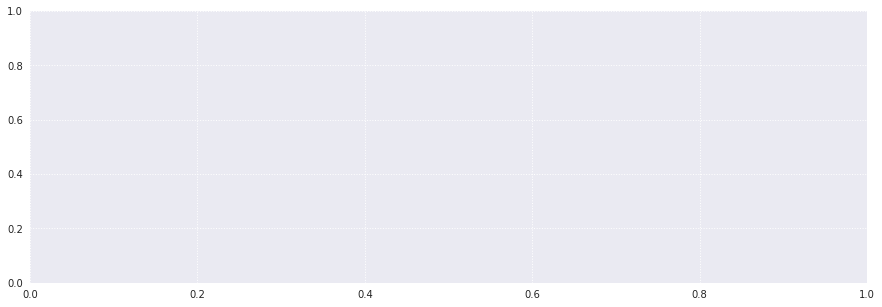

In [9]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' prediction error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Prediction Error $\mathcal{L}^{MSE}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Prediction Error $L^{MSE}$', fontsize=10);

(array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 9 Text major ticklabel objects>)

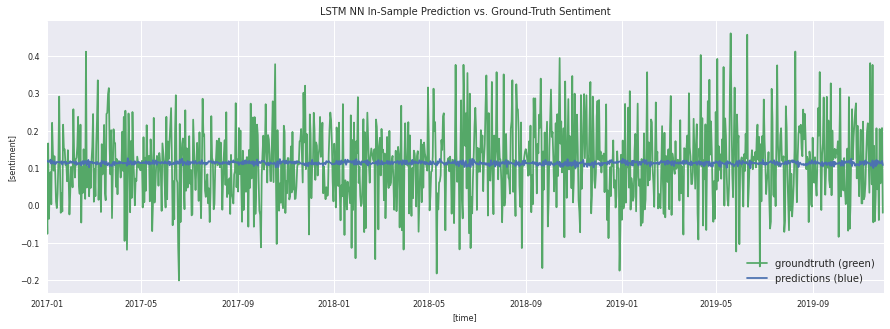

In [10]:
# Evalutation of the model

model_name = compName + '_sentiment_lstm_best_model.pth'
lstm_model.load_state_dict(torch.load(os.path.join("./models", model_name)))

# set model in evaluation mode
lstm_model.eval()

# don't calculate gradients
with torch.no_grad():

    # predict sequence output
    predictions = lstm_model(train_sequences_input)

    # collect prediction batch results
    predictions_list = predictions.detach().numpy()[:, -1].tolist()

    # collect target batch results
    targets_list = train_sequences_target.numpy()[:, -1].tolist()

    
# plot the prediction results
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(pd.to_datetime(sentiment.index).values[0:train_sequences.shape[0],], targets_list, color='C1', label='groundtruth (green)')
ax.plot(pd.to_datetime(sentiment.index).values[0:train_sequences.shape[0],], predictions_list, color='C0', label='predictions (blue)')

# set y-axis limits
ax.set_xlim(pd.to_datetime(sentiment.index).values[0], pd.to_datetime(sentiment.index).values[train_sequences.shape[0]])

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

plt.title('LSTM NN In-Sample Prediction vs. Ground-Truth Sentiment', fontsize=10)
plt.xlabel('[time]', fontsize=8)
plt.ylabel('[sentiment]', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

(array([-0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 <a list of 9 Text major ticklabel objects>)

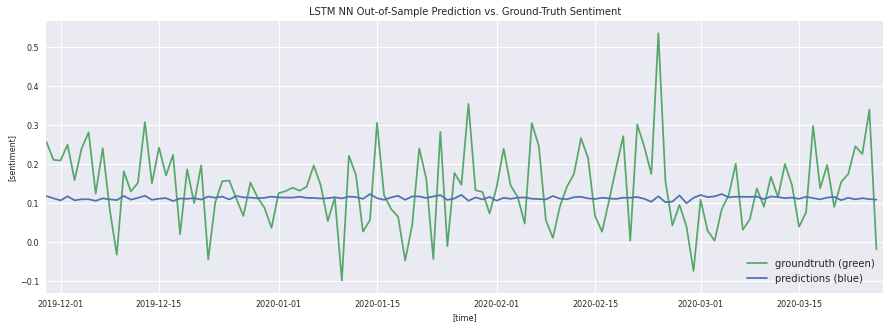

In [11]:
# Out-of-sample evaluation of the model

# don't calculate gradients
with torch.no_grad():

    # predict sequence output
    predictions = lstm_model(valid_sequences_input)

    # collect prediction batch results
    predictions_list = predictions.detach().numpy()[:, -1].tolist()

    # collect target batch results
    targets_list = valid_sequences_target.numpy()[:, -1].tolist()

# plot the prediction results
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(pd.to_datetime(sentiment.index).values[train_sequences.shape[0]:train_sequences.shape[0]+valid_sequences.shape[0],], targets_list, color='C1', label='groundtruth (green)')
ax.plot(pd.to_datetime(sentiment.index).values[train_sequences.shape[0]:train_sequences.shape[0]+valid_sequences.shape[0],], predictions_list, color='C0', label='predictions (blue)')

# set y-axis limits
ax.set_xlim(pd.to_datetime(sentiment.index).values[train_sequences.shape[0]], pd.to_datetime(sentiment.index).values[train_sequences.shape[0]+valid_sequences.shape[0]])
#ax.set_ylim(0.0, 1.0)

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

plt.title('LSTM NN Out-of-Sample Prediction vs. Ground-Truth Sentiment', fontsize=10)
plt.xlabel('[time]', fontsize=8)
plt.ylabel('[sentiment]', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

In [12]:
# Backtest of the model

sentiment_daily_predictions = pd.DataFrame(predictions_list, columns=['PREDICTIONS'])
sentiment_daily_predictions = sentiment_daily_predictions.set_index(pd.to_datetime(sentiment.index).values[train_sequences.shape[0]:train_sequences.shape[0]+valid_sequences.shape[0],])

signal_data = pd.DataFrame(np.where(sentiment_daily_predictions['PREDICTIONS'] > 0.0, 1.0, -1.0), columns=['SIGNAL'])
signal_data = signal_data.set_index(pd.to_datetime(sentiment.index).values[train_sequences.shape[0]:train_sequences.shape[0]+valid_sequences.shape[0],])


stock_market_data = pd.DataFrame(market_data[compTick + ' US Equity'])
stock_market_data = stock_market_data.rename(columns={compTick + ' US Equity': 'PRICE'})
stock_market_data = stock_market_data.set_index(market_data.index)

#sentiment_daily_predictions.head(5)



Text(0.5, 1.0, 'Apple - Daily Historical Stock Closing Prices')

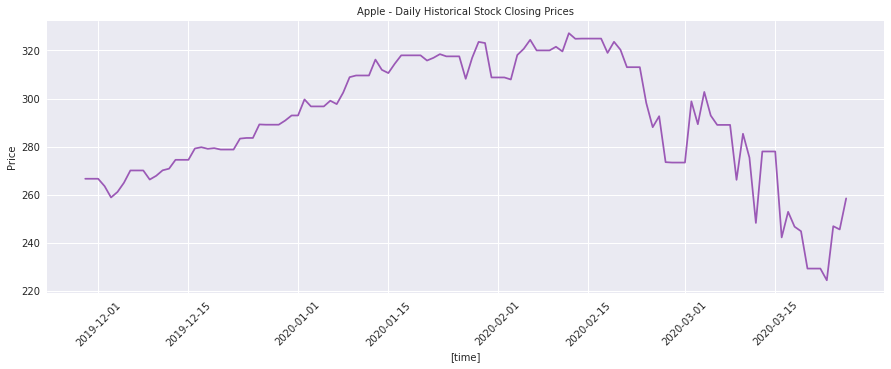

In [13]:
stock_market_data = stock_market_data[stock_market_data.index >= sentiment_daily_predictions.index[0]]
stock_market_data = stock_market_data[stock_market_data.index <= sentiment_daily_predictions.index[-1]]

plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(stock_market_data['PRICE'], color='#9b59b6')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_ylabel('[equity %]', fontsize=10)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_ylabel('Price', fontsize=10)

# set plot title
plt.title(compName + ' - Daily Historical Stock Closing Prices', fontsize=10)


In [14]:

# Calculate gain/loss
np.abs(stock_market_data.iloc[0]['PRICE'] - stock_market_data.iloc[-1]['PRICE']) / stock_market_data.iloc[0]['PRICE']

# Prepare backtest
class LSTMStrategy(bt.Algo):
    
    def __init__(self, signals):
        
        # set class signals
        self.signals = signals
        
    def __call__(self, target):
        
        if target.now in self.signals.index[1:]:
            
            # get actual signal
            signal = self.signals.loc[target.now]
            
            # set target weights according to signal
            target.temp['weights'] = dict(PRICE=signal)
            
        # return True since we want to move on to the next timestep
        return True

lstm_strategy = bt.Strategy('lstm', [bt.algos.SelectAll(), LSTMStrategy(signal_data['SIGNAL']), bt.algos.Rebalance()])

backtest_lstm = bt.Backtest(strategy=lstm_strategy, data=stock_market_data, name='stock_lstm_backtest')

signal_data_base = signal_data.copy(deep=True) 
signal_data_base['SIGNAL'] = 1.0

base_strategy = bt.Strategy('base', [bt.algos.SelectAll(), LSTMStrategy(signal_data_base['SIGNAL']), bt.algos.Rebalance()])
backtest_base = bt.Backtest(strategy=base_strategy, data=stock_market_data, name='stock_base_backtest')

backtest_results = bt.run(backtest_lstm, backtest_base)

stock_lstm_backtest
0% [############################# ] 100% | ETA: 00:00:00stock_base_backtest
0% [############################# ] 100% | ETA: 00:00:00

In [15]:
backtest_results.display()

Stat                 stock_lstm_backtest    stock_base_backtest
-------------------  ---------------------  ---------------------
Start                2019-11-28             2019-11-28
End                  2020-03-26             2020-03-26
Risk-free rate       0.00%                  0.00%

Total Return         -3.07%                 -3.07%
Daily Sharpe         0.10                   0.10
Daily Sortino        0.15                   0.15
CAGR                 -9.12%                 -9.12%
Max Drawdown         -31.42%                -31.42%
Calmar Ratio         -0.29                  -0.29

MTD                  -5.46%                 -5.46%
3m                   -10.64%                -10.64%
6m                   -                      -
YTD                  -11.78%                -11.78%
1Y                   -                      -
3Y (ann.)            -9.12%                 -9.12%
5Y (ann.)            -                      -
10Y (ann.)           -                      -
Since Incep. (an

In [16]:
backtest_lstm_details = backtest_lstm.strategy.data
backtest_lstm_details.columns = ['% EQUITY', 'EQUITY', 'CASH', 'FEES']

backtest_lstm_details.head(10)

,% EQUITY,EQUITY,CASH,FEES
2019-11-28,100.000000,1000000.00,1000000.00,0.0
2019-11-29,100.000000,1000000.00,1000000.00,0.0
2019-11-30,100.000000,1000000.00,186.25,0.0
2019-12-01,100.000000,1000000.00,186.25,0.0
2019-12-02,98.844250,988442.50,186.25,0.0
2019-12-03,97.082125,970821.25,186.25,0.0
2019-12-04,97.938625,979386.25,186.25,0.0
2019-12-05,99.375250,993752.50,186.25,0.0
2019-12-06,101.294500,1012945.00,186.25,0.0
2019-12-07,101.294500,1012945.00,186.25,0.0


In [17]:
backtest_base_details = backtest_base.strategy.data
backtest_base_details.columns = ['% EQUITY', 'EQUITY', 'CASH', 'FEES']

backtest_base_details.head(10)

,% EQUITY,EQUITY,CASH,FEES
2019-11-28,100.000000,1000000.00,1000000.00,0.0
2019-11-29,100.000000,1000000.00,1000000.00,0.0
2019-11-30,100.000000,1000000.00,186.25,0.0
2019-12-01,100.000000,1000000.00,186.25,0.0
2019-12-02,98.844250,988442.50,186.25,0.0
2019-12-03,97.082125,970821.25,186.25,0.0
2019-12-04,97.938625,979386.25,186.25,0.0
2019-12-05,99.375250,993752.50,186.25,0.0
2019-12-06,101.294500,1012945.00,186.25,0.0
2019-12-07,101.294500,1012945.00,186.25,0.0


Text(0.5, 1.0, 'Apple - Backtest % Equity Progression')

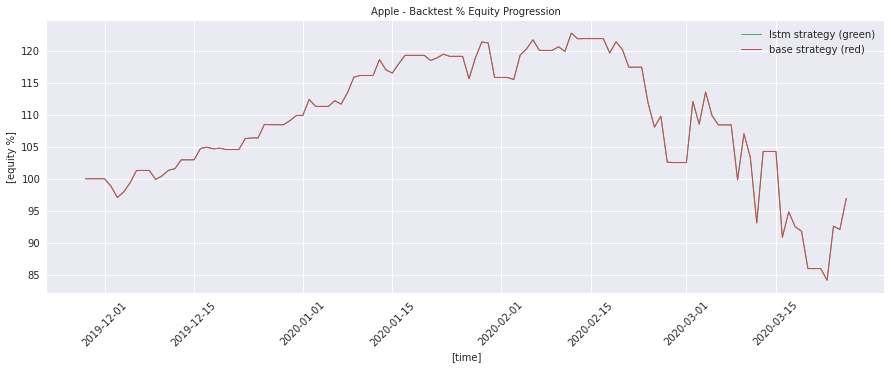

In [22]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(backtest_lstm_details['% EQUITY'], color='C1',lw=1.0, label='lstm strategy (green)')
ax.plot(backtest_base_details['% EQUITY'], color='C2',lw=1.0, label='base strategy (red)')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_ylabel('[equity %]', fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# set plot title
plt.title(compName + ' - Backtest % Equity Progression', fontsize=10)